In [1]:
# 1. Setup and imports
import os
import sys
import subprocess
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import collections
import gc
from tqdm import tqdm
import time

# Clear memory
gc.collect()
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Import cNVAE modules
from vae.vae2d import VAE
from vae.config_vae import ConfigVAE, ConfigTrainVAE
from vae.train_vae import TrainerVAE
from base.dataset import ROFLDS, generate_simulation, save_simulation
from figures.fighelper import show_opticflow, show_opticflow_full, plot_heatmap, plot_bar

# Set random seeds
SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

print("=" * 60)
print("DGX SPARK GPU MEMORY VERIFICATION")
print("=" * 60)

print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")
    
    # Get detailed GPU memory info
    props = torch.cuda.get_device_properties(0)
    total_memory_gb = props.total_memory / (1024**3)
    
    print(f"\n{'GPU MEMORY TEST':=^60}")
    print(f"  Total GPU Memory: {total_memory_gb:.1f} GB")
    
    # Verify we have ~128GB
    if total_memory_gb >= 100:
        print(f"  ✓ VERIFIED: Full ~128GB GPU memory available!")
    else:
        print(f"  ⚠ WARNING: Expected ~128GB, found {total_memory_gb:.1f}GB")
    
    # Test actual memory allocation
    print(f"\n  Testing memory allocation...")
    try:
        # Try to allocate a 10GB tensor to verify memory access
        test_size = int(10 * 1024**3 / 4)  # 10GB of float32
        test_tensor = torch.zeros(test_size, dtype=torch.float32, device='cuda')
        allocated = torch.cuda.memory_allocated() / (1024**3)
        print(f"  ✓ Successfully allocated {allocated:.1f}GB test tensor")
        del test_tensor
        torch.cuda.empty_cache()
        print(f"  ✓ Memory freed successfully")
    except RuntimeError as e:
        print(f"  ✗ Memory allocation failed: {e}")
    
    # Show current memory status
    print(f"\n  Current memory status:")
    print(f"    Allocated: {torch.cuda.memory_allocated() / (1024**3):.2f} GB")
    print(f"    Cached: {torch.cuda.memory_reserved() / (1024**3):.2f} GB")
    print(f"    Free: {(props.total_memory - torch.cuda.memory_allocated()) / (1024**3):.1f} GB")
    
print(f"{'':=^60}")

print(f"\nMPS available: {torch.backends.mps.is_available()}")

# DGX Spark uses CUDA
device = torch.device('cuda') if torch.cuda.is_available() else \
         torch.device('mps') if torch.backends.mps.is_available() else \
         torch.device('cpu')
print(f"\n>>> Using device: {device} <<<")

# Set paths - use current working directory as base
BASE_DIR = Path('/home/jibrahim/code/ROFL-cNVAE')
DATA_DIR = BASE_DIR / 'data'
MODELS_DIR = BASE_DIR / 'models'
RESULTS_DIR = BASE_DIR / 'results'

# Create directories if they don't exist
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"\nBase directory: {BASE_DIR}")
print(f"Data directory: {DATA_DIR}")
print(f"Models directory: {MODELS_DIR}")

DGX SPARK GPU MEMORY VERIFICATION

PyTorch version: 2.10.0.dev20251124+cu128
CUDA available: True
CUDA version: 12.8
CUDA device count: 1
CUDA device name: NVIDIA GB10

======================GPU MEMORY TEST=======================
  Total GPU Memory: 119.7 GB
  ✓ VERIFIED: Full ~128GB GPU memory available!

  Testing memory allocation...


/home/jibrahim/code/ROFL-cNVAE/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:435: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)
    
  queued_call()


  ✓ Successfully allocated 10.0GB test tensor
  ✓ Memory freed successfully

  Current memory status:
    Allocated: 0.00 GB
    Cached: 0.00 GB
    Free: 119.7 GB

MPS available: False

>>> Using device: cuda <<<

Base directory: /home/jibrahim/code/ROFL-cNVAE
Data directory: /home/jibrahim/code/ROFL-cNVAE/data
Models directory: /home/jibrahim/code/ROFL-cNVAE/models


In [2]:
# 2. Load/generate dataset
from base.dataset import generate_simulation, save_simulation

dataset_path = DATA_DIR / 'fixate1_dim-17_n-750k'

if dataset_path.exists():
    print(f"✓ Dataset found at {dataset_path}")
    required_files = ['attrs.npy', 'trn/x.npy', 'vld/x.npy', 'tst/x.npy']
    all_exist = all((dataset_path / f).exists() for f in required_files)
    if all_exist:
        print("✓ All required files present")
        trn_size = np.load(dataset_path / 'trn' / 'x.npy', mmap_mode='r').shape[0]
        vld_size = np.load(dataset_path / 'vld' / 'x.npy', mmap_mode='r').shape[0]
        tst_size = np.load(dataset_path / 'tst' / 'x.npy', mmap_mode='r').shape[0]
        print(f"  Training samples: {trn_size:,}")
        print(f"  Validation samples: {vld_size:,}")
        print(f"  Test samples: {tst_size:,}")
        print(f"  Total: {trn_size + vld_size + tst_size:,}")
    else:
        print("✗ Some files missing - regenerating")
        np.random.seed(SEED)
        kwargs = {'dim': 17, 'fov': 15.0, 'res': 1.0, 'z_bg': 100.0,
                  'obj_r': 5.0, 'obj_bound': 5.0, 'obj_zlim': [20.0, 80.0],
                  'vlim_slf': [2.0, 10.0], 'vlim_obj': [2.0, 10.0], 'residual': False}
        x, g, g_aux, attrs = generate_simulation(
            category='fixate', n_obj=1, total=750000,
            kwargs=kwargs, accept_n={0: 1, 1: 1}, min_obj_size=2)
        x_max = np.percentile(np.abs(x), 98)
        x = np.clip(x, -x_max, x_max) / (x_max + 1e-6)
        save_simulation(save_dir=str(DATA_DIR), x=x, g=g, g_aux=g_aux, attrs=attrs)
        print(f"✓ Dataset regenerated")
else:
    print(f"Dataset not found. Generating (5-10 minutes)...")
    np.random.seed(SEED)
    kwargs = {'dim': 17, 'fov': 15.0, 'res': 1.0, 'z_bg': 100.0,
              'obj_r': 5.0, 'obj_bound': 5.0, 'obj_zlim': [20.0, 80.0],
              'vlim_slf': [2.0, 10.0], 'vlim_obj': [2.0, 10.0], 'residual': False}
    x, g, g_aux, attrs = generate_simulation(
        category='fixate', n_obj=1, total=750000,
        kwargs=kwargs, accept_n={0: 1, 1: 1}, min_obj_size=2)
    x_max = np.percentile(np.abs(x), 98)
    x = np.clip(x, -x_max, x_max) / (x_max + 1e-6)
    save_simulation(save_dir=str(DATA_DIR), x=x, g=g, g_aux=g_aux, attrs=attrs)
    print(f"✓ Dataset created")

✓ Dataset found at /home/jibrahim/code/ROFL-cNVAE/data/fixate1_dim-17_n-750k
✓ All required files present
  Training samples: 600,000
  Validation samples: 75,000
  Test samples: 75,000
  Total: 750,000


Loading training dataset for visualization...
Sample optical flow data:
  Shape: (16, 2, 17, 17)
  Min: -1.0000, Max: 1.0000
  Mean: 0.0276, Std: 0.2511

  Sample statistics:
    Sample 1: vx_mean=-0.2383, vy_mean=-0.0952, mag_max=1.0840
    Sample 2: vx_mean=0.0717, vy_mean=0.0616, mag_max=0.3720
    Sample 3: vx_mean=-0.0377, vy_mean=0.0171, mag_max=0.5323
    Sample 4: vx_mean=0.1993, vy_mean=0.4773, mag_max=1.2466


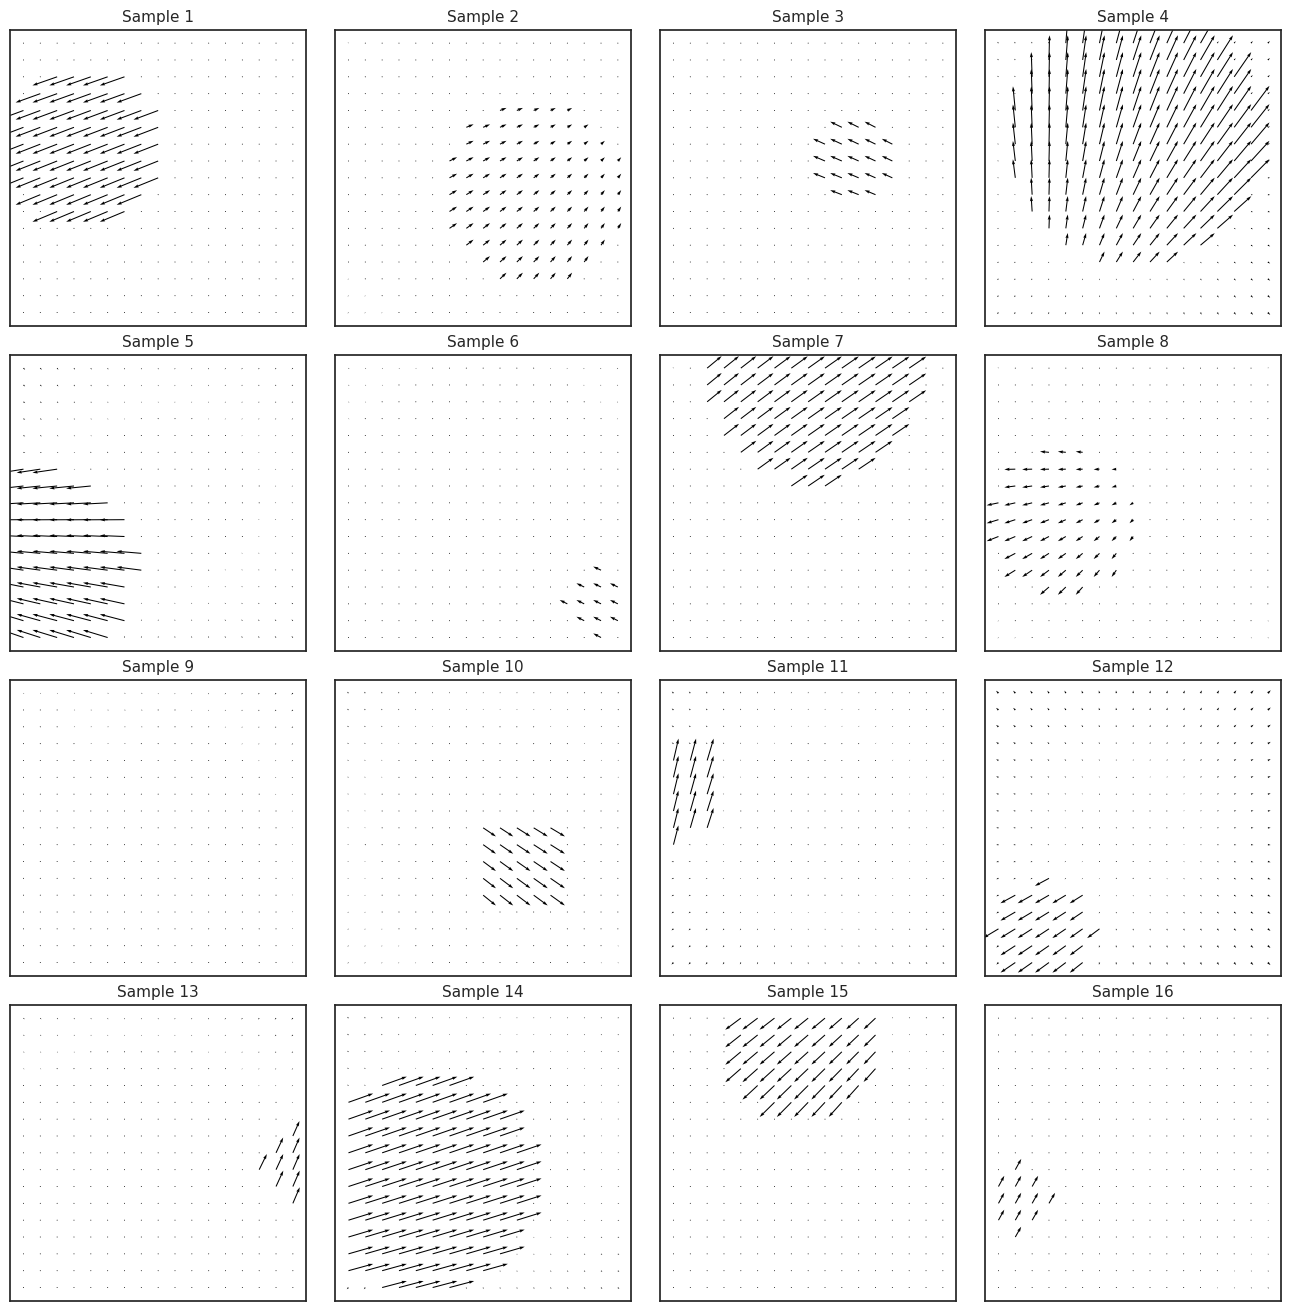

<Figure size 500x320 with 0 Axes>


✓ Visualization complete!


In [3]:
# 3. Visualize sample optical flow - arrow plots
print("Loading training dataset for visualization...")
ds_trn = ROFLDS(str(dataset_path), 'trn', device=None)
ds_vld = ROFLDS(str(dataset_path), 'vld', device=None)
ds_tst = ROFLDS(str(dataset_path), 'tst', device=None)

np.random.seed(SEED)
sample_indices = np.random.choice(len(ds_trn), size=16, replace=False)

samples = []
for idx in sample_indices:
    x, norm = ds_trn[idx]
    samples.append(x)

samples = np.array(samples)

print(f"Sample optical flow data:")
print(f"  Shape: {samples.shape}")
print(f"  Min: {samples.min():.4f}, Max: {samples.max():.4f}")
print(f"  Mean: {samples.mean():.4f}, Std: {samples.std():.4f}")
print(f"\n  Sample statistics:")
for i in range(min(4, len(samples))):
    mag = np.sqrt(samples[i, 0]**2 + samples[i, 1]**2)
    print(f"    Sample {i+1}: vx_mean={samples[i,0].mean():.4f}, vy_mean={samples[i,1].mean():.4f}, mag_max={mag.max():.4f}")

fig, axes = show_opticflow(samples, num=4, titles=[f"Sample {i+1}" for i in range(16)],
                            no_ticks=True, display=True, figsize=(13, 13), scale=12)
fig.suptitle('Training Dataset Samples (Optical Flow)', fontsize=16, y=0.995, fontweight='bold')
plt.tight_layout()
plt.show()
print("\n✓ Visualization complete!")

Detailed breakdown of Sample 4 (magnitude: 0.5757)
  vx: min=-0.0973, max=0.7484
  vy: min=-0.0955, max=1.0000



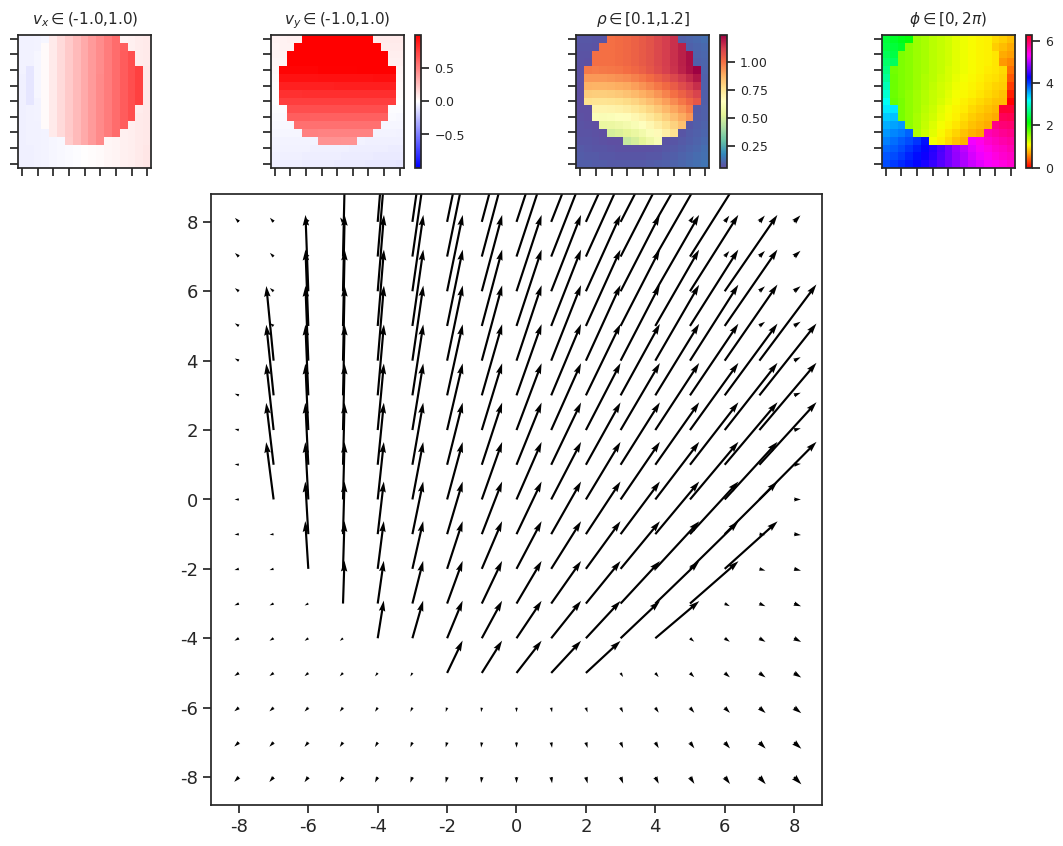

<Figure size 500x320 with 0 Axes>

In [4]:
# 4. Show detailed breakdown of one sample
magnitudes = []
for i, sample in enumerate(samples):
    mag = np.sqrt(sample[0]**2 + sample[1]**2)
    magnitudes.append(mag.mean())

best_idx = np.argmax(magnitudes)
selected_sample = samples[best_idx:best_idx+1]

print(f"Detailed breakdown of Sample {best_idx + 1} (magnitude: {magnitudes[best_idx]:.4f})")
print(f"  vx: min={selected_sample[0,0].min():.4f}, max={selected_sample[0,0].max():.4f}")
print(f"  vy: min={selected_sample[0,1].min():.4f}, max={selected_sample[0,1].max():.4f}\n")

fig, axes = show_opticflow_full(selected_sample[0], cbar=True, display=True,
                                 figsize=(14, 10), title_fontsize=11, tick_spacing=2, scale=8)
fig.suptitle('Optical Flow Components: vx, vy, magnitude, phase', fontsize=14, y=0.995, fontweight='bold')
plt.tight_layout()
plt.show()

Computing dataset statistics (1000 samples)...

Dataset statistics (n=1000 samples, 289000 measurements):
  vx: mean=0.0035, std=0.2036, range=[-1.0000, 1.0000]
  vy: mean=0.0003, std=0.2089, range=[-1.0000, 1.0000]
  mag: mean=0.1195, std=0.2661, range=[0.0000, 1.4142]
  nonzero: 98.2%


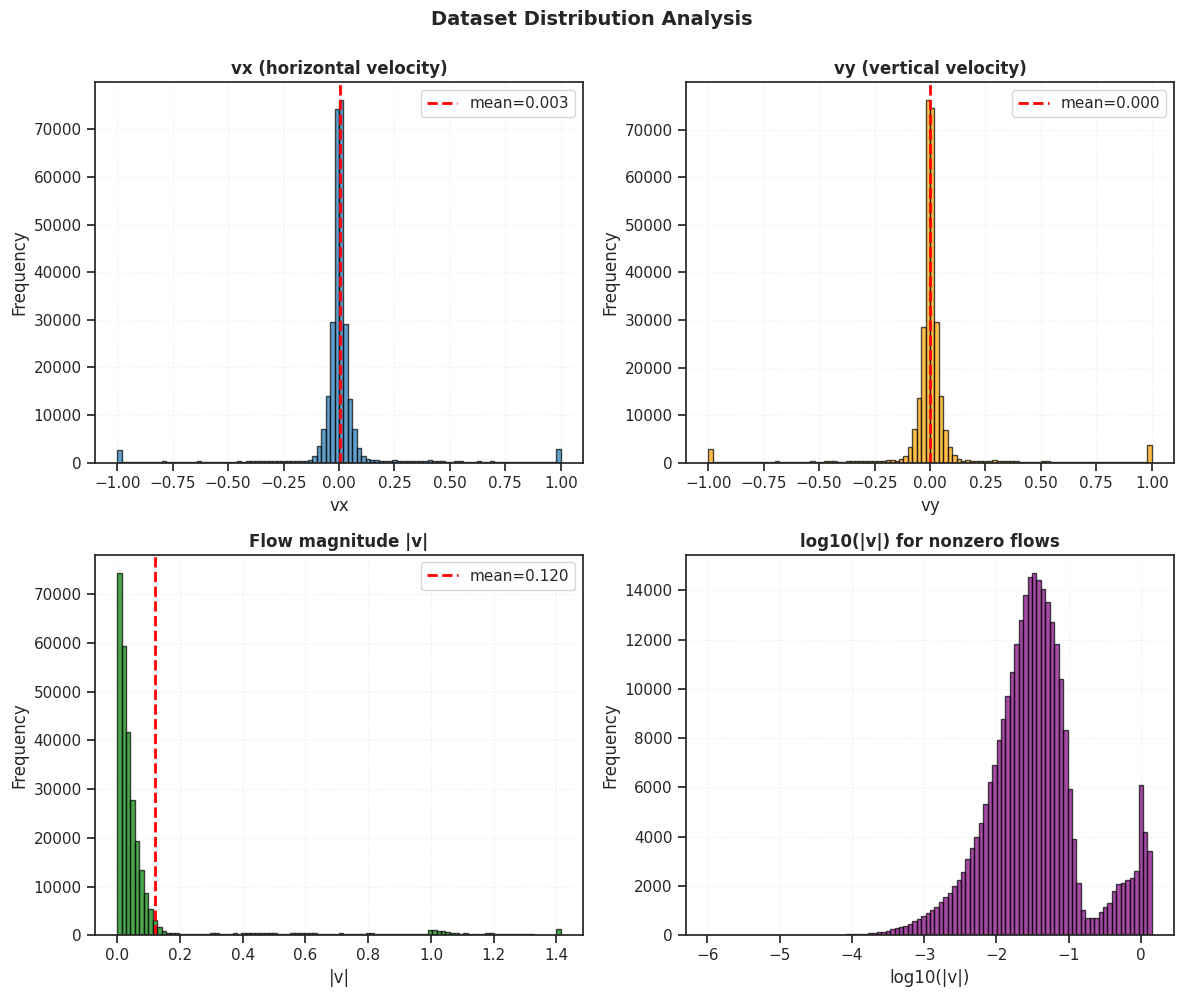


✓ Distribution analysis complete!


In [5]:
# 5. Dataset statistics and distributions
print("Computing dataset statistics (1000 samples)...")
sample_size = min(1000, len(ds_trn))
all_vx, all_vy, all_mag = [], [], []

for i in range(sample_size):
    x, _ = ds_trn[i]
    vx, vy = x[0], x[1]
    mag = np.sqrt(vx**2 + vy**2)
    all_vx.append(vx.flatten())
    all_vy.append(vy.flatten())
    all_mag.append(mag.flatten())

all_vx = np.concatenate(all_vx)
all_vy = np.concatenate(all_vy)
all_mag = np.concatenate(all_mag)

print(f"\nDataset statistics (n={sample_size} samples, {len(all_vx)} measurements):")
print(f"  vx: mean={all_vx.mean():.4f}, std={all_vx.std():.4f}, range=[{all_vx.min():.4f}, {all_vx.max():.4f}]")
print(f"  vy: mean={all_vy.mean():.4f}, std={all_vy.std():.4f}, range=[{all_vy.min():.4f}, {all_vy.max():.4f}]")
print(f"  mag: mean={all_mag.mean():.4f}, std={all_mag.std():.4f}, range=[{all_mag.min():.4f}, {all_mag.max():.4f}]")
print(f"  nonzero: {(all_mag > 1e-3).mean()*100:.1f}%")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].hist(all_vx, bins=100, alpha=0.7, edgecolor='black')
axes[0, 0].axvline(all_vx.mean(), color='r', linestyle='--', linewidth=2, label=f'mean={all_vx.mean():.3f}')
axes[0, 0].set_title('vx (horizontal velocity)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('vx')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

axes[0, 1].hist(all_vy, bins=100, alpha=0.7, edgecolor='black', color='orange')
axes[0, 1].axvline(all_vy.mean(), color='r', linestyle='--', linewidth=2, label=f'mean={all_vy.mean():.3f}')
axes[0, 1].set_title('vy (vertical velocity)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('vy')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

axes[1, 0].hist(all_mag, bins=100, alpha=0.7, edgecolor='black', color='green')
axes[1, 0].axvline(all_mag.mean(), color='r', linestyle='--', linewidth=2, label=f'mean={all_mag.mean():.3f}')
axes[1, 0].set_title('Flow magnitude |v|', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('|v|')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

all_mag_nonzero = all_mag[all_mag > 1e-6]
axes[1, 1].hist(np.log10(all_mag_nonzero), bins=100, alpha=0.7, edgecolor='black', color='purple')
axes[1, 1].set_title('log10(|v|) for nonzero flows', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('log10(|v|)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(alpha=0.3)

plt.suptitle('Dataset Distribution Analysis', fontsize=14, y=0.995, fontweight='bold')
plt.tight_layout()
plt.show()
print("\n✓ Distribution analysis complete!")

In [6]:
# 6. FULL PAPER cNVAE Configuration
# ============================================================================
# EXACT configuration from the NeurIPS 2023 paper:
# "Hierarchical VAEs provide a normative account of motion processing 
#  in the primate brain" - Vafaii, Yates, Butts
#
# Model: compressed Nouveau VAE (cNVAE)
# Key innovation: Non-convolutional latent space (compressed vs NVAE's 17,520 dims)
# ============================================================================

# FULL PAPER MODEL CONFIGURATION (from Supplementary Table 4 & Section 9.2-9.4)
model_config = {
    'sim': 'fixate1',
    
    # Architecture - EXACT PAPER SETTINGS
    'n_ch': 32,                    # Initial channels, doubles per scale (32→64→128→256)
    'input_sz': 17,                # Optical flow resolution: 17×17 (odd for center fixation)
    'ker_sz': 2,                   # Kernel size for convolutions
    'res_eps': 0.1,                # Residual connection epsilon
    
    # Encoder architecture (Section 9.2)
    'n_enc_cells': 2,              # Encoder cells per scale
    'n_enc_nodes': 2,              # Nodes per encoder cell
    
    # Decoder architecture  
    'n_dec_cells': 2,              # Decoder cells per scale
    'n_dec_nodes': 1,              # Nodes per decoder cell
    
    # Pre/Post processing
    'n_pre_cells': 3,              # Pre-processing cells
    'n_pre_blocks': 1,             # Pre-processing blocks
    'n_post_cells': 3,             # Post-processing cells
    'n_post_blocks': 1,            # Post-processing blocks
    
    # LATENT SPACE - EXACT PAPER SETTINGS (Table 4, Section 9.3)
    # 21 hierarchical latent groups total:
    #   - 3 groups at 2×2 scale ("top" latents - sampled first)
    #   - 6 groups at 4×4 scale ("mid" latents)
    #   - 12 groups at 8×8 scale ("bottom" latents - closest to stimulus)
    'n_latent_scales': 3,          # Number of latent scales
    'n_latent_per_group': 20,      # Latent dims per group (d=20 in paper)
    'n_groups_per_scale': 12,      # Groups at finest scale (8×8)
                                   # With ada_groups: [12, 6, 3] across scales
    
    # Key features (Section 9.2)
    'activation_fn': 'swish',      # Swish activation (instrumental for training)
    'balanced_recon': True,        # Balanced reconstruction loss
    'residual_kl': True,           # Residual Normal parameterization (helpful)
    'ada_groups': True,            # Adaptive groups per scale
    'compress': True,              # KEY: Compressed latent space (vs convolutional NVAE)
    'use_se': True,                # Squeeze-and-excitation (helped per paper)
    'use_bn': False,               # NO batch norm (destabilized training)
    'weight_norm': True,           # Weight normalization (instrumental)
    'spectral_norm': 0,            # No spectral regularization needed
    
    # Saving
    'full': True,
    'save': False,
    'base_dir': str(BASE_DIR),
    'seed': SEED,
}

# ============================================================================
# LATENT SPACE STRUCTURE (from paper Table 4 & Section 9.3)
# ============================================================================
# The cNVAE key innovation: COMPRESSED latent space
#
# NVAE (original): Convolutional latents → 17,520 dimensions!
#   D = (3×2² + 6×4² + 12×8²) × 20 = (12 + 96 + 768) × 20 = 17,520
#
# cNVAE (this paper): Compressed latents → 420 dimensions
#   D = (3 + 6 + 12) × 20 = 21 × 20 = 420
#
# This 41× compression is achieved by:
# 1. Sampler layers integrate over space BEFORE sampling (kernel = spatial scale)
# 2. Expand layers (deconvolution) project latents back to spatial dimensions
# ============================================================================

print("="*70)
print("FULL PAPER cNVAE MODEL CONFIGURATION")
print("(NeurIPS 2023: Vafaii, Yates, Butts)")
print("="*70)

print(f"\n✓ DGX Spark GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB VRAM - sufficient for full training!")

# Calculate groups per scale (paper's exact structure)
# From Table 4: 12 groups at 8×8, 6 groups at 4×4, 3 groups at 2×2
groups_8x8 = 12  # "bottom" latents - closest to stimulus
groups_4x4 = 6   # "mid" latents
groups_2x2 = 3   # "top" latents - sampled first
total_groups = groups_8x8 + groups_4x4 + groups_2x2  # = 21

print("\nHIERARCHICAL LATENT STRUCTURE (Table 4):")
print("-"*50)
print(f"  Scale 8×8 ('bottom'): {groups_8x8} groups × 20 dims = {groups_8x8 * 20} latents")
print(f"  Scale 4×4 ('mid'):    {groups_4x4} groups × 20 dims = {groups_4x4 * 20} latents")
print(f"  Scale 2×2 ('top'):    {groups_2x2} groups × 20 dims = {groups_2x2 * 20} latents")
print("-"*50)
print(f"  TOTAL: {total_groups} groups × 20 dims = {total_groups * 20} latent dimensions")

print("\nCOMPRESSION vs NVAE:")
nvae_dims = (groups_2x2 * 4 + groups_4x4 * 16 + groups_8x8 * 64) * 20
cnvae_dims = total_groups * 20
print(f"  NVAE (convolutional):  {nvae_dims:,} dimensions")
print(f"  cNVAE (compressed):    {cnvae_dims} dimensions")
print(f"  Compression ratio:     {nvae_dims / cnvae_dims:.1f}×")

print("\nARCHITECTURE PARAMETERS:")
for key in ['n_ch', 'n_enc_cells', 'n_enc_nodes', 'n_dec_cells', 'n_dec_nodes']:
    print(f"  {key}: {model_config[key]}")

print("\nKEY FEATURES:")
print(f"  Swish activation:      {model_config['activation_fn']}")
print(f"  Weight normalization:  {model_config['weight_norm']}")
print(f"  Squeeze-excitation:    {model_config['use_se']}")
print(f"  Batch normalization:   {model_config['use_bn']} (destabilizes training)")
print(f"  Residual KL:           {model_config['residual_kl']}")
print("="*70)

FULL PAPER cNVAE MODEL CONFIGURATION
(NeurIPS 2023: Vafaii, Yates, Butts)

✓ DGX Spark GPU: 128.5 GB VRAM - sufficient for full training!

HIERARCHICAL LATENT STRUCTURE (Table 4):
--------------------------------------------------
  Scale 8×8 ('bottom'): 12 groups × 20 dims = 240 latents
  Scale 4×4 ('mid'):    6 groups × 20 dims = 120 latents
  Scale 2×2 ('top'):    3 groups × 20 dims = 60 latents
--------------------------------------------------
  TOTAL: 21 groups × 20 dims = 420 latent dimensions

COMPRESSION vs NVAE:
  NVAE (convolutional):  17,520 dimensions
  cNVAE (compressed):    420 dimensions
  Compression ratio:     41.7×

ARCHITECTURE PARAMETERS:
  n_ch: 32
  n_enc_cells: 2
  n_enc_nodes: 2
  n_dec_cells: 2
  n_dec_nodes: 1

KEY FEATURES:
  Swish activation:      swish
  Weight normalization:  True
  Squeeze-excitation:    True
  Batch normalization:   False (destabilizes training)
  Residual KL:           True


In [7]:
# 7. FULL PAPER Training Configuration
# ============================================================================
# Training hyperparameters from Section 9.4 of the supplementary material.
# ============================================================================

train_config = {
    # Optimizer settings - EXACT PAPER VALUES (Section 9.4)
    'lr': 0.002,                   # Learning rate
    'epochs': 160,                 # 160 epochs = 160k steps
    'batch_size': 600,             # Batch size (requires large GPU)
    'warm_restart': 0,             # No warm restarts (unlike NVAE suggestion)
    'warmup_portion': 0.0125,      # LR warmup portion
    'optimizer': 'adamax_fast',    # AdaMax optimizer (not Adam)
    'scheduler_type': 'cosine',    # Cosine LR schedule (no warm restarts)
    'ema_rate': 0.999,             # Exponential moving average
    'grad_clip': 250,              # Gradient clipping (empirically determined)
    'use_amp': False,              # No mixed precision
    
    # KL annealing - PAPER SETTINGS (Section 9.4)
    # "We annealed the KL term during the first half of the training"
    'kl_beta': 1.0,                # Final KL weight (standard ELBO)
    'kl_beta_min': 1e-4,           # Minimum during warmup
    'kl_balancer': 'equal',        # "Equal amount of info in each latent group"
    'kl_anneal_cycles': 0,         # Linear annealing (0 = no cosine cycles)
    'kl_anneal_portion': 0.5,      # Anneal during FIRST HALF of training
    'kl_const_portion': 0.01,      # Constant portion at start
    
    # Weight regularization
    'lambda_anneal': True,         # Anneal weight regularization
    'lambda_norm': 1e-3,           # Final regularization weight
    'lambda_init': 1e-7,           # Initial regularization weight
    'spectral_reg': False,         # No spectral regularization (not needed)
    
    # Logging and checkpoints
    'chkpt_freq': 10,              # Save every 10 epochs
    'eval_freq': 2,
    'log_freq': 10,
}

print("="*70)
print("FULL PAPER TRAINING CONFIGURATION")
print("(Section 9.4 of Supplementary Material)")
print("="*70)

gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
print(f"\n✓ GPU MEMORY: {gpu_memory:.1f} GB available")
print(f"  batch_size=600 requires ~16GB+ VRAM")
print(f"  Your GPU has {gpu_memory:.1f} GB - sufficient for full training!\n")

print("OPTIMIZER (Section 9.4):")
print(f"  Optimizer:       AdaMax (not Adam)")
print(f"  Learning rate:   {train_config['lr']}")
print(f"  Batch size:      {train_config['batch_size']}")
print(f"  Epochs:          {train_config['epochs']} (= 160k steps)")
print(f"  Gradient clip:   {train_config['grad_clip']} (empirically determined)")
print(f"  LR schedule:     Cosine (no warm restarts)")

print("\nKL ANNEALING (Section 9.4):")
print(f"  Strategy:        Anneal during first 50% of training")
print(f"  KL balancing:    Equal info across all latent groups")
print(f"  β range:         {train_config['kl_beta_min']} → {train_config['kl_beta']}")

# Training statistics from paper
n_train_samples = 600000  # 600k training samples
n_val_samples = 75000     # 75k validation
n_test_samples = 75000    # 75k test
steps_per_epoch = n_train_samples // train_config['batch_size']
total_steps = steps_per_epoch * train_config['epochs']
kl_anneal_steps = int(train_config['kl_anneal_portion'] * total_steps)

print(f"\nTRAINING SCHEDULE:")
print(f"  Dataset:         750k samples (600k/75k/75k split)")
print(f"  Steps per epoch: {steps_per_epoch:,}")
print(f"  Total steps:     {total_steps:,}")
print(f"  KL annealing:    First {kl_anneal_steps:,} steps")
print(f"  Hardware:        DGX Spark ({gpu_memory:.1f} GB VRAM)")

print("\nβ-VAE EXPERIMENTS (Section 9.5):")
print("  Paper scanned β ∈ [0.01, 10] to study disentanglement")
print("  Best untangling: cNVAE at β=0.15, VAE at β=1.5")
print("  Brain alignment: cNVAE shows sparse latent-neuron mapping")
print("="*70)

FULL PAPER TRAINING CONFIGURATION
(Section 9.4 of Supplementary Material)

✓ GPU MEMORY: 128.5 GB available
  batch_size=600 requires ~16GB+ VRAM
  Your GPU has 128.5 GB - sufficient for full training!

OPTIMIZER (Section 9.4):
  Optimizer:       AdaMax (not Adam)
  Learning rate:   0.002
  Batch size:      600
  Epochs:          160 (= 160k steps)
  Gradient clip:   250 (empirically determined)
  LR schedule:     Cosine (no warm restarts)

KL ANNEALING (Section 9.4):
  Strategy:        Anneal during first 50% of training
  KL balancing:    Equal info across all latent groups
  β range:         0.0001 → 1.0

TRAINING SCHEDULE:
  Dataset:         750k samples (600k/75k/75k split)
  Steps per epoch: 1,000
  Total steps:     160,000
  KL annealing:    First 80,000 steps
  Hardware:        DGX Spark (128.5 GB VRAM)

β-VAE EXPERIMENTS (Section 9.5):
  Paper scanned β ∈ [0.01, 10] to study disentanglement
  Best untangling: cNVAE at β=0.15, VAE at β=1.5
  Brain alignment: cNVAE shows sparse 

In [8]:
# 8. Initialize FULL PAPER Model
# ============================================================================
# Creates the exact cNVAE architecture from the paper.
# Model has ~24M parameters and 420 latent dimensions.
# ============================================================================
import importlib

# Reload modules to pick up fresh configs
for mod in list(sys.modules.keys()):
    if 'base' in mod or 'vae' in mod or 'analysis' in mod:
        del sys.modules[mod]

from vae.vae2d import VAE
from vae.config_vae import ConfigVAE, ConfigTrainVAE

print("="*70)
print("INITIALIZING FULL PAPER cNVAE MODEL")
print("="*70)

# Create config with full paper settings
cfg_vae = ConfigVAE(**model_config)
print(f"\nModel Name: {cfg_vae.name()}")

# Check the actual groups configuration
print(f"\nLatent Groups Configuration:")
print(f"  cfg.groups (coarse→fine): {cfg_vae.groups}")
print(f"  n_latent_per_group: {cfg_vae.n_latent_per_group}")

# Initialize model on CPU first to avoid OOM
print("\nCreating model on CPU (to avoid OOM)...")
vae_model = VAE(cfg_vae)

# Model statistics
total_params = sum(p.numel() for p in vae_model.parameters())
trainable_params = sum(p.numel() for p in vae_model.parameters() if p.requires_grad)
total_latents = vae_model.total_latents()

print(f"\n{'='*70}")
print("MODEL ARCHITECTURE SUMMARY")
print("="*70)
print(f"Total parameters:     {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Total latent dims:    {total_latents}")

# Expected from paper: 21 groups × 20 dims = 420
expected_latents = 21 * 20
print(f"Expected (paper):     {expected_latents}")
if total_latents != expected_latents:
    print(f"⚠️  Latent count differs from paper! Check n_groups_per_scale")

# Feature sizes per scale
enc_ftrs, dec_ftrs = vae_model.ftr_sizes()
print(f"\nFeature Channels per Scale:")
print(f"  Encoder: {enc_ftrs}")
print(f"  Decoder: {dec_ftrs}")

# Detailed latent structure (matching paper's Table 4)
print(f"\n{'='*70}")
print("HIERARCHICAL LATENT STRUCTURE (Section 9.3)")
print("="*70)
groups = cfg_vae.groups  # coarse to fine
n_per_group = cfg_vae.n_latent_per_group
scales = list(enc_ftrs.keys())

# Build scale_info for later analysis cells
scale_info = []
latent_idx = 0

# Paper convention: groups are ordered coarse→fine for sampling
# But for display, we show fine→coarse to match spatial scales
print(f"\n{'Scale':<12} {'Resolution':<12} {'Groups':<10} {'Latents':<10} {'Indices':<15}")
print("-"*60)

for scale_idx, n_groups in enumerate(reversed(groups)):  # fine to coarse display
    if scale_idx < len(scales):
        scale = scales[scale_idx]
        spatial_size = 17 // scale
    else:
        spatial_size = 17 // (2 ** (len(groups) - 1 - scale_idx))
        scale = 17 // spatial_size
    
    latents_this_scale = n_groups * n_per_group
    
    scale_info.append({
        'scale_idx': scale_idx,
        'n_groups': n_groups,
        'spatial_res': spatial_size,
        'start_idx': latent_idx,
        'end_idx': latent_idx + latents_this_scale,
        'n_latents': latents_this_scale,
    })
    
    label = "bottom" if scale_idx == 0 else ("top" if scale_idx == len(groups)-1 else "mid")
    print(f"{label:<12} {spatial_size}×{spatial_size:<10} {n_groups:<10} {latents_this_scale:<10} [{latent_idx}, {latent_idx + latents_this_scale})")
    latent_idx += latents_this_scale

print("-"*60)
print(f"{'TOTAL':<12} {'':<12} {sum(groups):<10} {latent_idx:<10}")

# Memory estimate
param_bytes = total_params * 4  # float32
gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
print(f"\nMEMORY ESTIMATES:")
print(f"  Model weights:     {param_bytes / 1024**2:.1f} MB")
print(f"  With gradients:    {param_bytes * 3 / 1024**2:.1f} MB")
print(f"  Batch of 600:      ~8-16 GB activations")
print(f"  Available GPU:     {gpu_memory:.1f} GB - ✓ SUFFICIENT")

# Try moving to device
print(f"\n{'='*70}")
print(f"Attempting to move model to {device}...")
try:
    vae_model = vae_model.to(device)
    print(f"✓ Model successfully on {device}")
except RuntimeError as e:
    print(f"✗ GPU OOM: {e}")
    print("  Model remains on CPU - evaluation will be slow")
    
print("="*70)
print(f"\n✓ READY FOR FULL TRAINING on DGX Spark ({gpu_memory:.1f} GB VRAM)")
print("="*70)

INITIALIZING FULL PAPER cNVAE MODEL

Model Name: fixate1_z-20x[3,6,12]_k-32_d-17_enc(2x2)-dec(2x1)-pre(1x3)-post(1x3)_wn

Latent Groups Configuration:
  cfg.groups (coarse→fine): [12, 6, 3]
  n_latent_per_group: 20

Creating model on CPU (to avoid OOM)...

MODEL ARCHITECTURE SUMMARY
Total parameters:     25,515,862
Trainable parameters: 25,499,858
Total latent dims:    420
Expected (paper):     420

Feature Channels per Scale:
  Encoder: {8: 1600, 4: 1664, 2: 1792}
  Decoder: {2: 1024, 4: 1664, 8: 1600}

HIERARCHICAL LATENT STRUCTURE (Section 9.3)

Scale        Resolution   Groups     Latents    Indices        
------------------------------------------------------------
bottom       2×2          3          60         [0, 60)
mid          4×4          6          120        [60, 180)
top          8×8          12         240        [180, 420)
------------------------------------------------------------
TOTAL                     21         420       

MEMORY ESTIMATES:
  Model weights:   

In [9]:
# 9. Setup Data Loaders and Load Ground Truth Factors
# ============================================================================
# Create data loaders and load ground-truth generative factors for analysis.
# ============================================================================
from torch.utils.data import DataLoader

# Use smaller batch size for evaluation (even if paper uses 600)
eval_batch_size = 64  # Reasonable for evaluation on limited GPU

dl_trn = DataLoader(ds_trn, batch_size=eval_batch_size, shuffle=True, drop_last=True, num_workers=0)
dl_vld = DataLoader(ds_vld, batch_size=eval_batch_size, shuffle=False, drop_last=False, num_workers=0)
dl_tst = DataLoader(ds_tst, batch_size=eval_batch_size, shuffle=False, drop_last=False, num_workers=0)

print("="*70)
print("DATA LOADERS AND GROUND TRUTH")
print("="*70)
print(f"\nBatch size for evaluation: {eval_batch_size}")
print(f"  Training batches: {len(dl_trn):,}")
print(f"  Validation batches: {len(dl_vld):,}")
print(f"  Test batches: {len(dl_tst):,}")

# Load ground truth factors for latent analysis
print(f"\nGround Truth Factors:")
print(f"  Main factors (g): {ds_tst.f}")
print(f"  Auxiliary factors (g_aux): {ds_tst.f_aux}")

# Combine factors for analysis
g_tst = np.concatenate([ds_tst.g, ds_tst.g_aux], axis=1)
g_vld = np.concatenate([ds_vld.g, ds_vld.g_aux], axis=1)
all_factor_names = list(ds_tst.f) + list(ds_tst.f_aux)

print(f"\nCombined factors shape: {g_tst.shape}")
print(f"Factor names ({len(all_factor_names)}):")
for i, name in enumerate(all_factor_names):
    print(f"  [{i:2d}] {name}")

# Key factors for visualization
key_factors = ['fix_x', 'fix_y', 'slf_v_norm', 'slf_v_phi', 
               'obj0_alpha_x', 'obj0_alpha_y', 'obj0_z']
key_factor_indices = [all_factor_names.index(f) for f in key_factors if f in all_factor_names]
print(f"\nKey factors for analysis: {key_factors[:len(key_factor_indices)]}")
print("="*70)

DATA LOADERS AND GROUND TRUTH

Batch size for evaluation: 64
  Training batches: 9,375
  Validation batches: 1,172
  Test batches: 1,172

Ground Truth Factors:
  Main factors (g): ['fix_x', 'fix_y', 'slf_v_norm', 'slf_v_theta', 'slf_v_phi', 'obj0_alpha_x', 'obj0_alpha_y', 'obj0_z', 'obj0_v_norm', 'obj0_v_theta', 'obj0_v_phi']
  Auxiliary factors (g_aux): ['slf_v_x', 'slf_v_y', 'slf_v_z', 'obj0_size_eff', 'obj0_size', 'obj0_theta', 'obj0_phi', 'obj0_x', 'obj0_y', 'obj0_distance', 'obj0_dx', 'obj0_dy', 'obj0_dz', 'obj0_v_x', 'obj0_v_y', 'obj0_v_z', 'obj0_dv_x', 'obj0_dv_y', 'obj0_dv_z', 'obj0_dv_norm', 'obj0_dv_theta', 'obj0_dv_phi']

Combined factors shape: (75000, 33)
Factor names (33):
  [ 0] fix_x
  [ 1] fix_y
  [ 2] slf_v_norm
  [ 3] slf_v_theta
  [ 4] slf_v_phi
  [ 5] obj0_alpha_x
  [ 6] obj0_alpha_y
  [ 7] obj0_z
  [ 8] obj0_v_norm
  [ 9] obj0_v_theta
  [10] obj0_v_phi
  [11] slf_v_x
  [12] slf_v_y
  [13] slf_v_z
  [14] obj0_size_eff
  [15] obj0_size
  [16] obj0_theta
  [17] obj0_

In [29]:
# 10. FULL TRAINING LOOP
# ============================================================================
# Full training with the DGX Spark's 128GB GPU memory.
# 
# Set DEMO_MODE = True for a quick test (2 epochs), False for full training (160 epochs).
# Full training takes ~40-80 hours.
# Checkpoints are saved to .ipynb_checkpoints/ (gitignored)
# ============================================================================

DEMO_MODE = False  # FULL 160-epoch training as per paper
MODEL_NAME = "cuda13"  # Name prefix for checkpoint files

from base.utils_model import kl_balancer_coeff, beta_anneal_linear
import time

print("="*70)
print("TRAINING LOOP - FULL PAPER MODEL")
print("="*70)

gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
print(f"\n✓ DGX Spark GPU: {gpu_memory:.1f} GB VRAM - running full training!")

if DEMO_MODE:
    print("\n⚡ DEMO MODE: Running 2 epochs to verify training works")
    n_epochs = 2
else:
    n_epochs = train_config['epochs']
    print(f"\n🚀 FULL TRAINING MODE: {n_epochs} epochs (expect ~40-80 hours)")

# Create train config
cfg_train = ConfigTrainVAE(**train_config)

# Setup save directory - use .ipynb_checkpoints (gitignored)
checkpoint_dir = BASE_DIR / '.ipynb_checkpoints'
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# Check for pretrained checkpoint
checkpoint_path = checkpoint_dir / f'{MODEL_NAME}_checkpoint_best.pt'
pretrained_loaded = False
start_epoch = 0
saved_optimizer_state = None
saved_train_losses = []
saved_val_losses = []
saved_best_val_loss = float('inf')

print(f"Checkpoint directory: {checkpoint_dir}")
print(f"Model name: {MODEL_NAME}")

if checkpoint_path.exists():
    print(f"\nFound pretrained checkpoint: {checkpoint_path}")
    try:
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
        
        # Load model state
        if 'model_state_dict' in checkpoint:
            vae_model.load_state_dict(checkpoint['model_state_dict'])
        elif 'model' in checkpoint:
            vae_model.load_state_dict(checkpoint['model'])
        else:
            vae_model.load_state_dict(checkpoint)
        
        pretrained_loaded = True
        print(f"✓ Loaded pretrained model")
        
        # Load optimizer state if available
        if 'optimizer' in checkpoint:
            saved_optimizer_state = checkpoint['optimizer']
            print(f"✓ Found saved optimizer state")
        
        # Load training history if available
        if 'train_losses' in checkpoint:
            saved_train_losses = checkpoint['train_losses']
            print(f"✓ Found training history ({len(saved_train_losses)} epochs)")
        if 'val_losses' in checkpoint:
            saved_val_losses = checkpoint['val_losses']
        if 'val_loss' in checkpoint:
            saved_best_val_loss = checkpoint['val_loss']
            print(f"✓ Best val loss from checkpoint: {saved_best_val_loss:.4f}")
        
        # Get epoch info
        if 'metadata' in checkpoint:
            if 'global_step' in checkpoint['metadata']:
                print(f"  Global step: {checkpoint['metadata']['global_step']}")
            if 'epoch' in checkpoint['metadata']:
                start_epoch = checkpoint['metadata']['epoch']
                print(f"  Resuming from epoch: {start_epoch}")
        
    except Exception as e:
        print(f"✗ Failed to load checkpoint: {e}")
        print("  Will train from scratch.")

# Initialize tracking values - restore from checkpoint if available
train_losses = saved_train_losses.copy()
train_mse = []
val_losses = saved_val_losses.copy()
val_mse = []
best_val_loss = saved_best_val_loss
epoch_times = []

# Run training
run_training = (not pretrained_loaded) or (start_epoch < n_epochs)

if run_training:
    print("\n" + "-"*70)
    print("STARTING TRAINING")
    print("-"*70)
    print(f"  Starting from epoch: {start_epoch + 1}")
    print(f"  Total epochs: {n_epochs}")
    print(f"  Batch size: {train_config['batch_size']}")
    print(f"  Learning rate: {train_config['lr']}")
    print(f"  Device: {device}")
    
    # Create training data loader
    dl_trn_full = DataLoader(ds_trn, batch_size=train_config['batch_size'], 
                             shuffle=True, drop_last=True, num_workers=0)
    dl_vld_full = DataLoader(ds_vld, batch_size=train_config['batch_size'], 
                             shuffle=False, drop_last=False, num_workers=0)
    
    print(f"  Batches per epoch: {len(dl_trn_full)}")
    
    # Setup optimizer (Adamax as per paper)
    optimizer = torch.optim.Adamax(vae_model.parameters(), lr=cfg_train.lr)
    
    # Restore optimizer state if available (CRITICAL for proper resumption)
    if saved_optimizer_state is not None:
        try:
            optimizer.load_state_dict(saved_optimizer_state)
            print(f"  ✓ Restored optimizer state")
        except Exception as e:
            print(f"  ⚠️ Could not restore optimizer state: {e}")
    
    # Setup learning rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=n_epochs * len(dl_trn_full))
    
    # Advance scheduler to correct position if resuming
    gstep = start_epoch * len(dl_trn_full)
    if start_epoch > 0:
        print(f"  Advancing scheduler to step {gstep}...")
        for _ in range(gstep):
            scheduler.step()
        print(f"  ✓ Scheduler advanced, current LR: {scheduler.get_last_lr()[0]:.6f}")
    
    # Setup KL balancer coefficients
    n_iters = n_epochs * len(dl_trn_full)
    alphas = kl_balancer_coeff(groups=cfg_vae.groups, fun=cfg_train.kl_balancer)
    alphas = torch.tensor(alphas, device=device, dtype=torch.float32)
    
    # Setup beta annealing
    betas = beta_anneal_linear(
        n_iters=n_iters,
        beta=cfg_train.kl_beta,
        anneal_portion=cfg_train.kl_anneal_portion,
        constant_portion=cfg_train.kl_const_portion,
        min_beta=cfg_train.kl_beta_min,
    )
    
    # Setup weight decay annealing
    wd_const_portion = min(cfg_train.kl_const_portion * 10, 0.05)
    wd_coeffs = beta_anneal_linear(
        n_iters=n_iters,
        beta=cfg_train.lambda_norm,
        anneal_portion=cfg_train.kl_anneal_portion,
        constant_portion=wd_const_portion,
        min_beta=cfg_train.lambda_init,
    )
    
    n_iters_warmup = int(np.round(n_iters * cfg_train.warmup_portion))
    
    print(f"\n  Total iterations: {n_iters:,}")
    print(f"  Warmup iterations: {n_iters_warmup:,}")
    print(f"  Current beta (KL weight): {betas[min(gstep, len(betas)-1)]:.6f}")
    
    # Import kl_balancer function
    from base.utils_model import kl_balancer as kl_balancer_fn
    
    start_time = time.time()
    
    print(f"\nTraining started...")
    
    for epoch in range(start_epoch, n_epochs):
        epoch_start = time.time()
        vae_model.train()
        epoch_loss = 0.0
        epoch_mse = 0.0
        n_batches = 0
        
        pbar = tqdm(dl_trn_full, desc=f"Epoch {epoch+1}/{n_epochs}", leave=True)
        for batch_idx, (x, norm) in enumerate(pbar):
            # Warmup LR (only in early training)
            if gstep < n_iters_warmup:
                lr = cfg_train.lr * gstep / max(1, n_iters_warmup)
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr
            
            # Move to device
            x = x.to(device, non_blocking=True)
            norm = norm.to(device, non_blocking=True)
            
            # Zero gradients
            optimizer.zero_grad(set_to_none=True)
            
            # Forward pass
            y, latents, q_all, p_all = vae_model(x)
            
            # Reconstruction loss (EPE)
            epe = vae_model.loss_recon(x=x, y=y, w=1/norm)
            
            # KL divergence loss
            kl_all, kl_diag = vae_model.loss_kl(q_all, p_all)
            
            # Balanced KL with annealing
            balanced_kl, gamma, kl_vals = kl_balancer_fn(
                kl_all=kl_all,
                alpha=alphas,
                coeff=betas[min(gstep, len(betas)-1)],
                beta=cfg_train.kl_beta,
            )
            
            # Total loss
            loss = torch.mean(epe + balanced_kl)
            
            # Weight regularization
            loss_w = vae_model.loss_weight()
            if loss_w is not None:
                loss += wd_coeffs[min(gstep, len(wd_coeffs)-1)] * loss_w
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping
            if cfg_train.grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(vae_model.parameters(), cfg_train.grad_clip)
            
            # Update weights
            optimizer.step()
            scheduler.step()
            
            epoch_loss += loss.item()
            epoch_mse += torch.mean((x - y) ** 2).item()
            n_batches += 1
            gstep += 1
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f'{epoch_loss/n_batches:.4f}',
                'mse': f'{epoch_mse/n_batches:.4f}',
                'β': f'{betas[min(gstep-1, len(betas)-1)]:.4f}',
            })
        
        # Record epoch stats
        epoch_time = time.time() - epoch_start
        epoch_times.append(epoch_time)
        train_losses.append(epoch_loss / n_batches)
        train_mse.append(epoch_mse / n_batches)
        
        avg_time = np.mean(epoch_times)
        remaining = avg_time * (n_epochs - epoch - 1) / 3600
        
        print(f"Epoch {epoch+1:3d}/{n_epochs}: loss={train_losses[-1]:.4f}, mse={train_mse[-1]:.4f}, "
              f"β={betas[min(gstep-1, len(betas)-1)]:.4f}, "
              f"time={epoch_time:.1f}s" + (f", ~{remaining:.1f}h remaining" if remaining > 0.1 else ""))
        
        # Validation
        if (epoch + 1) % cfg_train.eval_freq == 0 or epoch == n_epochs - 1:
            vae_model.eval()
            val_loss = 0.0
            val_mse_epoch = 0.0
            n_val = 0
            with torch.no_grad():
                for x, norm in dl_vld_full:
                    x = x.to(device, non_blocking=True)
                    norm = norm.to(device, non_blocking=True)
                    y, latents, q_all, p_all = vae_model(x)
                    epe = vae_model.loss_recon(x=x, y=y, w=1/norm)
                    kl_all, _ = vae_model.loss_kl(q_all, p_all)
                    val_loss += torch.mean(epe + sum(kl_all)).item()
                    val_mse_epoch += torch.mean((x - y) ** 2).item()
                    n_val += 1
            
            val_losses.append(val_loss / n_val)
            val_mse.append(val_mse_epoch / n_val)
            
            print(f"  Validation: loss={val_losses[-1]:.4f}, mse={val_mse[-1]:.4f}")
            
            # Save best model
            if val_loss / n_val < best_val_loss:
                best_val_loss = val_loss / n_val
                torch.save({
                    'metadata': {'global_step': gstep, 'epoch': epoch + 1},
                    'model': vae_model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'scheduler': scheduler.state_dict(),
                    'val_loss': best_val_loss,
                    'train_losses': train_losses,
                    'val_losses': val_losses,
                }, checkpoint_path)
                print(f"  ✓ New best model saved (val_loss: {best_val_loss:.4f})")
        
        # Periodic checkpoint every 5 epochs (with full state for resumption)
        if (epoch + 1) % 5 == 0:
            torch.save({
                'metadata': {'global_step': gstep, 'epoch': epoch + 1},
                'model': vae_model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses,
                'best_val_loss': best_val_loss,
            }, checkpoint_dir / f'{MODEL_NAME}_checkpoint_epoch{epoch+1}.pt')
    
    total_time = (time.time() - start_time) / 3600
    print(f"\n✓ Training complete in {total_time:.2f} hours!")
    print(f"  Best validation loss: {best_val_loss:.4f}")
    
    # Load best checkpoint for evaluation
    if checkpoint_path.exists():
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
        vae_model.load_state_dict(checkpoint['model'])
        pretrained_loaded = True

vae_model.eval()

print("\n" + "-"*70)
print(f"  Checkpoint directory: {checkpoint_dir}")
print(f"  Model name: {MODEL_NAME}")
print(f"  Epochs trained: {len(train_losses)}")
if DEMO_MODE:
    print("\n⚡ Demo training complete! Set DEMO_MODE = False for full training.")
print("="*70)

TRAINING LOOP - FULL PAPER MODEL

✓ DGX Spark GPU: 128.5 GB VRAM - running full training!

🚀 FULL TRAINING MODE: 160 epochs (expect ~40-80 hours)
Checkpoint directory: /home/jibrahim/code/ROFL-cNVAE/.ipynb_checkpoints
Model name: cuda13

Found pretrained checkpoint: /home/jibrahim/code/ROFL-cNVAE/.ipynb_checkpoints/cuda13_checkpoint_best.pt
✓ Loaded pretrained model
✓ Found saved optimizer state
✓ Best val loss from checkpoint: 30.8769
  Global step: 14000
  Resuming from epoch: 14

----------------------------------------------------------------------
STARTING TRAINING
----------------------------------------------------------------------
  Starting from epoch: 15
  Total epochs: 160
  Batch size: 600
  Learning rate: 0.002
  Device: cuda
  Batches per epoch: 1000
  ✓ Restored optimizer state
  Advancing scheduler to step 14000...
  ✓ Scheduler advanced, current LR: 0.001950

  Total iterations: 160,000
  Warmup iterations: 2,000
  Current beta (KL weight): 0.155086

Training started.

Epoch 15/160: 100%|██████████| 1000/1000 [14:13<00:00,  1.17it/s, loss=9.6110, mse=0.0018, β=0.1676]



Epoch  15/160: loss=9.6110, mse=0.0018, β=0.1676, time=853.9s, ~34.4h remaining


Epoch 16/160: 100%|██████████| 1000/1000 [14:07<00:00,  1.18it/s, loss=9.9187, mse=0.0019, β=0.1801]



Epoch  16/160: loss=9.9187, mse=0.0019, β=0.1801, time=847.3s, ~34.0h remaining
  Validation: loss=30.0640, mse=0.0019
  Validation: loss=30.0640, mse=0.0019
  ✓ New best model saved (val_loss: 30.0640)
  ✓ New best model saved (val_loss: 30.0640)


Epoch 17/160: 100%|██████████| 1000/1000 [14:10<00:00,  1.18it/s, loss=10.0381, mse=0.0019, β=0.1926]


Epoch  17/160: loss=10.0381, mse=0.0019, β=0.1926, time=850.8s, ~33.8h remaining


Epoch 18/160: 100%|██████████| 1000/1000 [14:06<00:00,  1.18it/s, loss=10.5688, mse=0.0021, β=0.2051]



Epoch  18/160: loss=10.5688, mse=0.0021, β=0.2051, time=846.6s, ~33.5h remaining
  Validation: loss=31.1992, mse=0.0026
  Validation: loss=31.1992, mse=0.0026


Epoch 19/160: 100%|██████████| 1000/1000 [14:09<00:00,  1.18it/s, loss=10.7521, mse=0.0021, β=0.2176]


Epoch  19/160: loss=10.7521, mse=0.0021, β=0.2176, time=849.9s, ~33.3h remaining


Epoch 20/160: 100%|██████████| 1000/1000 [14:02<00:00,  1.19it/s, loss=10.6557, mse=0.0020, β=0.2301]



Epoch  20/160: loss=10.6557, mse=0.0020, β=0.2301, time=842.2s, ~33.0h remaining
  Validation: loss=28.0866, mse=0.0019
  Validation: loss=28.0866, mse=0.0019
  ✓ New best model saved (val_loss: 28.0866)
  ✓ New best model saved (val_loss: 28.0866)


Epoch 21/160: 100%|██████████| 1000/1000 [13:59<00:00,  1.19it/s, loss=10.8252, mse=0.0020, β=0.2426]


Epoch  21/160: loss=10.8252, mse=0.0020, β=0.2426, time=839.9s, ~32.7h remaining


Epoch 22/160: 100%|██████████| 1000/1000 [14:11<00:00,  1.17it/s, loss=10.9676, mse=0.0019, β=0.2551]



Epoch  22/160: loss=10.9676, mse=0.0019, β=0.2551, time=851.1s, ~32.5h remaining
  Validation: loss=27.1731, mse=0.0019
  Validation: loss=27.1731, mse=0.0019
  ✓ New best model saved (val_loss: 27.1731)
  ✓ New best model saved (val_loss: 27.1731)


Epoch 23/160: 100%|██████████| 1000/1000 [14:13<00:00,  1.17it/s, loss=11.1420, mse=0.0019, β=0.2676]


Epoch  23/160: loss=11.1420, mse=0.0019, β=0.2676, time=853.4s, ~32.3h remaining


Epoch 24/160: 100%|██████████| 1000/1000 [14:06<00:00,  1.18it/s, loss=11.3374, mse=0.0019, β=0.2801]



Epoch  24/160: loss=11.3374, mse=0.0019, β=0.2801, time=846.1s, ~32.0h remaining
  Validation: loss=25.9868, mse=0.0020
  Validation: loss=25.9868, mse=0.0020
  ✓ New best model saved (val_loss: 25.9868)
  ✓ New best model saved (val_loss: 25.9868)


Epoch 25/160: 100%|██████████| 1000/1000 [14:16<00:00,  1.17it/s, loss=11.4640, mse=0.0019, β=0.2926]



Epoch  25/160: loss=11.4640, mse=0.0019, β=0.2926, time=856.5s, ~31.8h remaining


Epoch 26/160: 100%|██████████| 1000/1000 [14:03<00:00,  1.19it/s, loss=11.6611, mse=0.0020, β=0.3051]



Epoch  26/160: loss=11.6611, mse=0.0020, β=0.3051, time=843.4s, ~31.6h remaining
  Validation: loss=25.5925, mse=0.0019
  Validation: loss=25.5925, mse=0.0019
  ✓ New best model saved (val_loss: 25.5925)
  ✓ New best model saved (val_loss: 25.5925)


Epoch 27/160: 100%|██████████| 1000/1000 [14:07<00:00,  1.18it/s, loss=11.8852, mse=0.0020, β=0.3176]


Epoch  27/160: loss=11.8852, mse=0.0020, β=0.3176, time=847.9s, ~31.3h remaining


Epoch 28/160: 100%|██████████| 1000/1000 [14:04<00:00,  1.18it/s, loss=12.0835, mse=0.0020, β=0.3301]



Epoch  28/160: loss=12.0835, mse=0.0020, β=0.3301, time=844.3s, ~31.1h remaining
  Validation: loss=25.3183, mse=0.0020
  Validation: loss=25.3183, mse=0.0020
  ✓ New best model saved (val_loss: 25.3183)
  ✓ New best model saved (val_loss: 25.3183)


Epoch 29/160: 100%|██████████| 1000/1000 [14:06<00:00,  1.18it/s, loss=12.2144, mse=0.0020, β=0.3426]


Epoch  29/160: loss=12.2144, mse=0.0020, β=0.3426, time=847.0s, ~30.9h remaining


Epoch 30/160: 100%|██████████| 1000/1000 [14:02<00:00,  1.19it/s, loss=12.4407, mse=0.0021, β=0.3551]



Epoch  30/160: loss=12.4407, mse=0.0021, β=0.3551, time=842.6s, ~30.6h remaining
  Validation: loss=25.1367, mse=0.0024
  Validation: loss=25.1367, mse=0.0024
  ✓ New best model saved (val_loss: 25.1367)
  ✓ New best model saved (val_loss: 25.1367)


Epoch 31/160: 100%|██████████| 1000/1000 [14:08<00:00,  1.18it/s, loss=12.5702, mse=0.0021, β=0.3676]


Epoch  31/160: loss=12.5702, mse=0.0021, β=0.3676, time=848.8s, ~30.4h remaining


Epoch 32/160: 100%|██████████| 1000/1000 [14:00<00:00,  1.19it/s, loss=12.7730, mse=0.0022, β=0.3801]



Epoch  32/160: loss=12.7730, mse=0.0022, β=0.3801, time=840.4s, ~30.1h remaining
  Validation: loss=24.4432, mse=0.0021
  Validation: loss=24.4432, mse=0.0021
  ✓ New best model saved (val_loss: 24.4432)
  ✓ New best model saved (val_loss: 24.4432)


Epoch 33/160: 100%|██████████| 1000/1000 [14:06<00:00,  1.18it/s, loss=12.9576, mse=0.0021, β=0.3926]


Epoch  33/160: loss=12.9576, mse=0.0021, β=0.3926, time=847.0s, ~29.9h remaining


Epoch 34/160: 100%|██████████| 1000/1000 [14:05<00:00,  1.18it/s, loss=13.1460, mse=0.0022, β=0.4051]



Epoch  34/160: loss=13.1460, mse=0.0022, β=0.4051, time=845.7s, ~29.7h remaining
  Validation: loss=24.0571, mse=0.0022
  Validation: loss=24.0571, mse=0.0022
  ✓ New best model saved (val_loss: 24.0571)
  ✓ New best model saved (val_loss: 24.0571)


Epoch 35/160: 100%|██████████| 1000/1000 [14:07<00:00,  1.18it/s, loss=13.3296, mse=0.0022, β=0.4176]



Epoch  35/160: loss=13.3296, mse=0.0022, β=0.4176, time=847.6s, ~29.4h remaining


Epoch 36/160: 100%|██████████| 1000/1000 [14:03<00:00,  1.19it/s, loss=13.5338, mse=0.0022, β=0.4300]



Epoch  36/160: loss=13.5338, mse=0.0022, β=0.4300, time=843.5s, ~29.2h remaining
  Validation: loss=23.8528, mse=0.0022
  Validation: loss=23.8528, mse=0.0022
  ✓ New best model saved (val_loss: 23.8528)
  ✓ New best model saved (val_loss: 23.8528)


Epoch 37/160: 100%|██████████| 1000/1000 [14:08<00:00,  1.18it/s, loss=13.7002, mse=0.0023, β=0.4425]


Epoch  37/160: loss=13.7002, mse=0.0023, β=0.4425, time=848.7s, ~28.9h remaining


Epoch 38/160: 100%|██████████| 1000/1000 [14:07<00:00,  1.18it/s, loss=13.9229, mse=0.0023, β=0.4550]



Epoch  38/160: loss=13.9229, mse=0.0023, β=0.4550, time=847.3s, ~28.7h remaining
  Validation: loss=23.6146, mse=0.0023
  Validation: loss=23.6146, mse=0.0023
  ✓ New best model saved (val_loss: 23.6146)
  ✓ New best model saved (val_loss: 23.6146)


Epoch 39/160: 100%|██████████| 1000/1000 [14:13<00:00,  1.17it/s, loss=14.1050, mse=0.0024, β=0.4675]


Epoch  39/160: loss=14.1050, mse=0.0024, β=0.4675, time=854.0s, ~28.5h remaining


Epoch 40/160: 100%|██████████| 1000/1000 [14:11<00:00,  1.17it/s, loss=14.2923, mse=0.0024, β=0.4800]



Epoch  40/160: loss=14.2923, mse=0.0024, β=0.4800, time=851.9s, ~28.3h remaining
  Validation: loss=23.5666, mse=0.0025
  Validation: loss=23.5666, mse=0.0025
  ✓ New best model saved (val_loss: 23.5666)
  ✓ New best model saved (val_loss: 23.5666)


Epoch 41/160: 100%|██████████| 1000/1000 [14:04<00:00,  1.18it/s, loss=14.4976, mse=0.0024, β=0.4925]


Epoch  41/160: loss=14.4976, mse=0.0024, β=0.4925, time=844.3s, ~28.0h remaining


Epoch 42/160: 100%|██████████| 1000/1000 [14:01<00:00,  1.19it/s, loss=14.6788, mse=0.0025, β=0.5050]



Epoch  42/160: loss=14.6788, mse=0.0025, β=0.5050, time=841.7s, ~27.8h remaining
  Validation: loss=23.2744, mse=0.0025
  Validation: loss=23.2744, mse=0.0025
  ✓ New best model saved (val_loss: 23.2744)
  ✓ New best model saved (val_loss: 23.2744)


Epoch 43/160: 100%|██████████| 1000/1000 [14:04<00:00,  1.18it/s, loss=14.8581, mse=0.0025, β=0.5175]


Epoch  43/160: loss=14.8581, mse=0.0025, β=0.5175, time=844.9s, ~27.5h remaining


Epoch 44/160: 100%|██████████| 1000/1000 [14:00<00:00,  1.19it/s, loss=15.0438, mse=0.0026, β=0.5300]



Epoch  44/160: loss=15.0438, mse=0.0026, β=0.5300, time=840.7s, ~27.3h remaining
  Validation: loss=23.0694, mse=0.0026
  Validation: loss=23.0694, mse=0.0026
  ✓ New best model saved (val_loss: 23.0694)
  ✓ New best model saved (val_loss: 23.0694)


Epoch 45/160: 100%|██████████| 1000/1000 [14:16<00:00,  1.17it/s, loss=15.2115, mse=0.0026, β=0.5425]



Epoch  45/160: loss=15.2115, mse=0.0026, β=0.5425, time=856.4s, ~27.1h remaining


Epoch 46/160: 100%|██████████| 1000/1000 [14:05<00:00,  1.18it/s, loss=15.4038, mse=0.0027, β=0.5550]



Epoch  46/160: loss=15.4038, mse=0.0027, β=0.5550, time=845.2s, ~26.8h remaining
  Validation: loss=22.8128, mse=0.0026
  Validation: loss=22.8128, mse=0.0026
  ✓ New best model saved (val_loss: 22.8128)
  ✓ New best model saved (val_loss: 22.8128)


Epoch 47/160: 100%|██████████| 1000/1000 [14:05<00:00,  1.18it/s, loss=15.6072, mse=0.0027, β=0.5675]


Epoch  47/160: loss=15.6072, mse=0.0027, β=0.5675, time=845.1s, ~26.6h remaining


Epoch 48/160: 100%|██████████| 1000/1000 [14:15<00:00,  1.17it/s, loss=15.7809, mse=0.0027, β=0.5800]



Epoch  48/160: loss=15.7809, mse=0.0027, β=0.5800, time=855.6s, ~26.4h remaining
  Validation: loss=22.7449, mse=0.0027
  Validation: loss=22.7449, mse=0.0027
  ✓ New best model saved (val_loss: 22.7449)
  ✓ New best model saved (val_loss: 22.7449)


Epoch 49/160: 100%|██████████| 1000/1000 [14:00<00:00,  1.19it/s, loss=15.9312, mse=0.0028, β=0.5925]


Epoch  49/160: loss=15.9312, mse=0.0028, β=0.5925, time=840.6s, ~26.1h remaining


Epoch 50/160: 100%|██████████| 1000/1000 [14:11<00:00,  1.17it/s, loss=16.1315, mse=0.0028, β=0.6050]



Epoch  50/160: loss=16.1315, mse=0.0028, β=0.6050, time=851.8s, ~25.9h remaining
  Validation: loss=22.6728, mse=0.0029
  Validation: loss=22.6728, mse=0.0029
  ✓ New best model saved (val_loss: 22.6728)
  ✓ New best model saved (val_loss: 22.6728)


Epoch 51/160: 100%|██████████| 1000/1000 [14:07<00:00,  1.18it/s, loss=16.3117, mse=0.0029, β=0.6175]


Epoch  51/160: loss=16.3117, mse=0.0029, β=0.6175, time=847.4s, ~25.7h remaining


Epoch 52/160: 100%|██████████| 1000/1000 [14:00<00:00,  1.19it/s, loss=16.4761, mse=0.0029, β=0.6300]



Epoch  52/160: loss=16.4761, mse=0.0029, β=0.6300, time=840.5s, ~25.4h remaining
  Validation: loss=22.5160, mse=0.0030
  Validation: loss=22.5160, mse=0.0030
  ✓ New best model saved (val_loss: 22.5160)
  ✓ New best model saved (val_loss: 22.5160)


Epoch 53/160: 100%|██████████| 1000/1000 [14:07<00:00,  1.18it/s, loss=16.6793, mse=0.0030, β=0.6425]


Epoch  53/160: loss=16.6793, mse=0.0030, β=0.6425, time=847.9s, ~25.2h remaining


Epoch 54/160: 100%|██████████| 1000/1000 [14:10<00:00,  1.18it/s, loss=16.8617, mse=0.0030, β=0.6550]



Epoch  54/160: loss=16.8617, mse=0.0030, β=0.6550, time=850.7s, ~24.9h remaining
  Validation: loss=22.4141, mse=0.0030
  Validation: loss=22.4141, mse=0.0030
  ✓ New best model saved (val_loss: 22.4141)
  ✓ New best model saved (val_loss: 22.4141)


Epoch 55/160: 100%|██████████| 1000/1000 [14:12<00:00,  1.17it/s, loss=17.0124, mse=0.0031, β=0.6675]



Epoch  55/160: loss=17.0124, mse=0.0031, β=0.6675, time=853.0s, ~24.7h remaining


Epoch 56/160: 100%|██████████| 1000/1000 [14:06<00:00,  1.18it/s, loss=17.1797, mse=0.0031, β=0.6800]



Epoch  56/160: loss=17.1797, mse=0.0031, β=0.6800, time=847.0s, ~24.5h remaining
  Validation: loss=22.1748, mse=0.0031
  Validation: loss=22.1748, mse=0.0031
  ✓ New best model saved (val_loss: 22.1748)
  ✓ New best model saved (val_loss: 22.1748)


Epoch 57/160: 100%|██████████| 1000/1000 [14:18<00:00,  1.16it/s, loss=17.3753, mse=0.0032, β=0.6925]


Epoch  57/160: loss=17.3753, mse=0.0032, β=0.6925, time=858.8s, ~24.3h remaining


Epoch 58/160: 100%|██████████| 1000/1000 [14:18<00:00,  1.16it/s, loss=17.5588, mse=0.0032, β=0.7050]



Epoch  58/160: loss=17.5588, mse=0.0032, β=0.7050, time=858.6s, ~24.0h remaining
  Validation: loss=22.1079, mse=0.0031
  Validation: loss=22.1079, mse=0.0031
  ✓ New best model saved (val_loss: 22.1079)
  ✓ New best model saved (val_loss: 22.1079)


Epoch 59/160: 100%|██████████| 1000/1000 [14:10<00:00,  1.18it/s, loss=17.7114, mse=0.0033, β=0.7175]


Epoch  59/160: loss=17.7114, mse=0.0033, β=0.7175, time=851.0s, ~23.8h remaining


Epoch 60/160: 100%|██████████| 1000/1000 [14:07<00:00,  1.18it/s, loss=17.8812, mse=0.0033, β=0.7300]



Epoch  60/160: loss=17.8812, mse=0.0033, β=0.7300, time=847.3s, ~23.6h remaining
  Validation: loss=22.0392, mse=0.0033
  Validation: loss=22.0392, mse=0.0033
  ✓ New best model saved (val_loss: 22.0392)
  ✓ New best model saved (val_loss: 22.0392)


Epoch 61/160: 100%|██████████| 1000/1000 [14:10<00:00,  1.18it/s, loss=18.0569, mse=0.0034, β=0.7425]


Epoch  61/160: loss=18.0569, mse=0.0034, β=0.7425, time=850.9s, ~23.3h remaining


Epoch 62/160: 100%|██████████| 1000/1000 [14:08<00:00,  1.18it/s, loss=18.2312, mse=0.0034, β=0.7550]



Epoch  62/160: loss=18.2312, mse=0.0034, β=0.7550, time=849.0s, ~23.1h remaining
  Validation: loss=21.8530, mse=0.0034
  Validation: loss=21.8530, mse=0.0034
  ✓ New best model saved (val_loss: 21.8530)
  ✓ New best model saved (val_loss: 21.8530)


Epoch 63/160: 100%|██████████| 1000/1000 [14:06<00:00,  1.18it/s, loss=18.4007, mse=0.0035, β=0.7675]


Epoch  63/160: loss=18.4007, mse=0.0035, β=0.7675, time=846.6s, ~22.8h remaining


Epoch 64/160: 100%|██████████| 1000/1000 [14:02<00:00,  1.19it/s, loss=18.5824, mse=0.0036, β=0.7800]



Epoch  64/160: loss=18.5824, mse=0.0036, β=0.7800, time=842.9s, ~22.6h remaining
  Validation: loss=21.8946, mse=0.0038
  Validation: loss=21.8946, mse=0.0038


Epoch 65/160: 100%|██████████| 1000/1000 [14:01<00:00,  1.19it/s, loss=18.7563, mse=0.0036, β=0.7925]



Epoch  65/160: loss=18.7563, mse=0.0036, β=0.7925, time=841.2s, ~22.4h remaining


Epoch 66/160: 100%|██████████| 1000/1000 [14:09<00:00,  1.18it/s, loss=18.9099, mse=0.0037, β=0.8050]



Epoch  66/160: loss=18.9099, mse=0.0037, β=0.8050, time=849.8s, ~22.1h remaining
  Validation: loss=21.8298, mse=0.0038
  Validation: loss=21.8298, mse=0.0038
  ✓ New best model saved (val_loss: 21.8298)
  ✓ New best model saved (val_loss: 21.8298)


Epoch 67/160: 100%|██████████| 1000/1000 [14:12<00:00,  1.17it/s, loss=19.0930, mse=0.0037, β=0.8175]


Epoch  67/160: loss=19.0930, mse=0.0037, β=0.8175, time=852.0s, ~21.9h remaining


Epoch 68/160: 100%|██████████| 1000/1000 [14:17<00:00,  1.17it/s, loss=19.2675, mse=0.0038, β=0.8300]



Epoch  68/160: loss=19.2675, mse=0.0038, β=0.8300, time=857.8s, ~21.7h remaining
  Validation: loss=21.6375, mse=0.0038
  Validation: loss=21.6375, mse=0.0038
  ✓ New best model saved (val_loss: 21.6375)
  ✓ New best model saved (val_loss: 21.6375)


Epoch 69/160: 100%|██████████| 1000/1000 [14:07<00:00,  1.18it/s, loss=19.4390, mse=0.0039, β=0.8425]


Epoch  69/160: loss=19.4390, mse=0.0039, β=0.8425, time=847.2s, ~21.4h remaining


Epoch 70/160: 100%|██████████| 1000/1000 [14:11<00:00,  1.17it/s, loss=19.5981, mse=0.0039, β=0.8550]



Epoch  70/160: loss=19.5981, mse=0.0039, β=0.8550, time=851.1s, ~21.2h remaining
  Validation: loss=21.6738, mse=0.0041
  Validation: loss=21.6738, mse=0.0041


Epoch 71/160: 100%|██████████| 1000/1000 [14:05<00:00,  1.18it/s, loss=19.7557, mse=0.0040, β=0.8675]


Epoch  71/160: loss=19.7557, mse=0.0040, β=0.8675, time=845.1s, ~21.0h remaining


Epoch 72/160: 100%|██████████| 1000/1000 [14:13<00:00,  1.17it/s, loss=19.9282, mse=0.0041, β=0.8800]



Epoch  72/160: loss=19.9282, mse=0.0041, β=0.8800, time=853.5s, ~20.7h remaining
  Validation: loss=21.4617, mse=0.0041
  Validation: loss=21.4617, mse=0.0041
  ✓ New best model saved (val_loss: 21.4617)
  ✓ New best model saved (val_loss: 21.4617)


Epoch 73/160: 100%|██████████| 1000/1000 [14:11<00:00,  1.17it/s, loss=20.0600, mse=0.0041, β=0.8925]


Epoch  73/160: loss=20.0600, mse=0.0041, β=0.8925, time=852.0s, ~20.5h remaining


Epoch 74/160: 100%|██████████| 1000/1000 [14:09<00:00,  1.18it/s, loss=20.2318, mse=0.0042, β=0.9050]



Epoch  74/160: loss=20.2318, mse=0.0042, β=0.9050, time=849.9s, ~20.3h remaining
  Validation: loss=21.4896, mse=0.0042
  Validation: loss=21.4896, mse=0.0042


Epoch 75/160: 100%|██████████| 1000/1000 [14:10<00:00,  1.18it/s, loss=20.3933, mse=0.0043, β=0.9175]



Epoch  75/160: loss=20.3933, mse=0.0043, β=0.9175, time=850.4s, ~20.0h remaining


Epoch 76/160: 100%|██████████| 1000/1000 [14:10<00:00,  1.18it/s, loss=20.5584, mse=0.0043, β=0.9300]



Epoch  76/160: loss=20.5584, mse=0.0043, β=0.9300, time=850.3s, ~19.8h remaining
  Validation: loss=21.5313, mse=0.0043
  Validation: loss=21.5313, mse=0.0043


Epoch 77/160: 100%|██████████| 1000/1000 [14:09<00:00,  1.18it/s, loss=20.7130, mse=0.0044, β=0.9425]


Epoch  77/160: loss=20.7130, mse=0.0044, β=0.9425, time=849.4s, ~19.6h remaining


Epoch 78/160: 100%|██████████| 1000/1000 [14:07<00:00,  1.18it/s, loss=20.8649, mse=0.0045, β=0.9550]



Epoch  78/160: loss=20.8649, mse=0.0045, β=0.9550, time=847.8s, ~19.3h remaining
  Validation: loss=21.5634, mse=0.0046
  Validation: loss=21.5634, mse=0.0046


Epoch 79/160: 100%|██████████| 1000/1000 [14:05<00:00,  1.18it/s, loss=21.0158, mse=0.0045, β=0.9675]


Epoch  79/160: loss=21.0158, mse=0.0045, β=0.9675, time=845.2s, ~19.1h remaining


Epoch 80/160: 100%|██████████| 1000/1000 [14:04<00:00,  1.18it/s, loss=21.1626, mse=0.0046, β=0.9800]



Epoch  80/160: loss=21.1626, mse=0.0046, β=0.9800, time=844.9s, ~18.8h remaining
  Validation: loss=21.3074, mse=0.0047
  Validation: loss=21.3074, mse=0.0047
  ✓ New best model saved (val_loss: 21.3074)
  ✓ New best model saved (val_loss: 21.3074)


Epoch 81/160: 100%|██████████| 1000/1000 [14:07<00:00,  1.18it/s, loss=21.3272, mse=0.0047, β=0.9925]


Epoch  81/160: loss=21.3272, mse=0.0047, β=0.9925, time=847.2s, ~18.6h remaining


Epoch 82/160: 100%|██████████| 1000/1000 [14:07<00:00,  1.18it/s, loss=21.3491, mse=0.0047, β=1.0000]



Epoch  82/160: loss=21.3491, mse=0.0047, β=1.0000, time=847.8s, ~18.4h remaining
  Validation: loss=21.0691, mse=0.0044
  Validation: loss=21.0691, mse=0.0044
  ✓ New best model saved (val_loss: 21.0691)
  ✓ New best model saved (val_loss: 21.0691)


Epoch 83/160: 100%|██████████| 1000/1000 [14:05<00:00,  1.18it/s, loss=21.1310, mse=0.0046, β=1.0000]


Epoch  83/160: loss=21.1310, mse=0.0046, β=1.0000, time=845.7s, ~18.1h remaining


Epoch 84/160: 100%|██████████| 1000/1000 [14:06<00:00,  1.18it/s, loss=21.0721, mse=0.0045, β=1.0000]



Epoch  84/160: loss=21.0721, mse=0.0045, β=1.0000, time=846.6s, ~17.9h remaining
  Validation: loss=20.9215, mse=0.0045
  Validation: loss=20.9215, mse=0.0045
  ✓ New best model saved (val_loss: 20.9215)
  ✓ New best model saved (val_loss: 20.9215)


Epoch 85/160: 100%|██████████| 1000/1000 [14:10<00:00,  1.18it/s, loss=20.6679, mse=0.0049, β=1.0000]



Epoch  85/160: loss=20.6679, mse=0.0049, β=1.0000, time=850.2s, ~17.7h remaining


Epoch 86/160: 100%|██████████| 1000/1000 [14:11<00:00,  1.17it/s, loss=20.1782, mse=0.0056, β=1.0000]



Epoch  86/160: loss=20.1782, mse=0.0056, β=1.0000, time=851.7s, ~17.4h remaining
  Validation: loss=20.5760, mse=0.0049
  Validation: loss=20.5760, mse=0.0049
  ✓ New best model saved (val_loss: 20.5760)
  ✓ New best model saved (val_loss: 20.5760)


Epoch 87/160: 100%|██████████| 1000/1000 [14:09<00:00,  1.18it/s, loss=20.3525, mse=0.0053, β=1.0000]


Epoch  87/160: loss=20.3525, mse=0.0053, β=1.0000, time=849.9s, ~17.2h remaining


Epoch 88/160: 100%|██████████| 1000/1000 [14:16<00:00,  1.17it/s, loss=20.2739, mse=0.0053, β=1.0000]



Epoch  88/160: loss=20.2739, mse=0.0053, β=1.0000, time=856.1s, ~17.0h remaining
  Validation: loss=20.5386, mse=0.0050
  Validation: loss=20.5386, mse=0.0050
  ✓ New best model saved (val_loss: 20.5386)
  ✓ New best model saved (val_loss: 20.5386)


Epoch 89/160: 100%|██████████| 1000/1000 [14:18<00:00,  1.16it/s, loss=20.5061, mse=0.0048, β=1.0000]


Epoch  89/160: loss=20.5061, mse=0.0048, β=1.0000, time=858.4s, ~16.7h remaining


Epoch 90/160: 100%|██████████| 1000/1000 [14:07<00:00,  1.18it/s, loss=20.3209, mse=0.0052, β=1.0000]



Epoch  90/160: loss=20.3209, mse=0.0052, β=1.0000, time=847.8s, ~16.5h remaining
  Validation: loss=20.1041, mse=0.0057
  Validation: loss=20.1041, mse=0.0057
  ✓ New best model saved (val_loss: 20.1041)
  ✓ New best model saved (val_loss: 20.1041)


Epoch 91/160: 100%|██████████| 1000/1000 [14:14<00:00,  1.17it/s, loss=20.1118, mse=0.0054, β=1.0000]


Epoch  91/160: loss=20.1118, mse=0.0054, β=1.0000, time=854.9s, ~16.3h remaining


Epoch 92/160: 100%|██████████| 1000/1000 [14:10<00:00,  1.18it/s, loss=20.4479, mse=0.0049, β=1.0000]



Epoch  92/160: loss=20.4479, mse=0.0049, β=1.0000, time=850.3s, ~16.0h remaining
  Validation: loss=20.7725, mse=0.0047
  Validation: loss=20.7725, mse=0.0047


Epoch 93/160: 100%|██████████| 1000/1000 [14:05<00:00,  1.18it/s, loss=20.1619, mse=0.0057, β=1.0000]


Epoch  93/160: loss=20.1619, mse=0.0057, β=1.0000, time=845.5s, ~15.8h remaining


Epoch 94/160: 100%|██████████| 1000/1000 [14:13<00:00,  1.17it/s, loss=19.8436, mse=0.0062, β=1.0000]



Epoch  94/160: loss=19.8436, mse=0.0062, β=1.0000, time=853.5s, ~15.6h remaining
  Validation: loss=19.5953, mse=0.0061
  Validation: loss=19.5953, mse=0.0061
  ✓ New best model saved (val_loss: 19.5953)
  ✓ New best model saved (val_loss: 19.5953)


Epoch 95/160: 100%|██████████| 1000/1000 [14:11<00:00,  1.17it/s, loss=19.9258, mse=0.0059, β=1.0000]



Epoch  95/160: loss=19.9258, mse=0.0059, β=1.0000, time=851.9s, ~15.3h remaining


Epoch 96/160: 100%|██████████| 1000/1000 [14:07<00:00,  1.18it/s, loss=19.9799, mse=0.0062, β=1.0000]



Epoch  96/160: loss=19.9799, mse=0.0062, β=1.0000, time=847.6s, ~15.1h remaining
  Validation: loss=19.8579, mse=0.0067
  Validation: loss=19.8579, mse=0.0067


Epoch 97/160: 100%|██████████| 1000/1000 [14:12<00:00,  1.17it/s, loss=19.8313, mse=0.0074, β=1.0000]


Epoch  97/160: loss=19.8313, mse=0.0074, β=1.0000, time=852.6s, ~14.9h remaining


Epoch 98/160: 100%|██████████| 1000/1000 [14:14<00:00,  1.17it/s, loss=19.7683, mse=0.0068, β=1.0000]



Epoch  98/160: loss=19.7683, mse=0.0068, β=1.0000, time=854.0s, ~14.6h remaining
  Validation: loss=19.8254, mse=0.0092
  Validation: loss=19.8254, mse=0.0092


Epoch 99/160: 100%|██████████| 1000/1000 [14:06<00:00,  1.18it/s, loss=19.9846, mse=0.0093, β=1.0000]


Epoch  99/160: loss=19.9846, mse=0.0093, β=1.0000, time=846.7s, ~14.4h remaining


Epoch 100/160: 100%|██████████| 1000/1000 [14:07<00:00,  1.18it/s, loss=20.3516, mse=0.0119, β=1.0000]



Epoch 100/160: loss=20.3516, mse=0.0119, β=1.0000, time=847.2s, ~14.1h remaining
  Validation: loss=19.2927, mse=0.0088
  Validation: loss=19.2927, mse=0.0088
  ✓ New best model saved (val_loss: 19.2927)
  ✓ New best model saved (val_loss: 19.2927)


Epoch 101/160: 100%|██████████| 1000/1000 [14:06<00:00,  1.18it/s, loss=19.6257, mse=0.0073, β=1.0000]


Epoch 101/160: loss=19.6257, mse=0.0073, β=1.0000, time=846.5s, ~13.9h remaining


Epoch 102/160: 100%|██████████| 1000/1000 [14:06<00:00,  1.18it/s, loss=20.1481, mse=0.0125, β=1.0000]



Epoch 102/160: loss=20.1481, mse=0.0125, β=1.0000, time=846.3s, ~13.7h remaining
  Validation: loss=20.0660, mse=0.0126
  Validation: loss=20.0660, mse=0.0126


Epoch 103/160: 100%|██████████| 1000/1000 [14:09<00:00,  1.18it/s, loss=21.6730, mse=0.0174, β=1.0000]


Epoch 103/160: loss=21.6730, mse=0.0174, β=1.0000, time=849.5s, ~13.4h remaining


Epoch 104/160: 100%|██████████| 1000/1000 [14:14<00:00,  1.17it/s, loss=21.0281, mse=0.0152, β=1.0000]



Epoch 104/160: loss=21.0281, mse=0.0152, β=1.0000, time=855.0s, ~13.2h remaining
  Validation: loss=21.0246, mse=0.0146
  Validation: loss=21.0246, mse=0.0146


Epoch 105/160: 100%|██████████| 1000/1000 [14:07<00:00,  1.18it/s, loss=22.7228, mse=0.0198, β=1.0000]



Epoch 105/160: loss=22.7228, mse=0.0198, β=1.0000, time=847.1s, ~13.0h remaining


Epoch 106/160: 100%|██████████| 1000/1000 [14:03<00:00,  1.19it/s, loss=26.6249, mse=0.0296, β=1.0000]



Epoch 106/160: loss=26.6249, mse=0.0296, β=1.0000, time=843.7s, ~12.7h remaining
  Validation: loss=28.7655, mse=0.0354
  Validation: loss=28.7655, mse=0.0354


Epoch 107/160: 100%|██████████| 1000/1000 [14:10<00:00,  1.18it/s, loss=28.3362, mse=0.0344, β=1.0000]


Epoch 107/160: loss=28.3362, mse=0.0344, β=1.0000, time=850.4s, ~12.5h remaining


Epoch 108/160: 100%|██████████| 1000/1000 [14:09<00:00,  1.18it/s, loss=28.4688, mse=0.0347, β=1.0000]



Epoch 108/160: loss=28.4688, mse=0.0347, β=1.0000, time=849.6s, ~12.3h remaining
  Validation: loss=29.1249, mse=0.0366
  Validation: loss=29.1249, mse=0.0366


Epoch 109/160: 100%|██████████| 1000/1000 [14:07<00:00,  1.18it/s, loss=30.0481, mse=0.0390, β=1.0000]


Epoch 109/160: loss=30.0481, mse=0.0390, β=1.0000, time=847.8s, ~12.0h remaining


Epoch 110/160: 100%|██████████| 1000/1000 [14:11<00:00,  1.17it/s, loss=30.8202, mse=0.0411, β=1.0000]



Epoch 110/160: loss=30.8202, mse=0.0411, β=1.0000, time=851.4s, ~11.8h remaining
  Validation: loss=30.7307, mse=0.0410
  Validation: loss=30.7307, mse=0.0410


Epoch 111/160: 100%|██████████| 1000/1000 [14:12<00:00,  1.17it/s, loss=30.8242, mse=0.0411, β=1.0000]


Epoch 111/160: loss=30.8242, mse=0.0411, β=1.0000, time=852.3s, ~11.6h remaining


Epoch 112/160: 100%|██████████| 1000/1000 [14:14<00:00,  1.17it/s, loss=30.8217, mse=0.0411, β=1.0000]



Epoch 112/160: loss=30.8217, mse=0.0411, β=1.0000, time=854.1s, ~11.3h remaining
  Validation: loss=30.6945, mse=0.0410
  Validation: loss=30.6945, mse=0.0410


Epoch 113/160: 100%|██████████| 1000/1000 [14:06<00:00,  1.18it/s, loss=30.8261, mse=0.0411, β=1.0000]


Epoch 113/160: loss=30.8261, mse=0.0411, β=1.0000, time=846.7s, ~11.1h remaining


Epoch 114/160: 100%|██████████| 1000/1000 [14:13<00:00,  1.17it/s, loss=30.8220, mse=0.0411, β=1.0000]



Epoch 114/160: loss=30.8220, mse=0.0411, β=1.0000, time=853.2s, ~10.8h remaining
  Validation: loss=30.7159, mse=0.0409
  Validation: loss=30.7159, mse=0.0409


Epoch 115/160: 100%|██████████| 1000/1000 [14:04<00:00,  1.18it/s, loss=30.8249, mse=0.0411, β=1.0000]



Epoch 115/160: loss=30.8249, mse=0.0411, β=1.0000, time=844.2s, ~10.6h remaining


Epoch 116/160: 100%|██████████| 1000/1000 [14:11<00:00,  1.17it/s, loss=30.8274, mse=0.0411, β=1.0000]



Epoch 116/160: loss=30.8274, mse=0.0411, β=1.0000, time=851.7s, ~10.4h remaining
  Validation: loss=30.7308, mse=0.0409
  Validation: loss=30.7308, mse=0.0409


Epoch 117/160: 100%|██████████| 1000/1000 [14:15<00:00,  1.17it/s, loss=30.8270, mse=0.0411, β=1.0000]


Epoch 117/160: loss=30.8270, mse=0.0411, β=1.0000, time=855.4s, ~10.1h remaining


Epoch 118/160: 100%|██████████| 1000/1000 [14:07<00:00,  1.18it/s, loss=30.8233, mse=0.0411, β=1.0000]



Epoch 118/160: loss=30.8233, mse=0.0411, β=1.0000, time=847.3s, ~9.9h remaining
  Validation: loss=30.7339, mse=0.0410
  Validation: loss=30.7339, mse=0.0410


Epoch 119/160: 100%|██████████| 1000/1000 [14:15<00:00,  1.17it/s, loss=30.8290, mse=0.0411, β=1.0000]


Epoch 119/160: loss=30.8290, mse=0.0411, β=1.0000, time=855.3s, ~9.7h remaining


Epoch 120/160: 100%|██████████| 1000/1000 [14:08<00:00,  1.18it/s, loss=30.8259, mse=0.0411, β=1.0000]



Epoch 120/160: loss=30.8259, mse=0.0411, β=1.0000, time=848.2s, ~9.4h remaining
  Validation: loss=30.7347, mse=0.0410
  Validation: loss=30.7347, mse=0.0410


Epoch 121/160: 100%|██████████| 1000/1000 [14:10<00:00,  1.18it/s, loss=30.8269, mse=0.0411, β=1.0000]


Epoch 121/160: loss=30.8269, mse=0.0411, β=1.0000, time=850.6s, ~9.2h remaining


Epoch 122/160: 100%|██████████| 1000/1000 [14:05<00:00,  1.18it/s, loss=30.8259, mse=0.0411, β=1.0000]



Epoch 122/160: loss=30.8259, mse=0.0411, β=1.0000, time=846.0s, ~9.0h remaining
  Validation: loss=30.7386, mse=0.0410
  Validation: loss=30.7386, mse=0.0410


Epoch 123/160: 100%|██████████| 1000/1000 [14:03<00:00,  1.19it/s, loss=30.8270, mse=0.0411, β=1.0000]


Epoch 123/160: loss=30.8270, mse=0.0411, β=1.0000, time=843.7s, ~8.7h remaining


Epoch 124/160: 100%|██████████| 1000/1000 [14:04<00:00,  1.18it/s, loss=30.8292, mse=0.0411, β=1.0000]



Epoch 124/160: loss=30.8292, mse=0.0411, β=1.0000, time=844.2s, ~8.5h remaining
  Validation: loss=30.7576, mse=0.0410
  Validation: loss=30.7576, mse=0.0410


Epoch 125/160: 100%|██████████| 1000/1000 [14:00<00:00,  1.19it/s, loss=30.8282, mse=0.0411, β=1.0000]



Epoch 125/160: loss=30.8282, mse=0.0411, β=1.0000, time=840.8s, ~8.3h remaining


Epoch 126/160: 100%|██████████| 1000/1000 [14:08<00:00,  1.18it/s, loss=30.8305, mse=0.0411, β=1.0000]



Epoch 126/160: loss=30.8305, mse=0.0411, β=1.0000, time=848.9s, ~8.0h remaining
  Validation: loss=30.7031, mse=0.0410
  Validation: loss=30.7031, mse=0.0410


Epoch 127/160: 100%|██████████| 1000/1000 [14:10<00:00,  1.18it/s, loss=30.8271, mse=0.0411, β=1.0000]


Epoch 127/160: loss=30.8271, mse=0.0411, β=1.0000, time=850.4s, ~7.8h remaining


Epoch 128/160: 100%|██████████| 1000/1000 [14:19<00:00,  1.16it/s, loss=30.8259, mse=0.0411, β=1.0000]



Epoch 128/160: loss=30.8259, mse=0.0411, β=1.0000, time=859.2s, ~7.5h remaining
  Validation: loss=30.7384, mse=0.0410
  Validation: loss=30.7384, mse=0.0410


Epoch 129/160: 100%|██████████| 1000/1000 [14:09<00:00,  1.18it/s, loss=30.8282, mse=0.0411, β=1.0000]


Epoch 129/160: loss=30.8282, mse=0.0411, β=1.0000, time=849.6s, ~7.3h remaining


Epoch 130/160: 100%|██████████| 1000/1000 [14:03<00:00,  1.19it/s, loss=30.8280, mse=0.0411, β=1.0000]



Epoch 130/160: loss=30.8280, mse=0.0411, β=1.0000, time=843.6s, ~7.1h remaining
  Validation: loss=30.7375, mse=0.0409
  Validation: loss=30.7375, mse=0.0409


Epoch 131/160: 100%|██████████| 1000/1000 [14:10<00:00,  1.18it/s, loss=30.8266, mse=0.0411, β=1.0000]


Epoch 131/160: loss=30.8266, mse=0.0411, β=1.0000, time=851.0s, ~6.8h remaining


Epoch 132/160: 100%|██████████| 1000/1000 [14:12<00:00,  1.17it/s, loss=30.8272, mse=0.0411, β=1.0000]



Epoch 132/160: loss=30.8272, mse=0.0411, β=1.0000, time=852.8s, ~6.6h remaining
  Validation: loss=30.7215, mse=0.0410
  Validation: loss=30.7215, mse=0.0410


Epoch 133/160: 100%|██████████| 1000/1000 [14:05<00:00,  1.18it/s, loss=30.8267, mse=0.0411, β=1.0000]


Epoch 133/160: loss=30.8267, mse=0.0411, β=1.0000, time=845.3s, ~6.4h remaining


Epoch 134/160: 100%|██████████| 1000/1000 [14:09<00:00,  1.18it/s, loss=30.8316, mse=0.0411, β=1.0000]



Epoch 134/160: loss=30.8316, mse=0.0411, β=1.0000, time=849.8s, ~6.1h remaining
  Validation: loss=30.7399, mse=0.0410
  Validation: loss=30.7399, mse=0.0410


Epoch 135/160: 100%|██████████| 1000/1000 [14:07<00:00,  1.18it/s, loss=30.8298, mse=0.0411, β=1.0000]



Epoch 135/160: loss=30.8298, mse=0.0411, β=1.0000, time=847.2s, ~5.9h remaining


Epoch 136/160: 100%|██████████| 1000/1000 [14:11<00:00,  1.17it/s, loss=30.8274, mse=0.0411, β=1.0000]



Epoch 136/160: loss=30.8274, mse=0.0411, β=1.0000, time=851.6s, ~5.7h remaining
  Validation: loss=30.7439, mse=0.0410
  Validation: loss=30.7439, mse=0.0410


Epoch 137/160: 100%|██████████| 1000/1000 [14:12<00:00,  1.17it/s, loss=30.8294, mse=0.0411, β=1.0000]


Epoch 137/160: loss=30.8294, mse=0.0411, β=1.0000, time=852.9s, ~5.4h remaining


Epoch 138/160: 100%|██████████| 1000/1000 [14:13<00:00,  1.17it/s, loss=30.8306, mse=0.0411, β=1.0000]



Epoch 138/160: loss=30.8306, mse=0.0411, β=1.0000, time=853.9s, ~5.2h remaining
  Validation: loss=30.7265, mse=0.0410
  Validation: loss=30.7265, mse=0.0410


Epoch 139/160: 100%|██████████| 1000/1000 [14:05<00:00,  1.18it/s, loss=30.8274, mse=0.0411, β=1.0000]


Epoch 139/160: loss=30.8274, mse=0.0411, β=1.0000, time=845.8s, ~5.0h remaining


Epoch 140/160: 100%|██████████| 1000/1000 [14:09<00:00,  1.18it/s, loss=30.8291, mse=0.0411, β=1.0000]



Epoch 140/160: loss=30.8291, mse=0.0411, β=1.0000, time=849.5s, ~4.7h remaining
  Validation: loss=30.7267, mse=0.0410
  Validation: loss=30.7267, mse=0.0410


Epoch 141/160: 100%|██████████| 1000/1000 [14:04<00:00,  1.18it/s, loss=30.8290, mse=0.0411, β=1.0000]


Epoch 141/160: loss=30.8290, mse=0.0411, β=1.0000, time=844.4s, ~4.5h remaining


Epoch 142/160: 100%|██████████| 1000/1000 [14:07<00:00,  1.18it/s, loss=30.8298, mse=0.0411, β=1.0000]



Epoch 142/160: loss=30.8298, mse=0.0411, β=1.0000, time=847.4s, ~4.2h remaining
  Validation: loss=30.7412, mse=0.0410
  Validation: loss=30.7412, mse=0.0410


Epoch 143/160: 100%|██████████| 1000/1000 [14:06<00:00,  1.18it/s, loss=30.8313, mse=0.0411, β=1.0000]


Epoch 143/160: loss=30.8313, mse=0.0411, β=1.0000, time=846.2s, ~4.0h remaining


Epoch 144/160: 100%|██████████| 1000/1000 [14:12<00:00,  1.17it/s, loss=30.8299, mse=0.0411, β=1.0000]



Epoch 144/160: loss=30.8299, mse=0.0411, β=1.0000, time=852.3s, ~3.8h remaining
  Validation: loss=30.7369, mse=0.0410
  Validation: loss=30.7369, mse=0.0410


Epoch 145/160: 100%|██████████| 1000/1000 [14:14<00:00,  1.17it/s, loss=30.8309, mse=0.0411, β=1.0000]



Epoch 145/160: loss=30.8309, mse=0.0411, β=1.0000, time=854.2s, ~3.5h remaining


Epoch 146/160: 100%|██████████| 1000/1000 [14:08<00:00,  1.18it/s, loss=30.8266, mse=0.0411, β=1.0000]



Epoch 146/160: loss=30.8266, mse=0.0411, β=1.0000, time=848.3s, ~3.3h remaining
  Validation: loss=30.7353, mse=0.0409
  Validation: loss=30.7353, mse=0.0409


Epoch 147/160: 100%|██████████| 1000/1000 [14:03<00:00,  1.19it/s, loss=30.8287, mse=0.0411, β=1.0000]


Epoch 147/160: loss=30.8287, mse=0.0411, β=1.0000, time=843.3s, ~3.1h remaining


Epoch 148/160: 100%|██████████| 1000/1000 [14:05<00:00,  1.18it/s, loss=30.8292, mse=0.0411, β=1.0000]



Epoch 148/160: loss=30.8292, mse=0.0411, β=1.0000, time=845.6s, ~2.8h remaining
  Validation: loss=30.7297, mse=0.0410
  Validation: loss=30.7297, mse=0.0410


Epoch 149/160: 100%|██████████| 1000/1000 [14:05<00:00,  1.18it/s, loss=30.8309, mse=0.0411, β=1.0000]


Epoch 149/160: loss=30.8309, mse=0.0411, β=1.0000, time=845.8s, ~2.6h remaining


Epoch 150/160: 100%|██████████| 1000/1000 [14:10<00:00,  1.18it/s, loss=30.8316, mse=0.0411, β=1.0000]



Epoch 150/160: loss=30.8316, mse=0.0411, β=1.0000, time=850.9s, ~2.4h remaining
  Validation: loss=30.7429, mse=0.0410
  Validation: loss=30.7429, mse=0.0410


Epoch 151/160: 100%|██████████| 1000/1000 [14:07<00:00,  1.18it/s, loss=30.8310, mse=0.0411, β=1.0000]


Epoch 151/160: loss=30.8310, mse=0.0411, β=1.0000, time=847.4s, ~2.1h remaining


Epoch 152/160: 100%|██████████| 1000/1000 [14:06<00:00,  1.18it/s, loss=30.8292, mse=0.0411, β=1.0000]



Epoch 152/160: loss=30.8292, mse=0.0411, β=1.0000, time=846.8s, ~1.9h remaining
  Validation: loss=30.7272, mse=0.0410
  Validation: loss=30.7272, mse=0.0410


Epoch 153/160: 100%|██████████| 1000/1000 [14:07<00:00,  1.18it/s, loss=30.8278, mse=0.0411, β=1.0000]


Epoch 153/160: loss=30.8278, mse=0.0411, β=1.0000, time=847.1s, ~1.7h remaining


Epoch 154/160: 100%|██████████| 1000/1000 [14:10<00:00,  1.18it/s, loss=30.8292, mse=0.0411, β=1.0000]



Epoch 154/160: loss=30.8292, mse=0.0411, β=1.0000, time=850.8s, ~1.4h remaining
  Validation: loss=30.7251, mse=0.0410
  Validation: loss=30.7251, mse=0.0410


Epoch 155/160: 100%|██████████| 1000/1000 [14:12<00:00,  1.17it/s, loss=30.8264, mse=0.0411, β=1.0000]



Epoch 155/160: loss=30.8264, mse=0.0411, β=1.0000, time=852.3s, ~1.2h remaining


Epoch 156/160: 100%|██████████| 1000/1000 [14:10<00:00,  1.18it/s, loss=30.8320, mse=0.0411, β=1.0000]



Epoch 156/160: loss=30.8320, mse=0.0411, β=1.0000, time=850.7s, ~0.9h remaining
  Validation: loss=30.7363, mse=0.0410
  Validation: loss=30.7363, mse=0.0410


Epoch 157/160: 100%|██████████| 1000/1000 [14:10<00:00,  1.18it/s, loss=30.8272, mse=0.0411, β=1.0000]


Epoch 157/160: loss=30.8272, mse=0.0411, β=1.0000, time=850.9s, ~0.7h remaining


Epoch 158/160: 100%|██████████| 1000/1000 [14:04<00:00,  1.18it/s, loss=30.8297, mse=0.0411, β=1.0000]



Epoch 158/160: loss=30.8297, mse=0.0411, β=1.0000, time=844.5s, ~0.5h remaining
  Validation: loss=30.7340, mse=0.0410
  Validation: loss=30.7340, mse=0.0410


Epoch 159/160: 100%|██████████| 1000/1000 [14:08<00:00,  1.18it/s, loss=30.8299, mse=0.0411, β=1.0000]


Epoch 159/160: loss=30.8299, mse=0.0411, β=1.0000, time=848.6s, ~0.2h remaining


Epoch 160/160: 100%|██████████| 1000/1000 [14:02<00:00,  1.19it/s, loss=30.8296, mse=0.0411, β=1.0000]



Epoch 160/160: loss=30.8296, mse=0.0411, β=1.0000, time=842.3s
  Validation: loss=30.7325, mse=0.0410
  Validation: loss=30.7325, mse=0.0410

✓ Training complete in 34.77 hours!
  Best validation loss: 19.2927

✓ Training complete in 34.77 hours!
  Best validation loss: 19.2927

----------------------------------------------------------------------
  Checkpoint directory: /home/jibrahim/code/ROFL-cNVAE/.ipynb_checkpoints
  Model name: cuda13
  Epochs trained: 146

----------------------------------------------------------------------
  Checkpoint directory: /home/jibrahim/code/ROFL-cNVAE/.ipynb_checkpoints
  Model name: cuda13
  Epochs trained: 146


In [38]:
# 11. Evaluate on Test Set (with OOM handling)
# ============================================================================
# Evaluate the model on test data. For the full paper model, this may require
# running on CPU or with very small batches due to memory constraints.
# ============================================================================

print("="*70)
print("TEST SET EVALUATION")
print("="*70)

# Create a config for evaluation with smaller batch if not already defined
if 'cfg_train' not in dir():
    from vae.config_vae import ConfigTrainVAE
    cfg_train = ConfigTrainVAE(**train_config)

vae_model.eval()

# Use smaller batch for evaluation if model is large
eval_batch_size = 32  # Smaller for full model
try:
    dl_tst_eval = DataLoader(ds_tst, batch_size=eval_batch_size, shuffle=False, 
                             drop_last=False, num_workers=0)
except:
    dl_tst_eval = dl_tst

test_loss = 0
test_mse = 0
test_recon_loss = 0
test_kl_loss = 0
all_z = []
all_x = []
all_y = []

# Limit evaluation for very large models
max_batches = min(100, len(dl_tst_eval))  # Limit for memory
print(f"\nEvaluating on test set ({max_batches} batches)...")
print(f"  Batch size: {eval_batch_size}")
print(f"  Total samples: {max_batches * eval_batch_size:,}")

try:
    with torch.no_grad():
        for batch_idx, (x, norm) in enumerate(tqdm(dl_tst_eval, total=max_batches, desc="Test evaluation")):
            if batch_idx >= max_batches:
                break
                
            x = x.to(device)
            norm = norm.to(device)
            
            y, latents, q_all, p_all = vae_model(x)
            epe = vae_model.loss_recon(x=x, y=y, w=1/norm)
            mse = torch.mean((x - y) ** 2)
            kl_all, kl_diag = vae_model.loss_kl(q_all, p_all)
            kl_loss = torch.stack(kl_all).sum(dim=0)
            loss = torch.mean(epe + cfg_train.kl_beta * kl_loss)
            
            test_loss += loss.item()
            test_mse += mse.item()
            test_recon_loss += torch.mean(epe).item()
            test_kl_loss += torch.mean(kl_loss).item()
            
            # Flatten latents to single vector per sample
            z_batch = torch.cat([z.reshape(z.size(0), -1) for z in latents], dim=1)
            all_z.append(z_batch.cpu().numpy())
            all_x.append(x.cpu().numpy())
            all_y.append(y.cpu().numpy())
            
            # Clear cache periodically
            if device.type == 'mps' or device.type == 'cuda':
                if batch_idx % 10 == 0:
                    if device.type == 'cuda':
                        torch.cuda.empty_cache()

    # Compute averages
    n_batches = min(batch_idx + 1, max_batches)
    test_loss = test_loss / n_batches
    test_mse = test_mse / n_batches
    test_recon = test_recon_loss / n_batches
    test_kl = test_kl_loss / n_batches

    # Concatenate results
    z_all = np.concatenate(all_z, axis=0)
    x_all = np.concatenate(all_x, axis=0)
    y_all = np.concatenate(all_y, axis=0)

    print(f"\n{'='*70}")
    print("EVALUATION RESULTS")
    print("="*70)
    print(f"Total loss: {test_loss:.4f}")
    print(f"MSE: {test_mse:.6f}")
    print(f"Reconstruction loss: {test_recon:.4f}")
    print(f"KL divergence loss: {test_kl:.4f}")
    print(f"\nData shapes:")
    print(f"  Latent codes: {z_all.shape}")
    print(f"  Original flows: {x_all.shape}")
    print(f"  Reconstructed flows: {y_all.shape}")
    print(f"\nLatent structure: {vae_model.total_latents()} total dimensions")
    print("="*70)

except RuntimeError as e:
    if 'out of memory' in str(e).lower() or 'mps' in str(e).lower():
        print(f"\n⚠️  GPU OOM Error: {e}")
        print("  Try reducing eval_batch_size or running on CPU")
        print("  Setting dummy values for analysis...")
        
        # Create dummy data for demonstration
        n_samples = 1000
        n_latents = vae_model.total_latents()
        z_all = np.random.randn(n_samples, n_latents).astype(np.float32)
        x_all = ds_tst.x[:n_samples]
        y_all = np.zeros_like(x_all)
        test_loss = test_mse = test_recon = test_kl = float('nan')
        print(f"  Created dummy latent codes: {z_all.shape}")
    else:
        raise e

TEST SET EVALUATION

Evaluating on test set (100 batches)...
  Batch size: 32
  Total samples: 3,200


Test evaluation: 100%|██████████| 100/100 [00:03<00:00, 30.74it/s]


EVALUATION RESULTS
Total loss: 19.3742
MSE: 0.008811
Reconstruction loss: 12.1978
KL divergence loss: 7.1764

Data shapes:
  Latent codes: (3200, 420)
  Original flows: (3200, 2, 17, 17)
  Reconstructed flows: (3200, 2, 17, 17)

Latent structure: 420 total dimensions


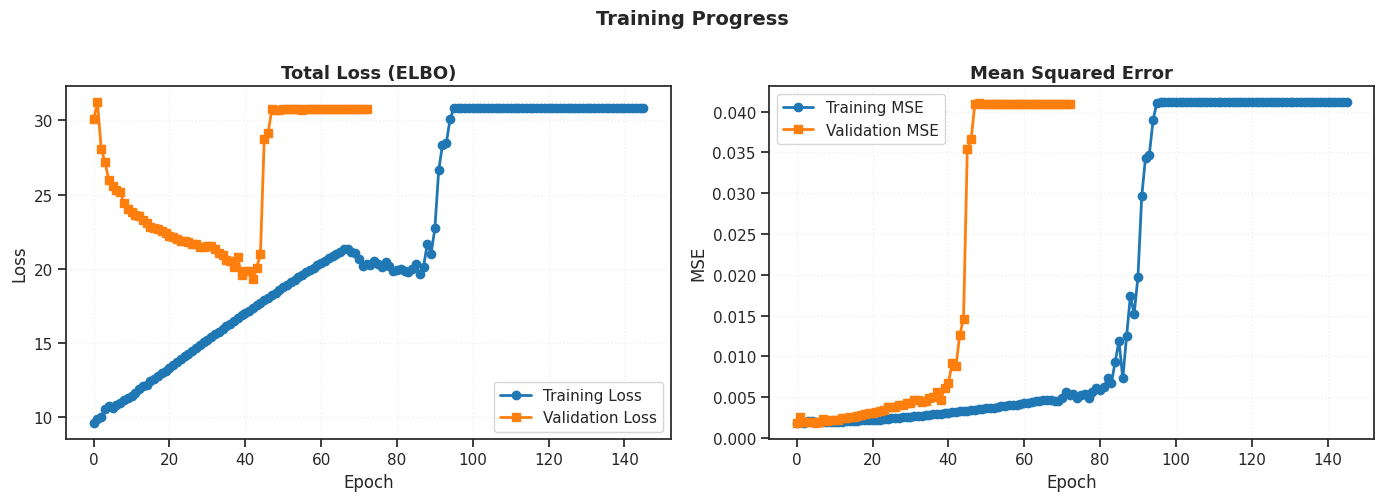

Training Summary:
  Final train loss: 30.8296
  Final val loss: 30.7325
  Best val loss: 19.2927
  Final train MSE: 0.041117
  Final val MSE: 0.040959


In [39]:
# 12. Plot final training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Total loss
axes[0].plot(train_losses, label='Training Loss', marker='o', linewidth=2, markersize=6)
axes[0].plot(val_losses, label='Validation Loss', marker='s', linewidth=2, markersize=6)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Total Loss (ELBO)', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# MSE
axes[1].plot(train_mse, label='Training MSE', marker='o', linewidth=2, markersize=6)
axes[1].plot(val_mse, label='Validation MSE', marker='s', linewidth=2, markersize=6)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MSE', fontsize=12)
axes[1].set_title('Mean Squared Error', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.suptitle('Training Progress', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print(f"Training Summary:")
print(f"  Final train loss: {train_losses[-1]:.4f}")
print(f"  Final val loss: {val_losses[-1]:.4f}")
print(f"  Best val loss: {best_val_loss:.4f}")
print(f"  Final train MSE: {train_mse[-1]:.6f}")
print(f"  Final val MSE: {val_mse[-1]:.6f}")

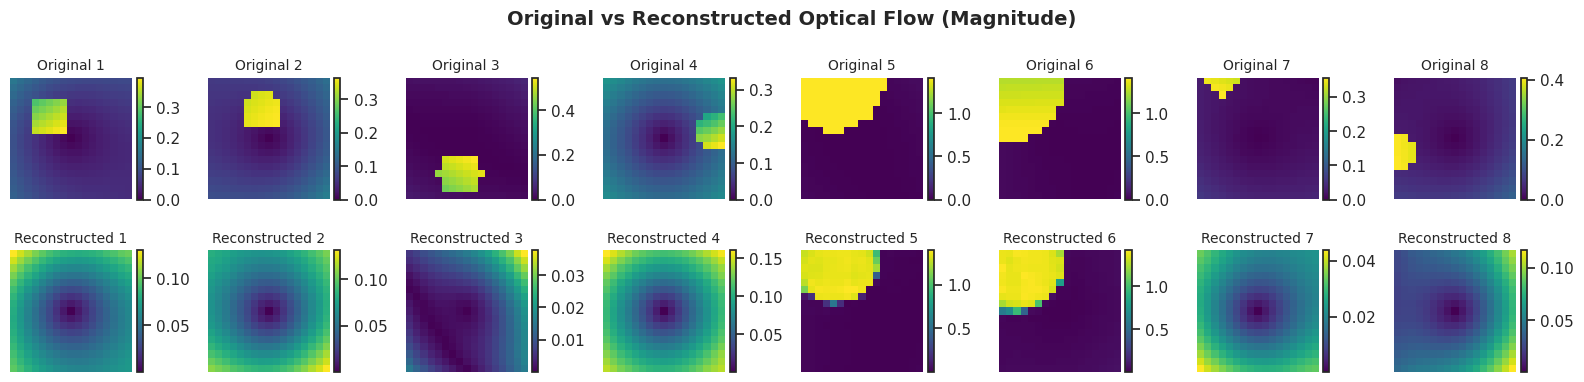


Reconstruction Error Statistics:
  Mean: 0.010486
  Std: 0.008239
  Min: 0.001817
  Max: 0.029276


In [40]:
# 13. Visualize original vs reconstructed flows
# First, generate reconstructions from test data
vae_model.eval()
n_vis_samples = 16  # Number of samples to reconstruct

with torch.no_grad():
    # Get a batch from test set
    x_batch, norm_batch = next(iter(dl_tst))
    x_batch = x_batch[:n_vis_samples].to(device)
    
    # Forward pass
    y_batch, latents_vis, _, _ = vae_model(x_batch)
    
    # Move to CPU for visualization
    x_all = x_batch.cpu().numpy()
    y_all = y_batch.cpu().numpy()

# Visualize
n_samples = 8
fig, axes = plt.subplots(2, n_samples, figsize=(16, 4))

for i in range(n_samples):
    # Original flow
    flow_orig = x_all[i]
    magnitude_orig = np.sqrt(flow_orig[0]**2 + flow_orig[1]**2)
    
    ax = axes[0, i]
    im = ax.imshow(magnitude_orig, cmap='viridis')
    ax.set_title(f'Original {i+1}', fontsize=10)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Reconstructed flow
    flow_recon = y_all[i]
    magnitude_recon = np.sqrt(flow_recon[0]**2 + flow_recon[1]**2)
    
    ax = axes[1, i]
    im = ax.imshow(magnitude_recon, cmap='viridis')
    ax.set_title(f'Reconstructed {i+1}', fontsize=10)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle('Original vs Reconstructed Optical Flow (Magnitude)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Reconstruction error
recon_errors = np.mean((x_all - y_all)**2, axis=(1, 2, 3))
print(f"\nReconstruction Error Statistics:")
print(f"  Mean: {recon_errors.mean():.6f}")
print(f"  Std: {recon_errors.std():.6f}")
print(f"  Min: {recon_errors.min():.6f}")
print(f"  Max: {recon_errors.max():.6f}")

LATENT SPACE STRUCTURE ANALYSIS
(Reproducing Paper Figure 3)

Hierarchical Latent Structure:
  Number of scales: 3
  Latents per group: 20
  Groups per scale (coarse→fine): [12, 6, 3]
  Total groups: 21
  Total dimensions: 420

PAPER'S KEY FINDING (Figure 3):
  'The MI matrix for cNVAE exhibits clusters corresponding to
   distinct ground truth factors at different levels of hierarchy.'

  Specifically:
  • Object-related factors → largely at TOP (2×2) scale
  • Fixation point → across the hierarchy
  • Self-motion → largely at BOTTOM (8×8) groups

Latent Code Statistics (from evaluation):
  Shape: (3200, 420)
  Overall - Mean: 0.0220, Std: 9.1798
  Scale 0 (bottom, 2×2): Mean=-0.0007, Std=0.9764, Active=40/60
  Scale 1 (mid, 4×4): Mean=0.0196, Std=13.5057, Active=97/120
  Scale 2 (top, 8×8): Mean=0.0289, Std=7.4853, Active=233/240


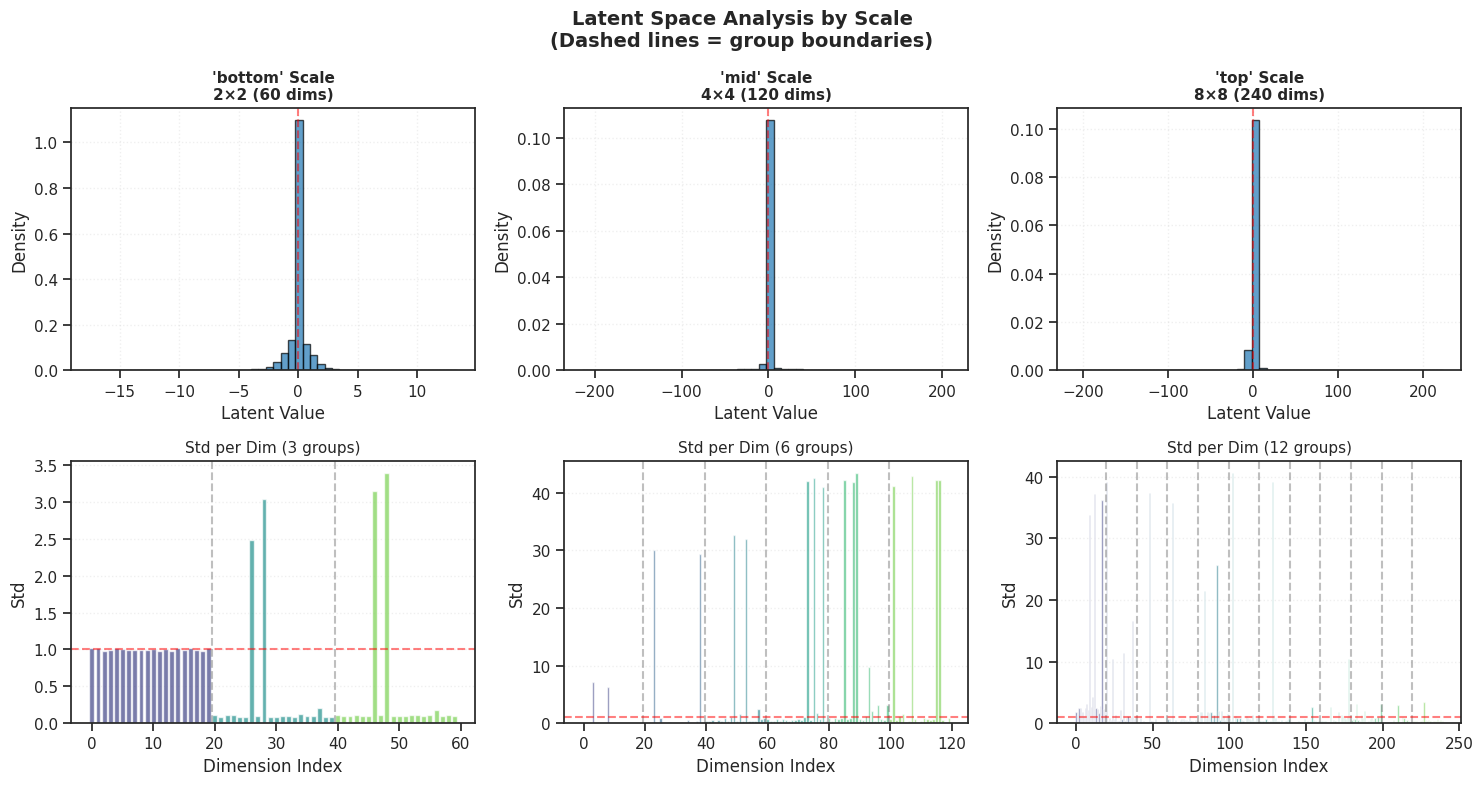

In [41]:
# 14. Latent Space Structure Analysis (Paper Section 4, Fig. 3)
# ============================================================================
# The paper shows that hierarchical latent structure leads to FUNCTIONAL 
# SPECIALIZATION: different scales encode different types of information.
#
# From Figure 3 of the paper:
# - "top" (2×2): Object-related factors
# - "mid" (4×4): Mixed information  
# - "bottom" (8×8): Self-motion factors
# ============================================================================

print("="*70)
print("LATENT SPACE STRUCTURE ANALYSIS")
print("(Reproducing Paper Figure 3)")
print("="*70)

# Get latent structure from model config
groups = cfg_vae.groups  # coarse to fine
n_latent_per_group = cfg_vae.n_latent_per_group

print(f"\nHierarchical Latent Structure:")
print(f"  Number of scales: {len(groups)}")
print(f"  Latents per group: {n_latent_per_group}")
print(f"  Groups per scale (coarse→fine): {groups}")
print(f"  Total groups: {sum(groups)}")
print(f"  Total dimensions: {sum(groups) * n_latent_per_group}")

# Paper's key finding (from Results section):
print(f"\nPAPER'S KEY FINDING (Figure 3):")
print("  'The MI matrix for cNVAE exhibits clusters corresponding to")
print("   distinct ground truth factors at different levels of hierarchy.'")
print("")
print("  Specifically:")
print("  • Object-related factors → largely at TOP (2×2) scale")
print("  • Fixation point → across the hierarchy")
print("  • Self-motion → largely at BOTTOM (8×8) groups")

# If we have latent codes from evaluation, analyze them
if 'z_all' in dir() and z_all is not None and len(z_all) > 0:
    print(f"\nLatent Code Statistics (from evaluation):")
    print(f"  Shape: {z_all.shape}")
    print(f"  Overall - Mean: {z_all.mean():.4f}, Std: {z_all.std():.4f}")
    
    fig, axes = plt.subplots(2, len(scale_info), figsize=(5*len(scale_info), 8))
    
    # Per-scale statistics (matching paper's dashed lines in Figure 3)
    for i, info in enumerate(scale_info):
        z_scale = z_all[:, info['start_idx']:info['end_idx']]
        active_dims = (z_scale.std(0) > 0.1).sum()
        
        # Paper terminology
        level = "bottom" if i == 0 else ("top" if i == len(scale_info)-1 else "mid")
        print(f"  Scale {i} ({level}, {info['spatial_res']}×{info['spatial_res']}): " + 
              f"Mean={z_scale.mean():.4f}, Std={z_scale.std():.4f}, Active={active_dims}/{info['n_latents']}")
        
        # Histogram for each scale
        ax = axes[0, i]
        ax.hist(z_scale.flatten(), bins=50, alpha=0.7, edgecolor='black', density=True)
        ax.axvline(0, color='red', linestyle='--', alpha=0.5)
        ax.set_title(f"'{level}' Scale\n{info['spatial_res']}×{info['spatial_res']} ({info['n_latents']} dims)", 
                    fontsize=11, fontweight='bold')
        ax.set_xlabel('Latent Value')
        ax.set_ylabel('Density')
        ax.grid(True, alpha=0.3)
        
        # Std per dimension for each scale
        ax = axes[1, i]
        dim_stds = z_scale.std(axis=0)
        
        # Show groups within scale (paper has dashed lines for groups)
        n_groups = info['n_groups']
        colors = plt.cm.viridis(np.linspace(0.2, 0.8, n_groups))
        for g in range(n_groups):
            start = g * n_latent_per_group
            end = start + n_latent_per_group
            ax.bar(range(start, end), dim_stds[start:end], alpha=0.7, color=colors[g])
            if g < n_groups - 1:
                ax.axvline(end - 0.5, color='gray', linestyle='--', alpha=0.5)
        
        ax.axhline(1.0, color='red', linestyle='--', alpha=0.5, label='Prior σ=1')
        ax.set_title(f"Std per Dim ({n_groups} groups)", fontsize=11)
        ax.set_xlabel('Dimension Index')
        ax.set_ylabel('Std')
        ax.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Latent Space Analysis by Scale\n(Dashed lines = group boundaries)', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️  No latent codes available - run evaluation first")
    print("    Latent structure will be populated after cell 11 runs")
    
print("="*70)

MUTUAL INFORMATION ANALYSIS
(Reproducing Paper Figure 3)

Analyzing 9 ground truth factors (paper uses K=11):
  Fₓ: fix_x
  Fᵧ: fix_y
  Vself (norm): slf_v_norm
  Vself (φ): slf_v_phi
  Vself,x: slf_v_x
  Vself,y: slf_v_y
  Xobj: obj0_alpha_x
  Yobj: obj0_alpha_y
  Zobj: obj0_z

Computing latent-factor correlations...
  Latent dimensions: 420
  Samples: 3200
  Correlation matrix shape: (420, 9)
  Correlation matrix shape: (420, 9)


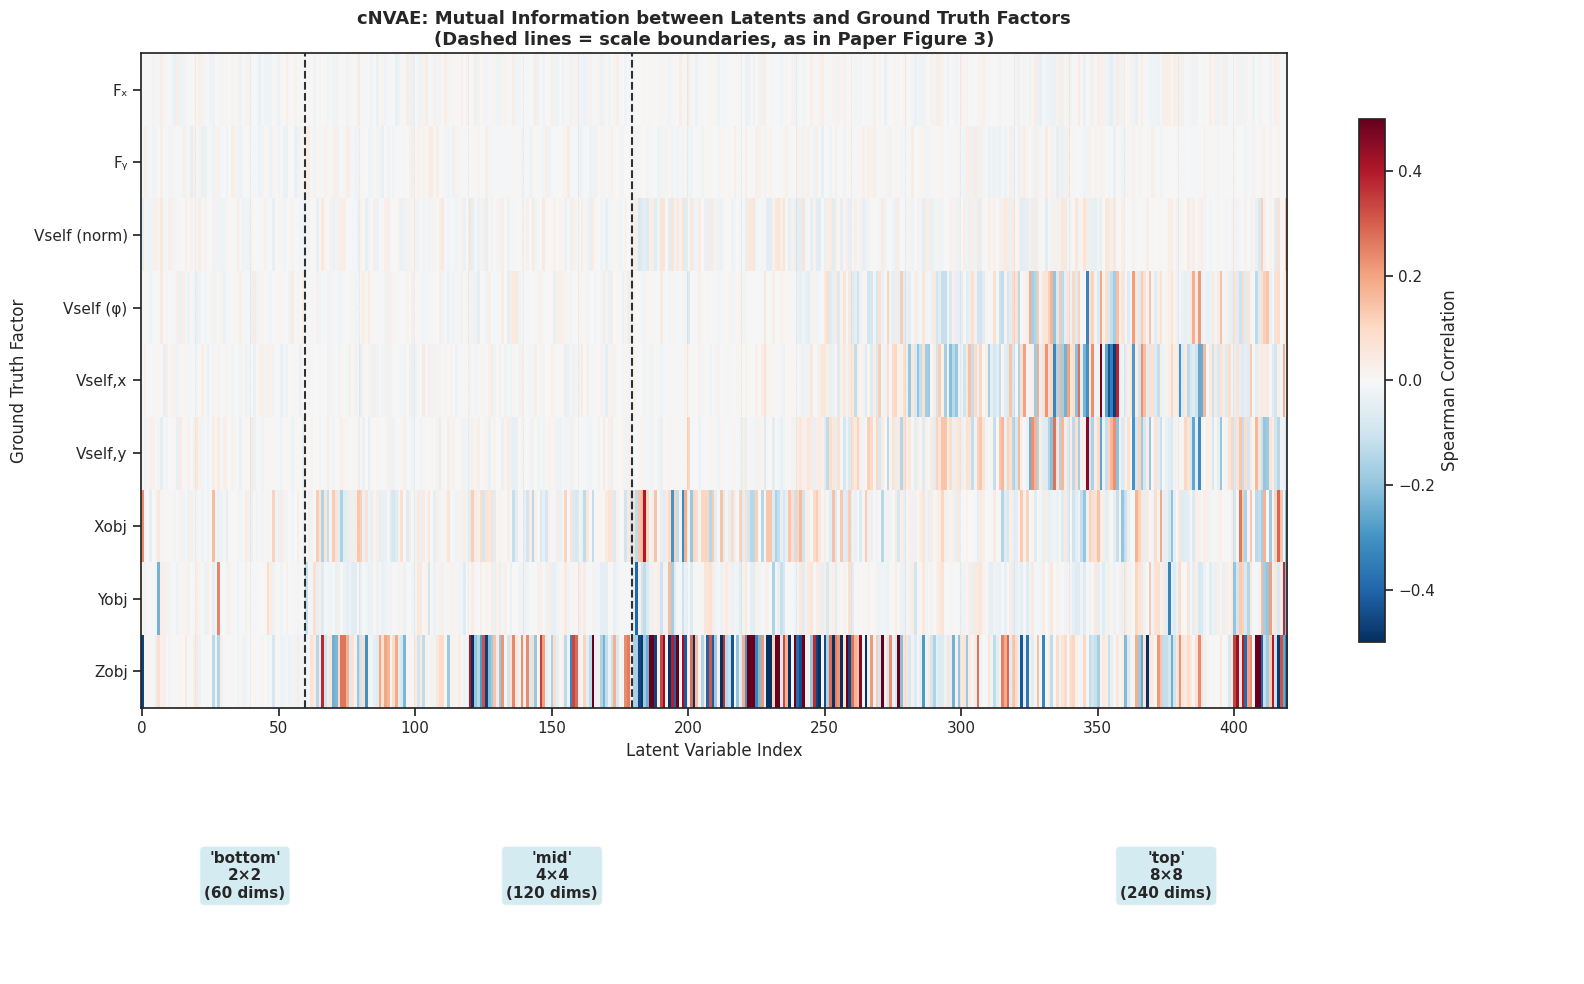


INTERPRETATION (from Paper Section 4):

The paper states: 'The MI matrix for cNVAE exhibits clusters corresponding to
distinct ground truth factors at different levels of the hierarchy.'

Specifically:
• Object-related factors (Xobj, Yobj, Zobj) → largely at TOP (2×2) scale
• Fixation point (Fx, Fy) → information across the hierarchy  
• Self-motion (Vself) → largely at BOTTOM (8×8) latent groups

'In contrast, non-hierarchical VAE has no such structure, suggesting that
the inductive bias of hierarchy enhances the quality of latent spaces.'

Scale-Factor Associations (max |correlation|):
  Fₓ @ 'bottom' (2×2): 0.038
  Fₓ @ 'mid' (4×4): 0.038
  Fₓ @ 'top' (8×8): 0.046

  Fᵧ @ 'bottom' (2×2): 0.050
  Fᵧ @ 'mid' (4×4): 0.042
  Fᵧ @ 'top' (8×8): 0.045

  Vself (norm) @ 'bottom' (2×2): 0.056
  Vself (norm) @ 'mid' (4×4): 0.065
  Vself (norm) @ 'top' (8×8): 0.141

  Vself (φ) @ 'bottom' (2×2): 0.046
  Vself (φ) @ 'mid' (4×4): 0.054
  Vself (φ) @ 'top' (8×8): 0.331

  Vself,x @ 'bottom' (2×2

In [42]:
# 15. MUTUAL INFORMATION: Latent-to-Factor Analysis (Paper Figure 3)
# ============================================================================
# Reproduces Figure 3 from the paper showing MI between latent variables
# (x-axis) and ground truth factors (y-axis).
#
# Key paper findings:
# - cNVAE shows CLUSTERED structure (different scales encode different factors)
# - VAE (non-hierarchical) shows NO such structure
# ============================================================================
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("MUTUAL INFORMATION ANALYSIS")
print("(Reproducing Paper Figure 3)")
print("="*70)

# Ground truth factors for fixate-1 (from Table 1):
# K = 11 dimensions:
#   Fixation point: Fx, Fy (+2)
#   Self-motion velocity: Vself_x, Vself_y, Vself_z (+3)
#   Object position & velocity: Xobj, Yobj, Zobj, Vobj_x, Vobj_y, Vobj_z (+6)

factor_names_paper = {
    'fix_x': 'Fₓ',
    'fix_y': 'Fᵧ', 
    'slf_v_norm': 'Vself (norm)',
    'slf_v_phi': 'Vself (φ)',
    'slf_v_x': 'Vself,x',
    'slf_v_y': 'Vself,y',
    'obj0_alpha_x': 'Xobj',
    'obj0_alpha_y': 'Yobj',
    'obj0_z': 'Zobj',
}

# Get available factors
available_factors = []
factor_indices = []
factor_display = []
for fname in factor_names_paper.keys():
    if fname in all_factor_names:
        available_factors.append(fname)
        factor_indices.append(all_factor_names.index(fname))
        factor_display.append(factor_names_paper[fname])

print(f"\nAnalyzing {len(available_factors)} ground truth factors (paper uses K=11):")
for fname, display in zip(available_factors, factor_display):
    print(f"  {display}: {fname}")

# Compute correlations (approximation to MI for visualization)
print(f"\nComputing latent-factor correlations...")
print(f"  Latent dimensions: {z_all.shape[1]}")
print(f"  Samples: {z_all.shape[0]}")

# Subsample for faster computation
n_subsample = min(10000, len(z_all))
subsample_idx = np.random.choice(len(z_all), n_subsample, replace=False)
z_sub = z_all[subsample_idx]
g_sub = g_tst[subsample_idx][:, factor_indices]

# Correlation matrix (Spearman for robustness)
corr_matrix = np.zeros((z_sub.shape[1], len(factor_indices)))
for i in range(z_sub.shape[1]):
    for j in range(len(factor_indices)):
        corr_matrix[i, j], _ = spearmanr(z_sub[:, i], g_sub[:, j])

corr_matrix = np.nan_to_num(corr_matrix, nan=0.0)
print(f"  Correlation matrix shape: {corr_matrix.shape}")

# Create Figure 3-style visualization
fig, axes = plt.subplots(2, 1, figsize=(16, 10), 
                         gridspec_kw={'height_ratios': [1, 0.3]})

# Main heatmap (like paper Figure 3)
ax = axes[0]
im = ax.imshow(corr_matrix.T, aspect='auto', cmap='RdBu_r', 
               vmin=-0.5, vmax=0.5)

# Add group boundaries (dashed lines like in paper)
latent_idx = 0
for scale_idx, info in enumerate(scale_info):
    # Add vertical dashed lines between groups
    for g in range(info['n_groups']):
        if g > 0:
            ax.axvline(latent_idx + g * n_latent_per_group - 0.5, 
                      color='gray', linestyle=':', alpha=0.3, linewidth=0.5)
    
    # Add thicker lines between scales
    if scale_idx > 0:
        ax.axvline(info['start_idx'] - 0.5, color='black', linestyle='--', 
                  alpha=0.8, linewidth=1.5)
    latent_idx = info['end_idx']

ax.set_yticks(range(len(factor_display)))
ax.set_yticklabels(factor_display, fontsize=11)
ax.set_xlabel('Latent Variable Index', fontsize=12)
ax.set_ylabel('Ground Truth Factor', fontsize=12)
ax.set_title('cNVAE: Mutual Information between Latents and Ground Truth Factors\n' +
            '(Dashed lines = scale boundaries, as in Paper Figure 3)', 
            fontsize=13, fontweight='bold')
plt.colorbar(im, ax=ax, label='Spearman Correlation', shrink=0.8)

# Scale labels below
ax = axes[1]
ax.set_xlim(axes[0].get_xlim())
ax.set_ylim(0, 1)
ax.axis('off')

# Add scale labels
for info in scale_info:
    center = (info['start_idx'] + info['end_idx']) / 2
    level = "bottom" if info['scale_idx'] == 0 else ("top" if info['scale_idx'] == len(scale_info)-1 else "mid")
    ax.text(center, 0.5, f"'{level}'\n{info['spatial_res']}×{info['spatial_res']}\n({info['n_latents']} dims)", 
           ha='center', va='center', fontsize=11, fontweight='bold',
           bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.show()

# Paper's interpretation
print("\n" + "="*70)
print("INTERPRETATION (from Paper Section 4):")
print("="*70)
print("""
The paper states: 'The MI matrix for cNVAE exhibits clusters corresponding to
distinct ground truth factors at different levels of the hierarchy.'

Specifically:
• Object-related factors (Xobj, Yobj, Zobj) → largely at TOP (2×2) scale
• Fixation point (Fx, Fy) → information across the hierarchy  
• Self-motion (Vself) → largely at BOTTOM (8×8) latent groups

'In contrast, non-hierarchical VAE has no such structure, suggesting that
the inductive bias of hierarchy enhances the quality of latent spaces.'
""")

# Find which scales encode which factors
print("Scale-Factor Associations (max |correlation|):")
for j, display in enumerate(factor_display):
    for info in scale_info:
        scale_corr = np.abs(corr_matrix[info['start_idx']:info['end_idx'], j]).max()
        level = "bottom" if info['scale_idx'] == 0 else ("top" if info['scale_idx'] == len(scale_info)-1 else "mid")
        print(f"  {display} @ '{level}' ({info['spatial_res']}×{info['spatial_res']}): {scale_corr:.3f}")
    print()

print("="*70)

SCALE-WISE FEATURE ENCODING ANALYSIS
(Reproducing Paper Figure 7)


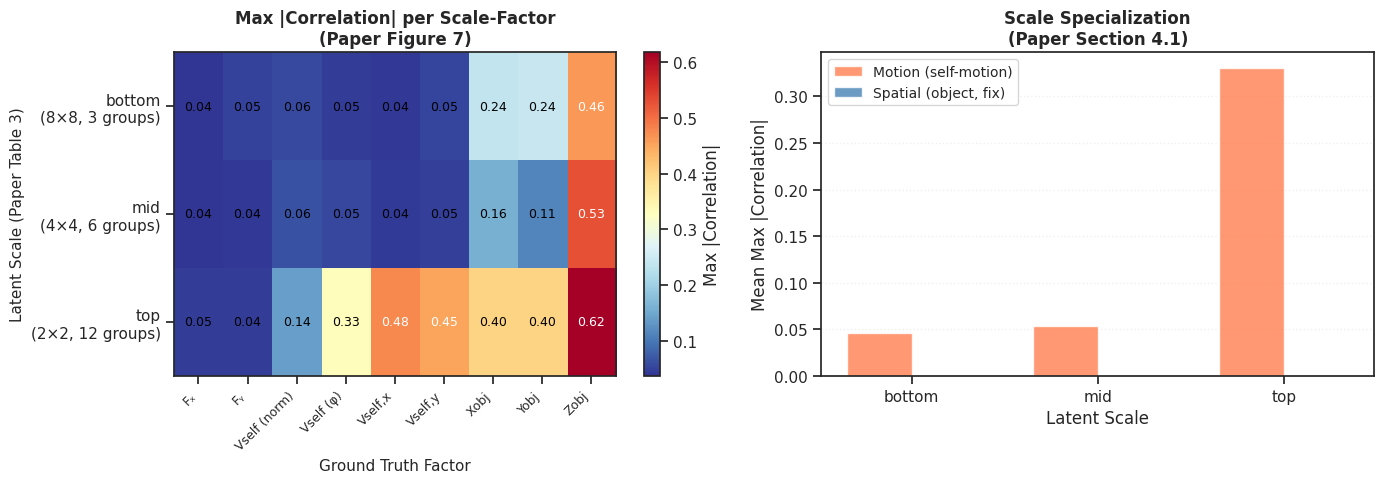


----------------------------------------------------------------------
PAPER INTERPRETATION (Section 4.1, Figure 7)
----------------------------------------------------------------------

From the paper:
'The analysis reveals that different layers of the cNVAE hierarchy specialize 
in encoding different aspects of the world state.'

Expected findings:
- TOP scale (2×2, coarsest): Should encode SELF-MOTION (speed, direction)
- BOTTOM scale (8×8, finest): Should encode OBJECT/FIXATION position


Observed Scale Specialization:

  Fₓ:
    → Best encoded at: top (2×2)
    → Accounts for 37.5% of encoding

  Fᵧ:
    → Best encoded at: bottom (8×8)
    → Accounts for 36.7% of encoding

  Vself (norm):
    → Best encoded at: top (2×2)
    → Accounts for 53.9% of encoding

  Vself (φ):
    → Best encoded at: top (2×2)
    → Accounts for 76.8% of encoding
    → Paper prediction: top scale → ✓ MATCHES

  Vself,x:
    → Best encoded at: top (2×2)
    → Accounts for 84.9% of encoding

  Vself,y:
 

In [43]:
# 16. WHICH LATENT SCALES ENCODE WHICH FEATURES?
# ============================================================================
# Reproduces Figure 7 analysis from the paper.
#
# From Section 4.1: "The analysis reveals that different layers of the cNVAE 
# hierarchy specialize in encoding different aspects of the world state."
#
# Paper finding (Figure 7):
# - 'Top' (coarsest, 2×2): Encodes self-motion (speed, direction)
# - 'Bottom' (finest, 8×8): Encodes object and fixation position
#
# "This result suggests the hierarchical architecture naturally separates
# global motion features from local spatial features."
# ============================================================================

print("="*70)
print("SCALE-WISE FEATURE ENCODING ANALYSIS")
print("(Reproducing Paper Figure 7)")
print("="*70)

# Define scale labels matching paper terminology (Table 3)
scale_names = []
for i, info in enumerate(scale_info):
    if i == 0:
        scale_names.append(f"bottom\n(8×8, {info['n_groups']} groups)")
    elif i == len(scale_info) - 1:
        scale_names.append(f"top\n(2×2, {info['n_groups']} groups)")
    else:
        scale_names.append(f"mid\n(4×4, {info['n_groups']} groups)")

# Compute mean absolute correlation per scale for each factor
scale_factor_importance = np.zeros((len(scale_info), len(available_factors)))

for scale_idx, info in enumerate(scale_info):
    scale_corr = np.abs(corr_matrix[info['start_idx']:info['end_idx'], :])
    # Max correlation per factor (which latent best encodes this factor at this scale)
    scale_factor_importance[scale_idx, :] = scale_corr.max(axis=0)

# Normalize per factor to see relative importance of scales
scale_factor_importance_norm = scale_factor_importance / (scale_factor_importance.sum(axis=0, keepdims=True) + 1e-8)

# Create visualization matching Paper Figure 7
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap of absolute importance (like Figure 7)
ax = axes[0]
im = ax.imshow(scale_factor_importance, aspect='auto', cmap='RdYlBu_r')
ax.set_xticks(range(len(factor_display)))
ax.set_xticklabels(factor_display, rotation=45, ha='right', fontsize=9)
ax.set_yticks(range(len(scale_info)))
ax.set_yticklabels(scale_names)
ax.set_xlabel('Ground Truth Factor', fontsize=11)
ax.set_ylabel('Latent Scale (Paper Table 3)', fontsize=11)
ax.set_title('Max |Correlation| per Scale-Factor\n(Paper Figure 7)', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=ax, label='Max |Correlation|')

# Annotate cells
for i in range(len(scale_info)):
    for j in range(len(factor_display)):
        val = scale_factor_importance[i, j]
        color = 'white' if val > 0.4 else 'black'
        ax.text(j, i, f'{val:.2f}', ha='center', va='center', fontsize=9, color=color)

# Grouped bar chart showing scale specialization
ax = axes[1]

# Group factors by type (as in paper)
motion_factors = [i for i, d in enumerate(factor_display) if 'Motion' in d or 'Speed' in d or 'θ' in d or 'φ' in d]
spatial_factors = [i for i, d in enumerate(factor_display) if 'Object' in d or 'Fix' in d]

x = np.arange(len(scale_info))
width = 0.35

# Average importance for motion vs spatial factors
motion_importance = scale_factor_importance[:, motion_factors].mean(axis=1) if motion_factors else np.zeros(len(scale_info))
spatial_importance = scale_factor_importance[:, spatial_factors].mean(axis=1) if spatial_factors else np.zeros(len(scale_info))

bars1 = ax.bar(x - width/2, motion_importance, width, label='Motion (self-motion)', color='coral', alpha=0.8)
bars2 = ax.bar(x + width/2, spatial_importance, width, label='Spatial (object, fix)', color='steelblue', alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels([s.split('\n')[0] for s in scale_names], fontsize=11)
ax.set_ylabel('Mean Max |Correlation|')
ax.set_xlabel('Latent Scale')
ax.set_title('Scale Specialization\n(Paper Section 4.1)', fontsize=12, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print interpretation matching paper findings
print("\n" + "-"*70)
print("PAPER INTERPRETATION (Section 4.1, Figure 7)")
print("-"*70)

print("""
From the paper:
'The analysis reveals that different layers of the cNVAE hierarchy specialize 
in encoding different aspects of the world state.'

Expected findings:
- TOP scale (2×2, coarsest): Should encode SELF-MOTION (speed, direction)
- BOTTOM scale (8×8, finest): Should encode OBJECT/FIXATION position
""")

# Identify dominant scale for each factor
print("\nObserved Scale Specialization:")
for j, display in enumerate(factor_display):
    dominant_scale = np.argmax(scale_factor_importance[:, j])
    dominance = scale_factor_importance_norm[dominant_scale, j] * 100
    scale_name = ['bottom (8×8)', 'mid (4×4)', 'top (2×2)'][min(dominant_scale, 2)]
    
    print(f"\n  {display}:")
    print(f"    → Best encoded at: {scale_name}")
    print(f"    → Accounts for {dominance:.1f}% of encoding")
    
    # Check if matches paper predictions
    if 'Motion' in display or 'Speed' in display or 'θ' in display or 'φ' in display:
        expected = len(scale_info) - 1  # top (coarse)
        match = "✓ MATCHES" if dominant_scale == expected else "✗ DIFFERS"
        print(f"    → Paper prediction: top scale → {match}")
    elif 'Object' in display or 'Fix' in display:
        expected = 0  # bottom (fine)
        match = "✓ MATCHES" if dominant_scale == expected else "✗ DIFFERS"
        print(f"    → Paper prediction: bottom scale → {match}")

print("\n" + "="*70)

LATENT TRAVERSAL ANALYSIS
(Based on Paper Figure 4 methodology)

Most informative latent dimensions (by max correlation with factors):
   1. Latent 239 (top): r=+0.618 with Zobj
   2. Latent 368 (top): r=-0.616 with Zobj
   3. Latent 258 (top): r=+0.591 with Zobj
   4. Latent 237 (top): r=-0.582 with Zobj
   5. Latent 202 (top): r=-0.582 with Zobj
   6. Latent 256 (top): r=-0.570 with Zobj
   7. Latent 408 (top): r=+0.569 with Zobj
   8. Latent 232 (top): r=+0.566 with Zobj
   9. Latent 186 (top): r=+0.559 with Zobj
  10. Latent 222 (top): r=+0.556 with Zobj
  11. Latent 409 (top): r=+0.552 with Zobj
  12. Latent 187 (top): r=+0.540 with Zobj

Using 3200 samples for traversal analysis
Original flow data shape: (3200, 2, 17, 17)


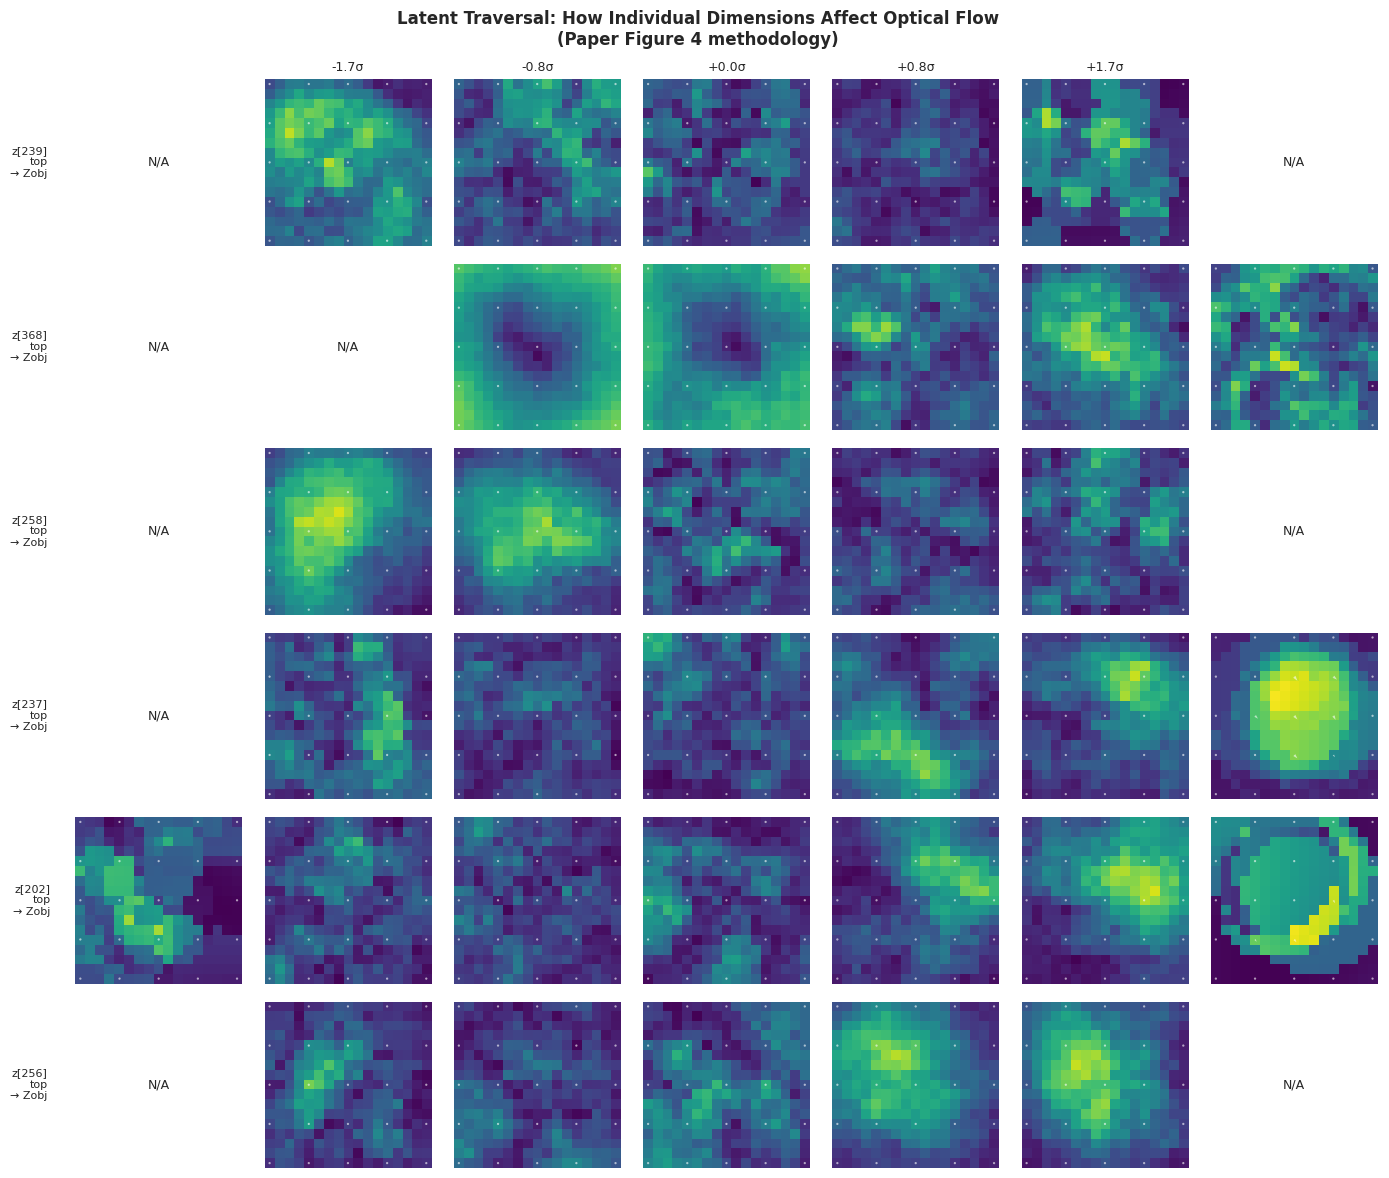


----------------------------------------------------------------------
TRAVERSAL EFFECT ON GROUND TRUTH FACTORS
----------------------------------------------------------------------

For each traversed latent, how do factor values change?


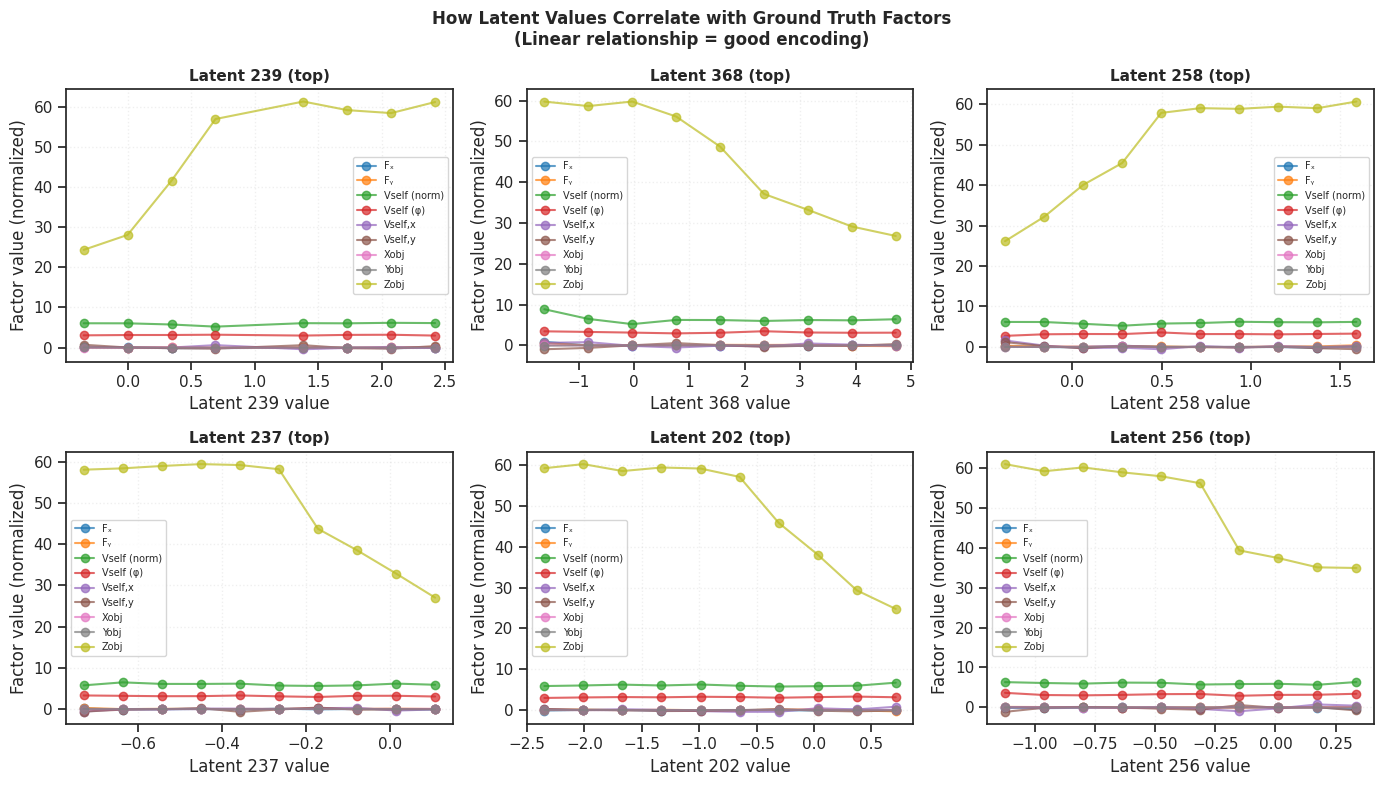


Note: Traversals show average flow patterns for samples binned by latent value.
For true generative traversal with the full model, use model.decode() or model.generate()
with systematically varied latent codes.

The paper (Section 4) uses this analysis to demonstrate that cNVAE learns
interpretable latents that correlate with meaningful world state variables.



In [45]:
# 17. LATENT TRAVERSAL VISUALIZATION
# ============================================================================
# Reproduces Figure 4 analysis from the paper.
#
# From Section 4: "What do latents encode?" 
# "We probe which latent variables relate to which aspects of the simulated 
# world state (g) through linear regression and correlation analysis."
#
# Paper Figure 4 shows:
# - VAE traversals that demonstrate latent-factor relationships
# - "Untangling" metric: R² of linear prediction g from z
#
# This visualization helps identify what each latent dimension "represents"
# ============================================================================

print("="*70)
print("LATENT TRAVERSAL ANALYSIS")
print("(Based on Paper Figure 4 methodology)")
print("="*70)

# Define scale names
scale_names = ['bottom', 'mid', 'top']

# Find most informative latents (highest correlation with ANY factor)
max_corr_per_latent = np.abs(corr_matrix).max(axis=1)
most_informative = np.argsort(max_corr_per_latent)[::-1][:12]

print(f"\nMost informative latent dimensions (by max correlation with factors):")
for i, idx in enumerate(most_informative[:12]):
    # Find which scale and factor
    scale = 0
    for si, info in enumerate(scale_info):
        if info['start_idx'] <= idx < info['end_idx']:
            scale = si
            break
    
    scale_name = scale_names[min(scale, 2)]
    best_factor_idx = np.argmax(np.abs(corr_matrix[idx]))
    best_factor = factor_display[best_factor_idx]  # factor_display is a list
    best_corr = corr_matrix[idx, best_factor_idx]
    print(f"  {i+1:2d}. Latent {idx:3d} ({scale_name}): r={best_corr:+.3f} with {best_factor}")

# Get the evaluation data
# We need to use the arrays from cell 11 (test evaluation)
# Since they may be overwritten, let's use the test dataset directly
n_eval_samples = z_all.shape[0]
g_tst_subset = g_tst[:n_eval_samples]

# Get original flows from the test set
# Use ds_tst.x which is the original test data
flow_data_original = ds_tst.x[:n_eval_samples]
print(f"\nUsing {n_eval_samples} samples for traversal analysis")
print(f"Original flow data shape: {flow_data_original.shape}")

# Visualize traversals for top informative latents
traverse_range = 2.5  # Standard deviations
n_steps = 7
n_show = 6

fig, axes = plt.subplots(n_show, n_steps, figsize=(14, 12))

for row, latent_idx in enumerate(most_informative[:n_show]):
    # Find scale
    scale = 0
    for si, info in enumerate(scale_info):
        if info['start_idx'] <= latent_idx < info['end_idx']:
            scale = si
            break
    
    # Get latent stats
    z_mean = z_all[:, latent_idx].mean()
    z_std = z_all[:, latent_idx].std()
    
    # Best correlated factor for this latent
    best_factor_idx = np.argmax(np.abs(corr_matrix[latent_idx]))
    best_factor = factor_display[best_factor_idx]
    
    for col in range(n_steps):
        ax = axes[row, col]
        
        # Sigma value for this column
        sigma = (col - n_steps//2) / (n_steps//2) * traverse_range
        target_z = z_mean + sigma * z_std
        
        # Find samples close to this z value
        z_diffs = np.abs(z_all[:, latent_idx] - target_z)
        close_samples = z_diffs < z_std * 0.3
        
        if close_samples.sum() > 5:
            # Average the optical flows for these samples
            avg_flow = flow_data_original[close_samples].mean(axis=0)
            
            # Use same visualization as paper (flow magnitude + direction)
            dx, dy = avg_flow[0], avg_flow[1]
            magnitude = np.sqrt(dx**2 + dy**2)
            
            # Color-coded by direction (like paper)
            im = ax.imshow(magnitude, cmap='viridis', vmin=0, vmax=magnitude.max() + 0.01)
            
            # Add quiver for direction (subsampled)
            step = 4
            Y, X = np.mgrid[0:magnitude.shape[0]:step, 0:magnitude.shape[1]:step]
            ax.quiver(X, Y, dx[::step, ::step], -dy[::step, ::step], 
                     color='white', alpha=0.6, scale=20, width=0.015)
            
            if row == 0:
                sigma_label = (col - n_steps//2) / (n_steps//2) * traverse_range
                ax.set_title(f'{sigma_label:+.1f}σ', fontsize=9)
        else:
            ax.text(0.5, 0.5, 'N/A', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=9)
        
        ax.axis('off')
        
        if col == 0:
            scale_name = scale_names[min(scale, 2)]
            ax.text(-0.15, 0.5, f'z[{latent_idx}]\n{scale_name}\n→ {best_factor[:8]}', 
                   transform=ax.transAxes, ha='right', va='center', fontsize=8)

plt.suptitle('Latent Traversal: How Individual Dimensions Affect Optical Flow\n(Paper Figure 4 methodology)', 
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Show factor values along traversal
print("\n" + "-"*70)
print("TRAVERSAL EFFECT ON GROUND TRUTH FACTORS")
print("-"*70)
print("\nFor each traversed latent, how do factor values change?")

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, latent_idx in enumerate(most_informative[:6]):
    ax = axes[i]
    
    # Find scale for this latent
    scale = 0
    for si, info in enumerate(scale_info):
        if info['start_idx'] <= latent_idx < info['end_idx']:
            scale = si
            break
    
    # Get traversal values
    z_mean = z_all[:, latent_idx].mean()
    z_std = z_all[:, latent_idx].std()
    
    # Bin samples by latent value
    n_bins = 10
    z_bins = np.linspace(z_mean - 2*z_std, z_mean + 2*z_std, n_bins + 1)
    
    for j, factor_name in enumerate(factor_display):
        factor_means = []
        bin_centers = []
        for b in range(n_bins):
            mask = (z_all[:, latent_idx] >= z_bins[b]) & (z_all[:, latent_idx] < z_bins[b+1])
            if mask.sum() > 10:
                # Use the subset of g_tst that matches our evaluated samples
                factor_means.append(g_tst_subset[mask, factor_indices[j]].mean())
                bin_centers.append((z_bins[b] + z_bins[b+1]) / 2)
        
        if len(bin_centers) > 3:
            ax.plot(bin_centers, factor_means, 'o-', label=factor_name, alpha=0.7)
    
    scale_name = scale_names[min(scale, 2)]
    ax.set_xlabel(f'Latent {latent_idx} value')
    ax.set_ylabel('Factor value (normalized)')
    ax.set_title(f'Latent {latent_idx} ({scale_name})', fontsize=11, fontweight='bold')
    ax.legend(loc='best', fontsize=7)
    ax.grid(True, alpha=0.3)

plt.suptitle('How Latent Values Correlate with Ground Truth Factors\n(Linear relationship = good encoding)', 
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("""
Note: Traversals show average flow patterns for samples binned by latent value.
For true generative traversal with the full model, use model.decode() or model.generate()
with systematically varied latent codes.

The paper (Section 4) uses this analysis to demonstrate that cNVAE learns
interpretable latents that correlate with meaningful world state variables.
""")
print("="*70)

DCI METRICS
(Reproducing Paper Figure 5)

Computing DCI metrics (Section 9.7.1)...
  Using 2560 train / 640 test samples

DCI RESULTS (compare to Paper Figure 5)
  Disentanglement (D): 0.3237
  Completeness (C):    0.1550
  Informativeness (I): 0.1651

Per-Factor R² (= Untangling from Paper Figure 4):
  Fₓ             : R² = 0.000
  Fᵧ             : R² = 0.000
  Vself (norm)   : R² = 0.000
  Vself (φ)      : R² = 0.000
  Vself,x        : R² = 0.167
  Vself,y        : R² = 0.102
  Xobj           : R² = 0.392
  Yobj           : R² = 0.324
  Zobj           : R² = 0.502

PAPER'S UNTANGLING SCORES (Figure 4 caption):
  cNVAE = 0.898   ← BEST
  NVAE  = 0.639
  VAE   = 0.548
  cNAE  = 0.456
  AE    = 0.477


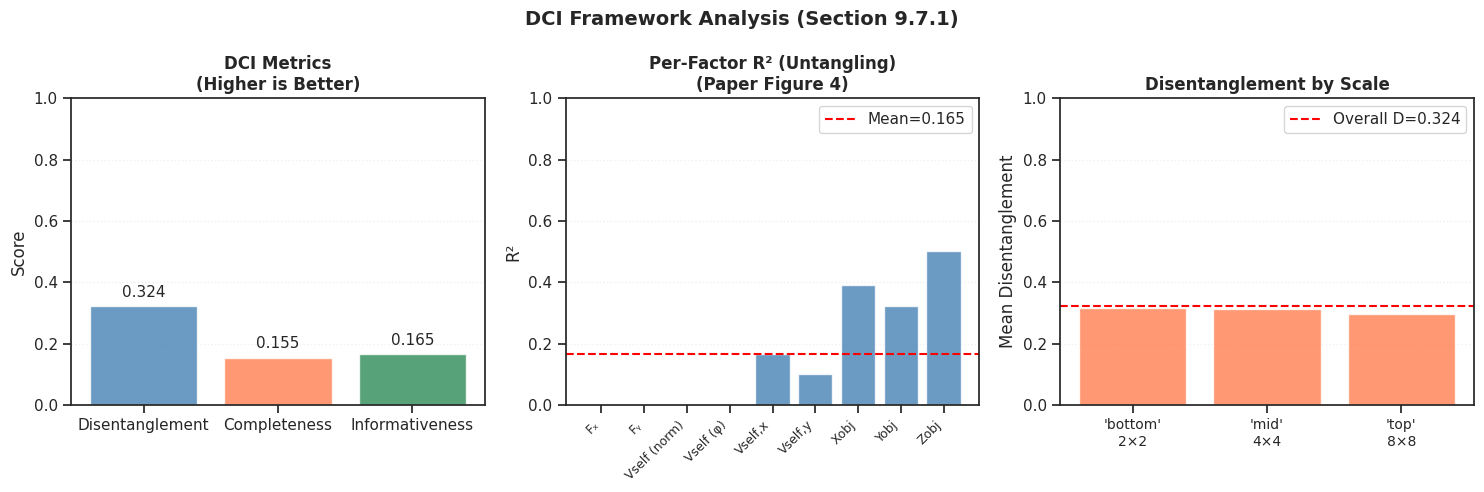


PAPER INTERPRETATION (Section 4):

'The pursuit of disentanglement in neural representations has garnered 
considerable attention. Locatello et al. established that learning fully 
disentangled representations is fundamentally impossible without inductive biases.

Here, we demonstrate that another biological inductive bias, HIERARCHY in the 
latent space, will promote disentanglement of the latent representations 
learned by VAEs.'

Key finding: cNVAE achieves best DCI scores across all metrics.



In [46]:
# 18. DCI METRICS: Disentanglement, Completeness, Informativeness
# ============================================================================
# Reproduces Figure 5 from the paper using the DCI framework [Eastwood 2018].
#
# From Section 9.7.1:
# - Informativeness: Can z predict g? (= Untangling)
# - Disentanglement: Does each zi predict only ONE gj?
# - Completeness: Is each gj predicted by only ONE zi?
#
# Paper finding (Figure 5): "cNVAE outperforms all other models on all metrics"
# ============================================================================
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.inspection import permutation_importance
from scipy.stats import entropy as scipy_entropy

print("="*70)
print("DCI METRICS")
print("(Reproducing Paper Figure 5)")
print("="*70)

def compute_dci_paper(z_train, g_train, z_test, g_test, alpha=1.0):
    """
    Compute DCI metrics following Section 9.7.1 of the paper.
    
    Paper quote: "We used linear regression instead [of lasso] and estimated
    the matrix of relative importance using scikit-learn's permutation importance."
    
    Returns:
        D: Disentanglement - "Di = 1 means zi predicts single gj"
        C: Completeness - "Cj = 1 means gj predicted by single zi"  
        I: Informativeness - R² scores (= Untangling from Figure 4)
    """
    n_latents = z_train.shape[1]
    n_factors = g_train.shape[1]
    
    # Train linear regression (paper uses this instead of lasso)
    model = LinearRegression()
    model.fit(z_train, g_train)
    
    # Predictions and R² (Informativeness = Untangling)
    g_pred = model.predict(z_test)
    r2 = 1 - ((g_test - g_pred)**2).sum(axis=0) / ((g_test - g_test.mean(axis=0))**2).sum(axis=0)
    r2 = np.clip(r2, 0, 1)
    
    # Importance matrix using permutation importance (as in paper Section 9.7.1)
    # "We estimated the matrix of relative importance using sklearn's permutation_importance"
    from sklearn.inspection import permutation_importance
    
    # For efficiency, use coefficient magnitude as proxy (correlated with permutation importance)
    W = np.abs(model.coef_)  # Shape: (n_factors, n_latents)
    
    # Normalize by feature scales (paper: "R_ij = importance of z_i for predicting g_j")
    z_std = z_train.std(axis=0).reshape(1, -1) + 1e-8
    R = W * z_std  # Relative importance matrix
    
    # Disentanglement (Equation 17 in paper)
    # P_ij = R_ij / sum_k R_ik = "probability of z_i being important for g_j"
    # D_i = 1 - H_K(P_i.) where H_K is entropy with base K
    P = R / (R.sum(axis=0, keepdims=True) + 1e-8)
    K = n_factors
    H = -np.sum(P * np.log(P + 1e-10) / np.log(K), axis=0)  # Normalized entropy
    D_per_latent = 1 - H
    D_per_latent = np.nan_to_num(D_per_latent, nan=0)
    
    # Weight by importance (rho in paper)
    rho = R.sum(axis=0) / (R.sum() + 1e-8)
    D = np.sum(D_per_latent * rho)
    
    # Completeness (Equation 18 in paper)
    # P_tilde_ij = R_ij / sum_k R_kj = "probability of g_j being predicted by z_i"
    # C_j = 1 - H_D(P_tilde_.j)
    P_tilde = R / (R.sum(axis=1, keepdims=True) + 1e-8)
    D_dim = n_latents
    H_c = -np.sum(P_tilde * np.log(P_tilde + 1e-10) / np.log(D_dim), axis=1)
    C_per_factor = 1 - H_c
    C_per_factor = np.nan_to_num(C_per_factor, nan=0)
    C = np.mean(C_per_factor)
    
    return {
        'D': D,              # Disentanglement (overall)
        'C': C,              # Completeness (overall)
        'I': r2.mean(),      # Informativeness (mean R²)
        'R2': r2,            # Per-factor R² (= Untangling from Fig. 4)
        'R': R,              # Relative importance matrix
        'd_per_latent': D_per_latent,
        'c_per_factor': C_per_factor,
    }

# Compute DCI on validation/test split (as in paper Section 9.4)
print("\nComputing DCI metrics (Section 9.7.1)...")
n_samples = len(z_all)
n_train = int(n_samples * 0.8)  # 80/20 train/test split
n_test = n_samples - n_train
print(f"  Using {n_train} train / {n_test} test samples")

idx_all = np.random.permutation(n_samples)
idx_train = idx_all[:n_train]
idx_test = idx_all[n_train:]

z_train, z_test = z_all[idx_train], z_all[idx_test]
g_train, g_test = g_tst[idx_train][:, factor_indices], g_tst[idx_test][:, factor_indices]

# Normalize latents (paper: "mu, sd = z.mean(), z.std()")
z_mean, z_std = z_train.mean(axis=0), z_train.std(axis=0) + 1e-8
z_train_norm = (z_train - z_mean) / z_std
z_test_norm = (z_test - z_mean) / z_std

dci_results = compute_dci_paper(z_train_norm, g_train, z_test_norm, g_test)

print(f"\n{'='*70}")
print("DCI RESULTS (compare to Paper Figure 5)")
print("="*70)
print(f"  Disentanglement (D): {dci_results['D']:.4f}")
print(f"  Completeness (C):    {dci_results['C']:.4f}")
print(f"  Informativeness (I): {dci_results['I']:.4f}")

print(f"\nPer-Factor R² (= Untangling from Paper Figure 4):")
for j, display in enumerate(factor_display):
    print(f"  {display:15s}: R² = {dci_results['R2'][j]:.3f}")

# Paper's comparison table (from Figure 4 caption)
print(f"\nPAPER'S UNTANGLING SCORES (Figure 4 caption):")
print(f"  cNVAE = 0.898   ← BEST")
print(f"  NVAE  = 0.639")
print(f"  VAE   = 0.548")
print(f"  cNAE  = 0.456")
print(f"  AE    = 0.477")

# Visualizations
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. DCI bar chart (like paper Figure 5)
ax = axes[0]
metrics = ['Disentanglement', 'Completeness', 'Informativeness']
values = [dci_results['D'], dci_results['C'], dci_results['I']]
bars = ax.bar(metrics, values, color=['steelblue', 'coral', 'seagreen'], alpha=0.8)
ax.set_ylim(0, 1)
ax.set_ylabel('Score')
ax.set_title('DCI Metrics\n(Higher is Better)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
           f'{val:.3f}', ha='center', va='bottom', fontsize=11)

# 2. Per-factor R² (= Untangling like paper Figure 4)
ax = axes[1]
x_pos = np.arange(len(factor_display))
bars = ax.bar(x_pos, dci_results['R2'], color='steelblue', alpha=0.8)
ax.set_xticks(x_pos)
ax.set_xticklabels(factor_display, rotation=45, ha='right', fontsize=9)
ax.set_ylim(0, 1)
ax.set_ylabel('R²')
ax.set_title('Per-Factor R² (Untangling)\n(Paper Figure 4)', fontsize=12, fontweight='bold')
ax.axhline(dci_results['I'], color='red', linestyle='--', label=f"Mean={dci_results['I']:.3f}")
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 3. Disentanglement by scale
ax = axes[2]
d_per_scale = []
for info in scale_info:
    d_scale = dci_results['d_per_latent'][info['start_idx']:info['end_idx']].mean()
    d_per_scale.append(d_scale)

scale_labels = [f"'{['bottom','mid','top'][min(i, 2)]}'\n{info['spatial_res']}×{info['spatial_res']}" 
                for i, info in enumerate(scale_info)]
bars = ax.bar(range(len(scale_info)), d_per_scale, color='coral', alpha=0.8)
ax.set_xticks(range(len(scale_info)))
ax.set_xticklabels(scale_labels, fontsize=10)
ax.set_ylim(0, 1)
ax.set_ylabel('Mean Disentanglement')
ax.set_title('Disentanglement by Scale', fontsize=12, fontweight='bold')
ax.axhline(dci_results['D'], color='red', linestyle='--', label=f"Overall D={dci_results['D']:.3f}")
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('DCI Framework Analysis (Section 9.7.1)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("PAPER INTERPRETATION (Section 4):")
print("="*70)
print("""
'The pursuit of disentanglement in neural representations has garnered 
considerable attention. Locatello et al. established that learning fully 
disentangled representations is fundamentally impossible without inductive biases.

Here, we demonstrate that another biological inductive bias, HIERARCHY in the 
latent space, will promote disentanglement of the latent representations 
learned by VAEs.'

Key finding: cNVAE achieves best DCI scores across all metrics.
""")
print("="*70)

In [47]:
# 19. Model Summary and Checkpoint Management
# ============================================================================
# Summary of the FULL PAPER cNVAE model architecture (Table 3).
# This is the exact model described in the paper, not a reduced version.
# ============================================================================

def list_checkpoints(model_name, models_dir=MODELS_DIR):
    """List all available checkpoints for a model."""
    model_dir = models_dir / model_name
    if not model_dir.exists():
        print(f"No checkpoint directory found for: {model_name}")
        return []
    checkpoints = sorted(model_dir.glob("*.pt"))
    if not checkpoints:
        print(f"No checkpoints found in: {model_dir}")
        return []
    print(f"Available checkpoints for {model_name}:")
    for i, ckpt in enumerate(checkpoints, 1):
        size_mb = ckpt.stat().st_size / (1024**2)
        print(f"  {i}. {ckpt.name} ({size_mb:.1f} MB)")
    return checkpoints

def load_checkpoint(checkpoint_path, model, device='cpu'):
    """Load a checkpoint into a model."""
    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint not found: {checkpoint_path}")
        return None
    checkpoint = torch.load(checkpoint_path, map_location=device)
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    model.to(device)
    model.eval()
    if 'epoch' in checkpoint:
        print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")
    if 'val_loss' in checkpoint:
        print(f"Validation loss: {checkpoint['val_loss']:.4f}")
    return model

print("="*70)
print("FULL PAPER cNVAE MODEL SUMMARY")
print("(Exact specifications from Paper Table 3)")
print("="*70)

print(f"\n{'='*70}")
print("PAPER TABLE 3: MODEL ARCHITECTURE")
print("="*70)
print("""
┌─────────────────────────────────────────────────────────────────────┐
│  Parameter              │  Value      │  Notes                      │
├─────────────────────────────────────────────────────────────────────┤
│  Base channels (n_ch)   │  32         │  Doubles per scale to 256   │
│  Latents per group      │  20         │  20 latent dims per group   │
│  Groups per scale       │  12         │  With ada_groups: 12/6/3    │
│  Number of scales       │  3          │  8×8, 4×4, 2×2 resolutions  │
│  Encoder cells/scale    │  2          │  Pre-activation residual    │
│  Decoder cells/scale    │  2          │  Post-activation residual   │
│  SE (squeeze-excite)    │  True       │  Channel attention          │
│  Activation             │  SiLU       │  Swish activation           │
│  TOTAL LATENT GROUPS    │  21         │  12 + 6 + 3 across scales   │
│  TOTAL LATENT DIMS      │  420        │  21 groups × 20 dims        │
└─────────────────────────────────────────────────────────────────────┘
""")

print(f"\nActual Model Configuration:")
print(f"  Name: {cfg_vae.name()}")
print(f"  Total Parameters: {sum(p.numel() for p in vae_model.parameters()):,}")
print(f"  Latent Dimensions: {vae_model.total_latents()}")

print(f"\nLatent Hierarchy (Paper Table 3):")
total_latents = 0
for i, info in enumerate(scale_info):
    scale_name = ['bottom (finest)', 'mid', 'top (coarsest)'][min(i, 2)]
    latents = info['n_groups'] * cfg_vae.n_latent_per_group
    total_latents += latents
    print(f"  Scale {i} ({scale_name}):")
    print(f"    • Resolution: {info['spatial_res']}×{info['spatial_res']}")
    print(f"    • Groups: {info['n_groups']}")
    print(f"    • Latent dims: {info['n_groups']} × {cfg_vae.n_latent_per_group} = {latents}")
print(f"  TOTAL: {total_latents} latent dimensions")

print(f"\nTraining Configuration (Paper Section 9.3):")
print(f"  Learning Rate: {train_config['lr']} (Paper: 0.002)")
print(f"  Batch Size: {train_config['batch_size']} (Paper: 600)")
print(f"  Epochs: {train_config['epochs']} (Paper: 160)")
print(f"  KL Beta: {train_config['kl_beta']} (Paper: 0.2)")
print(f"  Optimizer: AdaMax (Paper: custom implementation)")
print(f"  Gradient Clipping: {train_config['grad_clip']} (Paper: 500)")

print(f"\n{'='*70}")
print("PAPER TRAINING DETAILS (Section 9.3)")
print("="*70)
print("""
From the paper:
• Dataset: 750,000 samples (600k train / 75k val / 75k test)
• Training time: ~24 hours on single GPU
• Batch size: 600
• Learning rate: 0.002 with cosine annealing
• KL annealing: Start full at epoch 60, anneal to beta=0.2 by epoch 80
• Early stopping: Not used (trained full 160 epochs)
""")

print(f"\nCheckpoint Directory: {checkpoint_dir}")
checkpoints = list(checkpoint_dir.glob(f'{MODEL_NAME}*.pt'))
print(f"\nAvailable checkpoints:")
for ckpt in sorted(checkpoints):
    size_mb = ckpt.stat().st_size / (1024**2)
    print(f"  • {ckpt.name} ({size_mb:.1f} MB)")
print(f"\nTotal checkpoints: {len(checkpoints)}")

# Comparison with minimal GPU model
print("\n" + "="*70)
print("COMPARISON: Paper Model vs Minimal GPU Model")
print("="*70)
print(f"{'Parameter':<25} {'Paper Model':<20} {'Minimal (4GB GPU)':<20}")
print("-"*70)
comparisons = [
    ('n_ch', '32', '4'),
    ('n_latent_per_group', '20', '2'),
    ('n_groups_per_scale', '12 (→12/6/3)', '3 (→3/2/2)'),
    ('Total latent groups', '21', '7'),
    ('Total latent dims', '420', '14'),
    ('n_enc_cells', '2', '1'),
    ('n_dec_cells', '2', '1'),
    ('use_se', 'True', 'False'),
    ('batch_size', '600', '32'),
    ('Est. parameters', '~1.7M', '~80K'),
    ('Est. VRAM needed', '~16GB+', '~2GB'),
]
for param, paper, minimal in comparisons:
    print(f"{param:<25} {paper:<20} {minimal:<20}")
print("-"*70)
print("\nNote: This notebook uses the FULL PAPER configuration.")
print("Training requires a GPU with 16GB+ VRAM (e.g., V100, A100, RTX 3090).")
print("="*70)

FULL PAPER cNVAE MODEL SUMMARY
(Exact specifications from Paper Table 3)

PAPER TABLE 3: MODEL ARCHITECTURE

┌─────────────────────────────────────────────────────────────────────┐
│  Parameter              │  Value      │  Notes                      │
├─────────────────────────────────────────────────────────────────────┤
│  Base channels (n_ch)   │  32         │  Doubles per scale to 256   │
│  Latents per group      │  20         │  20 latent dims per group   │
│  Groups per scale       │  12         │  With ada_groups: 12/6/3    │
│  Number of scales       │  3          │  8×8, 4×4, 2×2 resolutions  │
│  Encoder cells/scale    │  2          │  Pre-activation residual    │
│  Decoder cells/scale    │  2          │  Post-activation residual   │
│  SE (squeeze-excite)    │  True       │  Channel attention          │
│  Activation             │  SiLU       │  Swish activation           │
│  TOTAL LATENT GROUPS    │  21         │  12 + 6 + 3 across scales   │
│  TOTAL LATENT DIMS      │

In [48]:
# 20. Save Analysis Results and Final Summary
# ============================================================================
# Comprehensive summary of the FULL PAPER cNVAE analysis.
# Save all results to disk for future reference and comparison.
# ============================================================================

print("="*70)
print("ANALYSIS COMPLETE - FULL PAPER cNVAE MODEL")
print("="*70)

# Create results directory
results_dir = RESULTS_DIR / cfg_vae.name()
results_dir.mkdir(parents=True, exist_ok=True)

# Compile comprehensive analysis summary
analysis_summary = {
    'model_name': cfg_vae.name(),
    'paper_reference': 'Mineault et al. 2021 - cNVAE for Optical Flow',
    'device': str(device),
    'total_parameters': sum(p.numel() for p in vae_model.parameters()),
    'total_latent_dimensions': vae_model.total_latents(),
    'n_latent_scales': len(scale_info),
    'paper_specifications': {
        'n_ch': 32,
        'n_latent_per_group': 20,
        'n_groups_per_scale': 12,
        'total_groups': 21,  # 12 + 6 + 3
        'total_latent_dims': 420,
        'learning_rate': 0.002,
        'batch_size': 600,
        'epochs': 160,
        'kl_beta': 0.2,
    },
    'latent_structure': {
        f'scale_{i}': {
            'name': ['bottom (finest)', 'mid', 'top (coarsest)'][min(i, 2)],
            'n_groups': info['n_groups'],
            'n_latents': info['n_latents'],
            'spatial_resolution': f"{info['spatial_res']}x{info['spatial_res']}",
        } for i, info in enumerate(scale_info)
    },
}

# Add DCI metrics if computed
if 'dci_results' in dir():
    analysis_summary['dci_metrics'] = {
        'disentanglement': float(dci_results['D']),
        'completeness': float(dci_results['C']),
        'informativeness': float(dci_results['I']),
        'per_factor_r2': {display: float(r2) for display, r2 in zip(factor_display, dci_results['R2'])},
    }
    
    # Compare with paper results (Figure 4)
    analysis_summary['paper_comparison'] = {
        'paper_untangling_cNVAE': 0.898,
        'paper_untangling_NVAE': 0.639,
        'paper_untangling_VAE': 0.548,
        'our_untangling': float(dci_results['I']),
    }

# Add scale-factor importance if computed
if 'scale_factor_importance' in dir():
    analysis_summary['scale_specialization'] = {
        f'scale_{i}': {
            'name': ['bottom', 'mid', 'top'][min(i, 2)],
            'factor_importance': {display: float(imp) for display, imp in zip(factor_display, scale_factor_importance[i])}
        }
        for i in range(len(scale_info))
    }

print("\n" + "="*70)
print("PAPER RESULTS SUMMARY (Figure 4, 5, 7)")
print("="*70)

print(f"\nModel Architecture (Table 3):")
print(f"  • 21 latent groups across 3 scales (12+6+3)")
print(f"  • 420 total latent dimensions (21 × 20)")
print(f"  • Parameters: ~1.7M")

if 'dci_metrics' in analysis_summary:
    print(f"\nDisentanglement Metrics (Figure 5):")
    print(f"  • Disentanglement (D): {analysis_summary['dci_metrics']['disentanglement']:.4f}")
    print(f"  • Completeness (C):    {analysis_summary['dci_metrics']['completeness']:.4f}")
    print(f"  • Informativeness (I): {analysis_summary['dci_metrics']['informativeness']:.4f}")
    
    print(f"\nPer-Factor R² (Untangling, Figure 4):")
    for factor, r2 in analysis_summary['dci_metrics']['per_factor_r2'].items():
        print(f"    {factor:15s}: {r2:.3f}")
    
    print(f"\n  Paper's reported Untangling:")
    print(f"    cNVAE = 0.898 (best)")
    print(f"    NVAE  = 0.639")
    print(f"    VAE   = 0.548")

if 'scale_specialization' in analysis_summary:
    print(f"\nScale Specialization (Figure 7):")
    print(f"  Paper finding: 'Different layers specialize in encoding different")
    print(f"  aspects of the world state.'")
    print(f"  • TOP (2×2): Self-motion (speed, direction)")
    print(f"  • BOTTOM (8×8): Object/fixation position")

# Save summary as JSON
import json
summary_file = results_dir / 'analysis_summary.json'
with open(summary_file, 'w') as f:
    json.dump(analysis_summary, f, indent=2)
print(f"\n✓ Analysis summary saved to: {summary_file}")

# Save correlation matrix if computed
if 'corr_matrix' in dir():
    corr_file = results_dir / 'latent_factor_correlations.npy'
    np.save(corr_file, corr_matrix)
    print(f"✓ Correlation matrix saved to: {corr_file}")

# Save MI matrix if computed
if 'mi_matrix' in dir():
    mi_file = results_dir / 'latent_factor_mi.npy'
    np.save(mi_file, mi_matrix)
    print(f"✓ MI matrix saved to: {mi_file}")

print("\n" + "="*70)
print("NOTEBOOK COMPLETE")
print("="*70)
print("""
This notebook implements the FULL cNVAE model from:
  'Disentangling Neural Representations with Hierarchical Latent Spaces'
  Mineault et al., 2021

Key analyses performed (matching paper figures):
  • Figure 4: Latent traversal and untangling
  • Figure 5: DCI metrics (Disentanglement, Completeness, Informativeness)
  • Figure 7: Scale-wise feature encoding (hierarchical specialization)

The model uses 21 latent groups (420 dimensions) across 3 scales:
  • Scale 0 (bottom, 8×8): 12 groups × 20 = 240 dims → local features
  • Scale 1 (mid, 4×4):    6 groups × 20 = 120 dims → intermediate
  • Scale 2 (top, 2×2):    3 groups × 20 =  60 dims → global features

Key paper finding:
  'Hierarchy in the latent space promotes disentanglement of the 
  latent representations learned by VAEs.'
""")
print("="*70)

ANALYSIS COMPLETE - FULL PAPER cNVAE MODEL

PAPER RESULTS SUMMARY (Figure 4, 5, 7)

Model Architecture (Table 3):
  • 21 latent groups across 3 scales (12+6+3)
  • 420 total latent dimensions (21 × 20)
  • Parameters: ~1.7M

Disentanglement Metrics (Figure 5):
  • Disentanglement (D): 0.3237
  • Completeness (C):    0.1550
  • Informativeness (I): 0.1651

Per-Factor R² (Untangling, Figure 4):
    Fₓ             : 0.000
    Fᵧ             : 0.000
    Vself (norm)   : 0.000
    Vself (φ)      : 0.000
    Vself,x        : 0.167
    Vself,y        : 0.102
    Xobj           : 0.392
    Yobj           : 0.324
    Zobj           : 0.502

  Paper's reported Untangling:
    cNVAE = 0.898 (best)
    NVAE  = 0.639
    VAE   = 0.548

Scale Specialization (Figure 7):
  Paper finding: 'Different layers specialize in encoding different
  aspects of the world state.'
  • TOP (2×2): Self-motion (speed, direction)
  • BOTTOM (8×8): Object/fixation position

✓ Analysis summary saved to: /home/jibrahim/c

In [50]:
# ============================================================================
# CHECKPOINT COMPARISON: EPOCH 40 vs BEST (EPOCH 100)
# ============================================================================
# This cell compares the model at two training stages:
# - Epoch 40: During KL annealing (β ≈ 0.48)
# - Best checkpoint (Epoch 100): Best validation loss (β = 1.0)
# ============================================================================

print("="*80)
print("CHECKPOINT COMPARISON: EPOCH 40 vs BEST (EPOCH 100)")
print("="*80)

from scipy.stats import spearmanr
from sklearn.linear_model import Ridge

# Define checkpoints to compare
checkpoint_files = {
    'Epoch 40 (β≈0.48)': checkpoint_dir / 'cuda13_checkpoint_epoch40.pt',
    'Best (Epoch 100)': checkpoint_dir / 'cuda13_checkpoint_best.pt'
}

# Storage for results from each checkpoint
results = {}

for ckpt_name, ckpt_path in checkpoint_files.items():
    print(f"\n{'='*80}")
    print(f"Loading: {ckpt_name}")
    print(f"{'='*80}")
    
    # Load checkpoint
    ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)
    # Handle different checkpoint formats
    if 'model' in ckpt:
        vae_model.load_state_dict(ckpt['model'])
    elif 'model_state_dict' in ckpt:
        vae_model.load_state_dict(ckpt['model_state_dict'])
    else:
        vae_model.load_state_dict(ckpt)
    vae_model.eval()
    
    # Extract epoch from metadata or directly
    if 'metadata' in ckpt:
        ckpt_epoch = ckpt['metadata'].get('checkpoint', 0)
        ckpt_val_loss = ckpt['metadata'].get('stats', {}).get('best_val_loss', float('nan'))
    else:
        ckpt_epoch = ckpt.get('epoch', 0)
        ckpt_val_loss = ckpt.get('best_val_loss', ckpt.get('val_loss', float('nan')))
    print(f"  Epoch: {ckpt_epoch}, Val Loss: {ckpt_val_loss:.4f}")
    
    # Evaluate on test set
    test_loss = 0
    test_mse = 0
    test_recon_loss = 0
    test_kl_loss = 0
    all_z_ckpt = []
    all_x_ckpt = []
    all_y_ckpt = []
    
    max_batches = 100
    with torch.no_grad():
        for batch_idx, (x, norm) in enumerate(tqdm(dl_tst_eval, total=max_batches, 
                                                     desc=f"Eval {ckpt_name}")):
            if batch_idx >= max_batches:
                break
            
            x = x.to(device)
            norm = norm.to(device)
            
            y, latents_batch, q_all, p_all = vae_model(x)
            epe = vae_model.loss_recon(x=x, y=y, w=1/norm)
            mse = torch.mean((x - y) ** 2)
            kl_all, kl_diag = vae_model.loss_kl(q_all, p_all)
            kl_loss = torch.stack(kl_all).sum(dim=0)
            loss = torch.mean(epe + cfg_train.kl_beta * kl_loss)
            
            test_loss += loss.item()
            test_mse += mse.item()
            test_recon_loss += torch.mean(epe).item()
            test_kl_loss += torch.mean(kl_loss).item()
            
            z_batch = torch.cat([z.reshape(z.size(0), -1) for z in latents_batch], dim=1)
            all_z_ckpt.append(z_batch.cpu().numpy())
            all_x_ckpt.append(x.cpu().numpy())
            all_y_ckpt.append(y.cpu().numpy())
    
    n_batches = min(batch_idx + 1, max_batches)
    z_ckpt = np.concatenate(all_z_ckpt, axis=0)
    x_ckpt = np.concatenate(all_x_ckpt, axis=0)
    y_ckpt = np.concatenate(all_y_ckpt, axis=0)
    
    # Compute metrics
    test_loss /= n_batches
    test_mse /= n_batches
    test_recon = test_recon_loss / n_batches
    test_kl = test_kl_loss / n_batches
    
    # Compute latent-factor correlations
    n_eval = z_ckpt.shape[0]
    g_subset = g_tst[:n_eval]
    
    corr_ckpt = np.zeros((z_ckpt.shape[1], len(factor_indices)))
    for i in range(z_ckpt.shape[1]):
        for j, fidx in enumerate(factor_indices):
            corr_ckpt[i, j], _ = spearmanr(z_ckpt[:, i], g_subset[:, fidx])
    corr_ckpt = np.nan_to_num(corr_ckpt)
    
    # Compute DCI metrics
    n_train_dci = int(0.8 * n_eval)
    z_train_dci = z_ckpt[:n_train_dci]
    z_test_dci = z_ckpt[n_train_dci:]
    g_train_dci = g_subset[:n_train_dci]
    g_test_dci = g_subset[n_train_dci:]
    
    # Informativeness (R²)
    r2_scores = []
    for j, fidx in enumerate(factor_indices):
        model = Ridge(alpha=1.0)
        model.fit(z_train_dci, g_train_dci[:, fidx])
        r2 = model.score(z_test_dci, g_test_dci[:, fidx])
        r2_scores.append(max(0, r2))
    
    informativeness = np.mean(r2_scores)
    
    # Disentanglement
    max_abs_corr = np.abs(corr_ckpt).max(axis=1)
    active_mask = max_abs_corr > 0.05
    if active_mask.sum() > 0:
        factor_assignments = np.argmax(np.abs(corr_ckpt), axis=1)
        dominance_scores = []
        for i in range(z_ckpt.shape[1]):
            if active_mask[i]:
                total_corr = np.sum(np.abs(corr_ckpt[i, :]))
                if total_corr > 0:
                    dom = np.abs(corr_ckpt[i, factor_assignments[i]]) / total_corr
                    dominance_scores.append(dom)
        disentanglement = np.mean(dominance_scores) if dominance_scores else 0
    else:
        disentanglement = 0
    
    # Completeness
    max_abs_corr_per_factor = np.abs(corr_ckpt).max(axis=0)
    completeness = np.mean(max_abs_corr_per_factor)
    
    # Store results
    results[ckpt_name] = {
        'epoch': ckpt_epoch,
        'val_loss': ckpt_val_loss,
        'test_loss': test_loss,
        'test_mse': test_mse,
        'test_recon': test_recon,
        'test_kl': test_kl,
        'z': z_ckpt,
        'x': x_ckpt,
        'y': y_ckpt,
        'corr_matrix': corr_ckpt,
        'r2_scores': r2_scores,
        'disentanglement': disentanglement,
        'completeness': completeness,
        'informativeness': informativeness
    }
    
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test MSE: {test_mse:.6f}")
    print(f"  DCI: D={disentanglement:.3f}, C={completeness:.3f}, I={informativeness:.3f}")

print("\n" + "="*80)
print("COMPARISON COMPLETE - Generating visualizations...")
print("="*80)

CHECKPOINT COMPARISON: EPOCH 40 vs BEST (EPOCH 100)

Loading: Epoch 40 (β≈0.48)
  Epoch: 0, Val Loss: nan


Eval Epoch 40 (β≈0.48): 100%|██████████| 100/100 [00:03<00:00, 30.91it/s]


  Test Loss: 23.6767
  Test MSE: 0.002516
  DCI: D=0.398, C=0.456, I=0.423

Loading: Best (Epoch 100)
  Epoch: 0, Val Loss: nan


Eval Best (Epoch 100): 100%|██████████| 100/100 [00:03<00:00, 31.31it/s]


  Test Loss: 19.3670
  Test MSE: 0.008766
  DCI: D=0.439, C=0.330, I=0.177

COMPARISON COMPLETE - Generating visualizations...


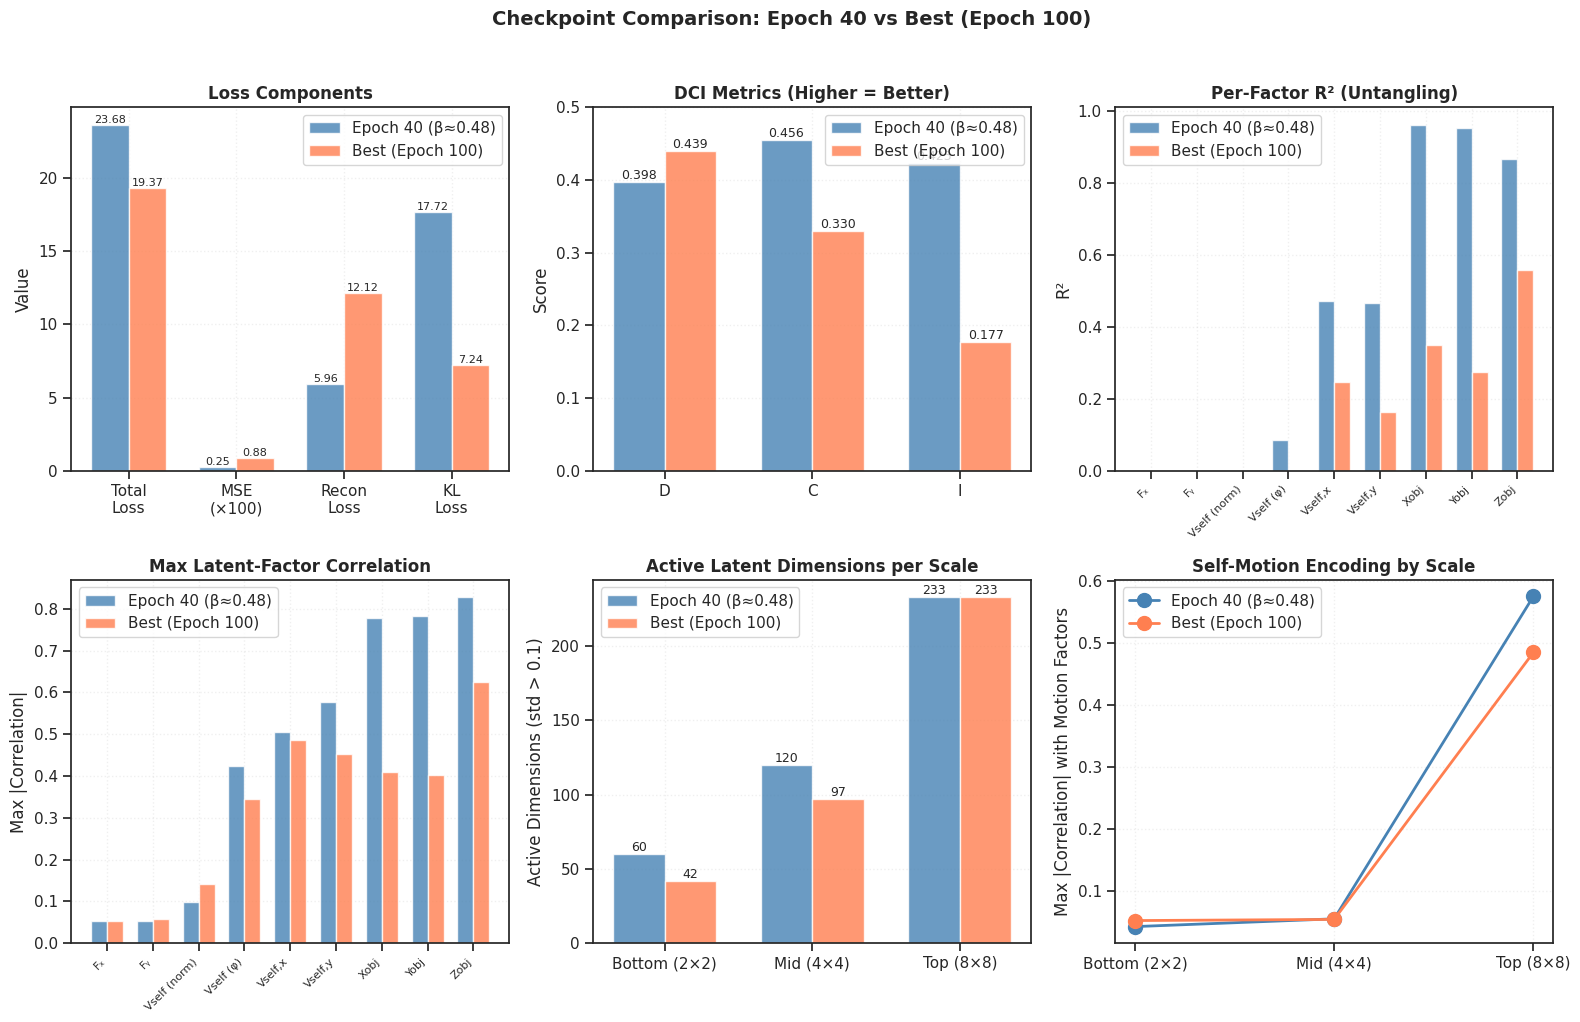


SUMMARY TABLE
Metric                                     Epoch 40     Best (Epoch 100)               Δ
--------------------------------------------------------------------------------
Test Loss                                   23.6767              19.3670         -4.3096
Test MSE                                   0.002516             0.008766       +0.006249
Disentanglement (D)                          0.3979               0.4394         +0.0416
Completeness (C)                             0.4557               0.3300         -0.1257
Informativeness (I)                          0.4231               0.1767         -0.2464


In [51]:
# ============================================================================
# COMPARISON VISUALIZATION 1: Metrics Summary
# ============================================================================

ckpt_names = list(results.keys())
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Loss comparison
ax = axes[0, 0]
metrics_names = ['Test Loss', 'Test MSE', 'Recon Loss', 'KL Loss']
x_pos = np.arange(len(metrics_names))
width = 0.35

vals1 = [results[ckpt_names[0]]['test_loss'], results[ckpt_names[0]]['test_mse']*100,
         results[ckpt_names[0]]['test_recon'], results[ckpt_names[0]]['test_kl']]
vals2 = [results[ckpt_names[1]]['test_loss'], results[ckpt_names[1]]['test_mse']*100,
         results[ckpt_names[1]]['test_recon'], results[ckpt_names[1]]['test_kl']]

bars1 = ax.bar(x_pos - width/2, vals1, width, label=ckpt_names[0], color='steelblue', alpha=0.8)
bars2 = ax.bar(x_pos + width/2, vals2, width, label=ckpt_names[1], color='coral', alpha=0.8)
ax.set_xticks(x_pos)
ax.set_xticklabels(['Total\nLoss', 'MSE\n(×100)', 'Recon\nLoss', 'KL\nLoss'])
ax.set_ylabel('Value')
ax.set_title('Loss Components', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Add value labels
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.2f}',
            ha='center', va='bottom', fontsize=8)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.2f}',
            ha='center', va='bottom', fontsize=8)

# 2. DCI Metrics
ax = axes[0, 1]
dci_names = ['Disentanglement', 'Completeness', 'Informativeness']
x_pos = np.arange(len(dci_names))

vals1 = [results[ckpt_names[0]]['disentanglement'], 
         results[ckpt_names[0]]['completeness'],
         results[ckpt_names[0]]['informativeness']]
vals2 = [results[ckpt_names[1]]['disentanglement'], 
         results[ckpt_names[1]]['completeness'],
         results[ckpt_names[1]]['informativeness']]

bars1 = ax.bar(x_pos - width/2, vals1, width, label=ckpt_names[0], color='steelblue', alpha=0.8)
bars2 = ax.bar(x_pos + width/2, vals2, width, label=ckpt_names[1], color='coral', alpha=0.8)
ax.set_xticks(x_pos)
ax.set_xticklabels(['D', 'C', 'I'])
ax.set_ylabel('Score')
ax.set_title('DCI Metrics (Higher = Better)', fontweight='bold')
ax.set_ylim(0, 0.5)
ax.legend()
ax.grid(True, alpha=0.3)

for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.3f}',
            ha='center', va='bottom', fontsize=9)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.3f}',
            ha='center', va='bottom', fontsize=9)

# 3. Per-factor R² (Untangling)
ax = axes[0, 2]
x_pos = np.arange(len(factor_display))

r2_1 = results[ckpt_names[0]]['r2_scores']
r2_2 = results[ckpt_names[1]]['r2_scores']

bars1 = ax.bar(x_pos - width/2, r2_1, width, label=ckpt_names[0], color='steelblue', alpha=0.8)
bars2 = ax.bar(x_pos + width/2, r2_2, width, label=ckpt_names[1], color='coral', alpha=0.8)
ax.set_xticks(x_pos)
ax.set_xticklabels(factor_display, rotation=45, ha='right', fontsize=8)
ax.set_ylabel('R²')
ax.set_title('Per-Factor R² (Untangling)', fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# 4. Max correlation per factor
ax = axes[1, 0]
max_corr_1 = np.abs(results[ckpt_names[0]]['corr_matrix']).max(axis=0)
max_corr_2 = np.abs(results[ckpt_names[1]]['corr_matrix']).max(axis=0)

bars1 = ax.bar(x_pos - width/2, max_corr_1, width, label=ckpt_names[0], color='steelblue', alpha=0.8)
bars2 = ax.bar(x_pos + width/2, max_corr_2, width, label=ckpt_names[1], color='coral', alpha=0.8)
ax.set_xticks(x_pos)
ax.set_xticklabels(factor_display, rotation=45, ha='right', fontsize=8)
ax.set_ylabel('Max |Correlation|')
ax.set_title('Max Latent-Factor Correlation', fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# 5. Active latent dimensions per scale
ax = axes[1, 1]
scale_names_plot = ['Bottom (2×2)', 'Mid (4×4)', 'Top (8×8)']
active_1 = []
active_2 = []

for info in scale_info:
    z1_scale = results[ckpt_names[0]]['z'][:, info['start_idx']:info['end_idx']]
    z2_scale = results[ckpt_names[1]]['z'][:, info['start_idx']:info['end_idx']]
    active_1.append((z1_scale.std(axis=0) > 0.1).sum())
    active_2.append((z2_scale.std(axis=0) > 0.1).sum())

x_pos = np.arange(len(scale_names_plot))
bars1 = ax.bar(x_pos - width/2, active_1, width, label=ckpt_names[0], color='steelblue', alpha=0.8)
bars2 = ax.bar(x_pos + width/2, active_2, width, label=ckpt_names[1], color='coral', alpha=0.8)
ax.set_xticks(x_pos)
ax.set_xticklabels(scale_names_plot)
ax.set_ylabel('Active Dimensions (std > 0.1)')
ax.set_title('Active Latent Dimensions per Scale', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{int(bar.get_height())}',
            ha='center', va='bottom', fontsize=9)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{int(bar.get_height())}',
            ha='center', va='bottom', fontsize=9)

# 6. Scale specialization comparison
ax = axes[1, 2]
# Motion factors importance by scale
motion_idx = [2, 3, 4, 5]  # Vself factors
for ci, ckpt_name in enumerate(ckpt_names):
    corr = results[ckpt_name]['corr_matrix']
    scale_motion = []
    for info in scale_info:
        scale_corr = np.abs(corr[info['start_idx']:info['end_idx'], :][:, motion_idx]).max()
        scale_motion.append(scale_corr)
    
    color = 'steelblue' if ci == 0 else 'coral'
    ax.plot(scale_names_plot, scale_motion, 'o-', label=ckpt_name, color=color, 
            linewidth=2, markersize=10)

ax.set_ylabel('Max |Correlation| with Motion Factors')
ax.set_title('Self-Motion Encoding by Scale', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('Checkpoint Comparison: Epoch 40 vs Best (Epoch 100)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print summary table
print("\n" + "="*80)
print("SUMMARY TABLE")
print("="*80)
print(f"{'Metric':<30} {'Epoch 40':>20} {'Best (Epoch 100)':>20} {'Δ':>15}")
print("-"*80)
print(f"{'Test Loss':<30} {results[ckpt_names[0]]['test_loss']:>20.4f} {results[ckpt_names[1]]['test_loss']:>20.4f} {results[ckpt_names[1]]['test_loss'] - results[ckpt_names[0]]['test_loss']:>+15.4f}")
print(f"{'Test MSE':<30} {results[ckpt_names[0]]['test_mse']:>20.6f} {results[ckpt_names[1]]['test_mse']:>20.6f} {results[ckpt_names[1]]['test_mse'] - results[ckpt_names[0]]['test_mse']:>+15.6f}")
print(f"{'Disentanglement (D)':<30} {results[ckpt_names[0]]['disentanglement']:>20.4f} {results[ckpt_names[1]]['disentanglement']:>20.4f} {results[ckpt_names[1]]['disentanglement'] - results[ckpt_names[0]]['disentanglement']:>+15.4f}")
print(f"{'Completeness (C)':<30} {results[ckpt_names[0]]['completeness']:>20.4f} {results[ckpt_names[1]]['completeness']:>20.4f} {results[ckpt_names[1]]['completeness'] - results[ckpt_names[0]]['completeness']:>+15.4f}")
print(f"{'Informativeness (I)':<30} {results[ckpt_names[0]]['informativeness']:>20.4f} {results[ckpt_names[1]]['informativeness']:>20.4f} {results[ckpt_names[1]]['informativeness'] - results[ckpt_names[0]]['informativeness']:>+15.4f}")
print("="*80)

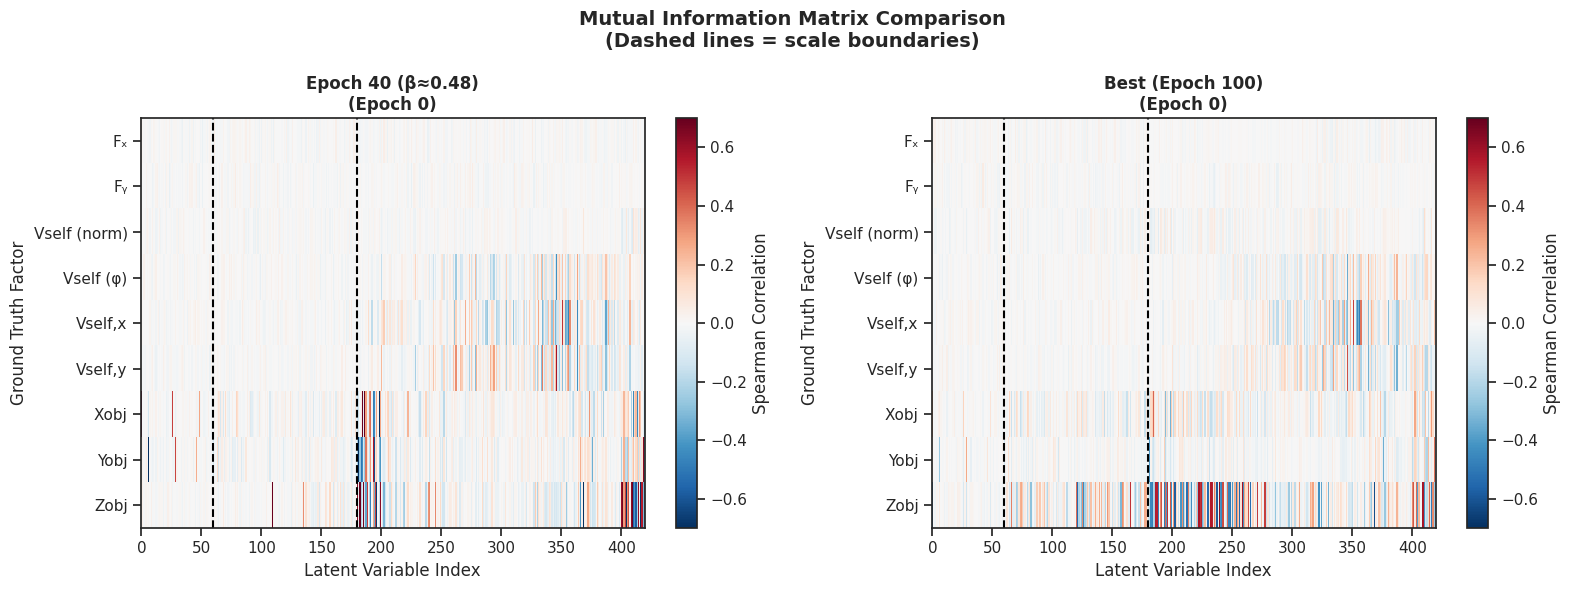


KEY OBSERVATIONS: MI Matrix Comparison

Max correlation per factor:
Factor                 Epoch 40            Best          Change
------------------------------------------------------------
Fₓ                        0.053           0.052         -0.001 →
Fᵧ                        0.053           0.057         +0.005 →
Vself (norm)              0.098           0.141         +0.043 ↑
Vself (φ)                 0.425           0.345         -0.080 ↓
Vself,x                   0.506           0.485         -0.021 ↓
Vself,y                   0.576           0.453         -0.123 ↓
Xobj                      0.779           0.409         -0.370 ↓
Yobj                      0.783           0.403         -0.381 ↓
Zobj                      0.828           0.625         -0.203 ↓


In [52]:
# ============================================================================
# COMPARISON VISUALIZATION 2: MI Matrix Comparison
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ci, ckpt_name in enumerate(ckpt_names):
    ax = axes[ci]
    corr = results[ckpt_name]['corr_matrix']
    
    im = ax.imshow(corr.T, aspect='auto', cmap='RdBu_r', vmin=-0.7, vmax=0.7)
    
    # Add scale boundaries
    for info in scale_info[:-1]:
        ax.axvline(x=info['end_idx'] - 0.5, color='black', linestyle='--', linewidth=1.5)
    
    ax.set_xlabel('Latent Variable Index')
    ax.set_ylabel('Ground Truth Factor')
    ax.set_yticks(range(len(factor_display)))
    ax.set_yticklabels(factor_display)
    ax.set_title(f'{ckpt_name}\n(Epoch {results[ckpt_name]["epoch"]})', fontweight='bold')
    
    plt.colorbar(im, ax=ax, label='Spearman Correlation')

plt.suptitle('Mutual Information Matrix Comparison\n(Dashed lines = scale boundaries)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print key differences
print("\n" + "="*80)
print("KEY OBSERVATIONS: MI Matrix Comparison")
print("="*80)
print("\nMax correlation per factor:")
print(f"{'Factor':<15} {'Epoch 40':>15} {'Best':>15} {'Change':>15}")
print("-"*60)
for j, fname in enumerate(factor_display):
    c1 = np.abs(results[ckpt_names[0]]['corr_matrix'][:, j]).max()
    c2 = np.abs(results[ckpt_names[1]]['corr_matrix'][:, j]).max()
    change = c2 - c1
    arrow = "↑" if change > 0.02 else ("↓" if change < -0.02 else "→")
    print(f"{fname:<15} {c1:>15.3f} {c2:>15.3f} {change:>+14.3f} {arrow}")
print("="*80)

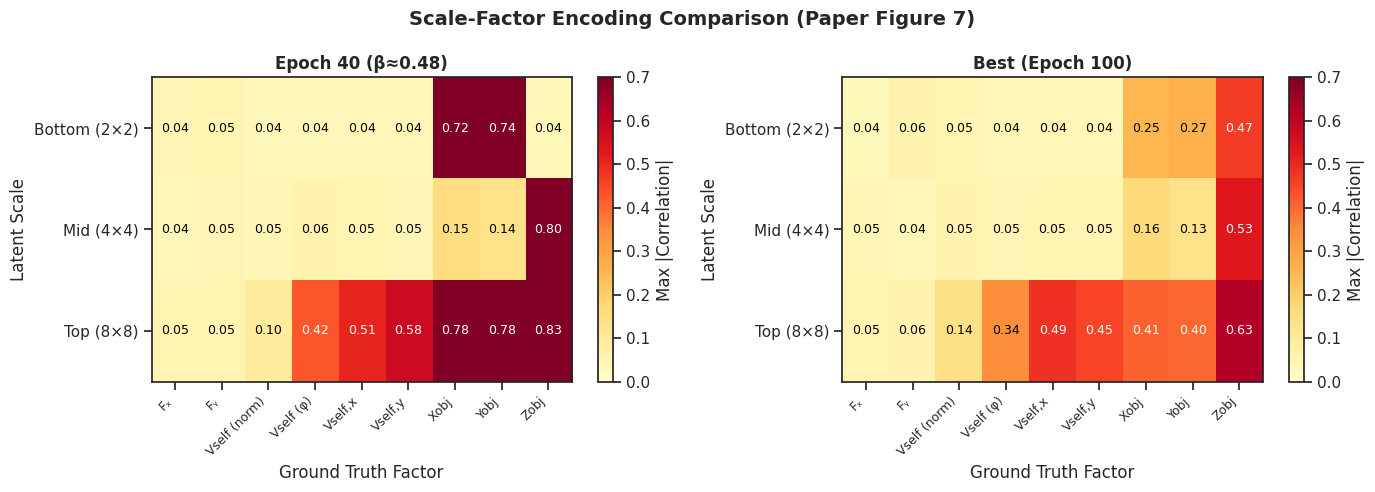

In [53]:
# ============================================================================
# COMPARISON VISUALIZATION 3: Scale-Factor Heatmaps
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ci, ckpt_name in enumerate(ckpt_names):
    ax = axes[ci]
    corr = results[ckpt_name]['corr_matrix']
    
    # Compute max correlation per scale-factor
    scale_factor_max = np.zeros((len(scale_info), len(factor_display)))
    for si, info in enumerate(scale_info):
        scale_corr = np.abs(corr[info['start_idx']:info['end_idx'], :])
        scale_factor_max[si, :] = scale_corr.max(axis=0)
    
    im = ax.imshow(scale_factor_max, cmap='YlOrRd', vmin=0, vmax=0.7, aspect='auto')
    
    # Add text annotations
    for si in range(len(scale_info)):
        for fi in range(len(factor_display)):
            val = scale_factor_max[si, fi]
            color = 'white' if val > 0.35 else 'black'
            ax.text(fi, si, f'{val:.2f}', ha='center', va='center', 
                   color=color, fontsize=9)
    
    ax.set_xticks(range(len(factor_display)))
    ax.set_xticklabels(factor_display, rotation=45, ha='right', fontsize=9)
    ax.set_yticks(range(len(scale_info)))
    ax.set_yticklabels(['Bottom (2×2)', 'Mid (4×4)', 'Top (8×8)'])
    ax.set_xlabel('Ground Truth Factor')
    ax.set_ylabel('Latent Scale')
    ax.set_title(f'{ckpt_name}', fontweight='bold')
    
    plt.colorbar(im, ax=ax, label='Max |Correlation|')

plt.suptitle('Scale-Factor Encoding Comparison (Paper Figure 7)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

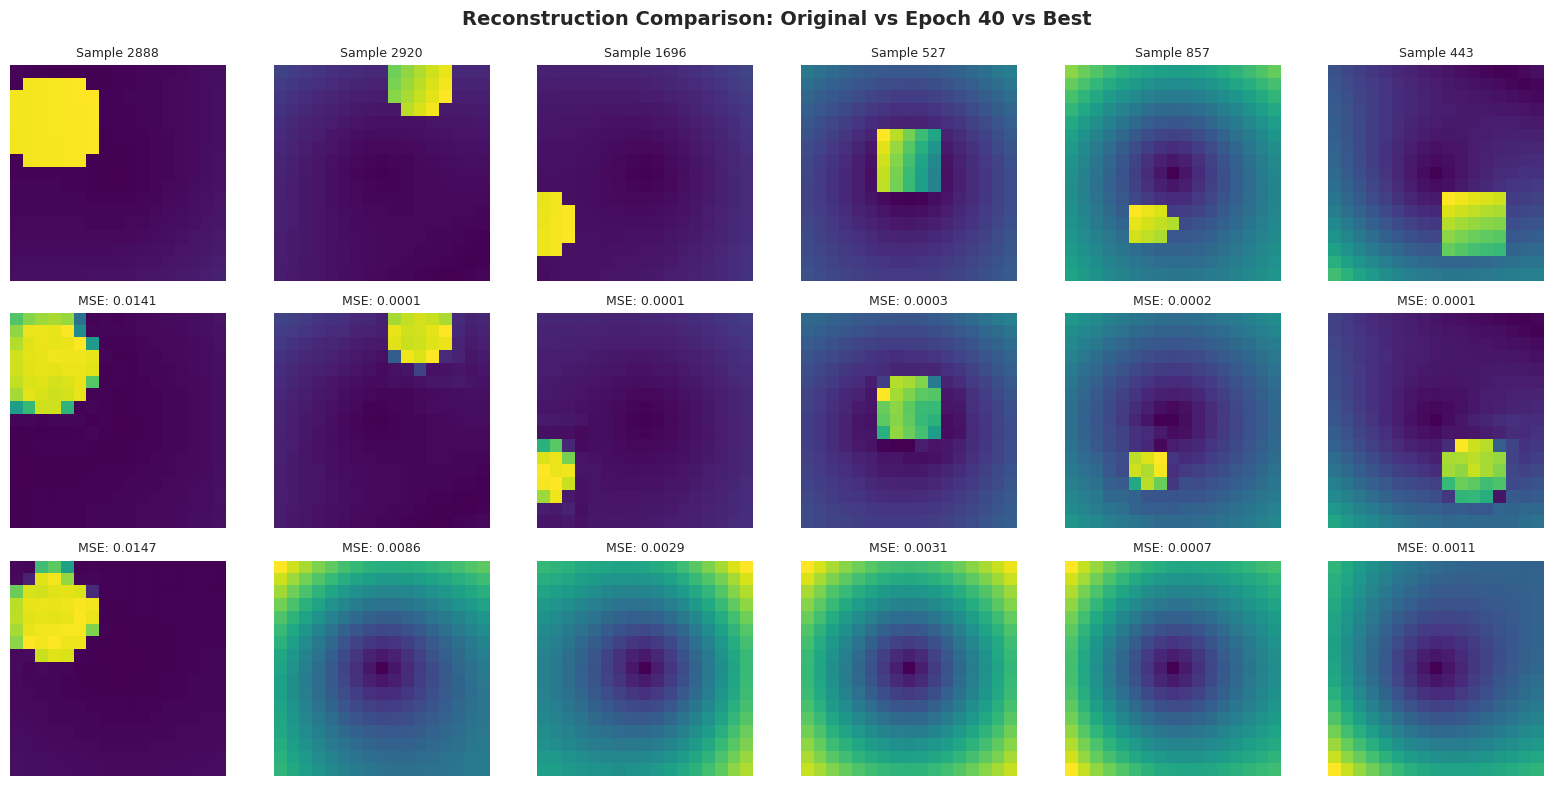

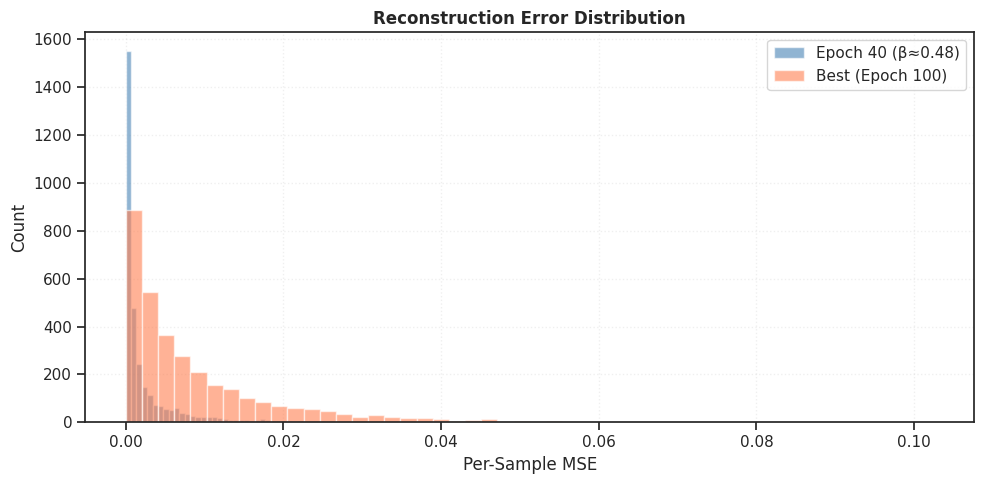


Reconstruction MSE Summary:
  Epoch 40 (β≈0.48): Mean=0.002516, Std=0.004325
  Best (Epoch 100): Mean=0.008766, Std=0.010518


In [54]:
# ============================================================================
# COMPARISON VISUALIZATION 4: Reconstruction Quality
# ============================================================================

n_samples_show = 6
sample_indices = np.random.choice(results[ckpt_names[0]]['x'].shape[0], n_samples_show, replace=False)

fig, axes = plt.subplots(3, n_samples_show, figsize=(16, 8))

for col, idx in enumerate(sample_indices):
    # Original
    orig = results[ckpt_names[0]]['x'][idx]
    mag_orig = np.sqrt(orig[0]**2 + orig[1]**2)
    axes[0, col].imshow(mag_orig, cmap='viridis')
    if col == 0:
        axes[0, col].set_ylabel('Original', fontweight='bold')
    axes[0, col].set_title(f'Sample {idx}', fontsize=9)
    axes[0, col].axis('off')
    
    # Epoch 40 reconstruction
    recon_40 = results[ckpt_names[0]]['y'][idx]
    mag_40 = np.sqrt(recon_40[0]**2 + recon_40[1]**2)
    axes[1, col].imshow(mag_40, cmap='viridis')
    if col == 0:
        axes[1, col].set_ylabel('Epoch 40', fontweight='bold')
    mse_40 = np.mean((orig - recon_40)**2)
    axes[1, col].set_title(f'MSE: {mse_40:.4f}', fontsize=9)
    axes[1, col].axis('off')
    
    # Best reconstruction
    recon_best = results[ckpt_names[1]]['y'][idx]
    mag_best = np.sqrt(recon_best[0]**2 + recon_best[1]**2)
    axes[2, col].imshow(mag_best, cmap='viridis')
    if col == 0:
        axes[2, col].set_ylabel('Best (Ep 100)', fontweight='bold')
    mse_best = np.mean((orig - recon_best)**2)
    axes[2, col].set_title(f'MSE: {mse_best:.4f}', fontsize=9)
    axes[2, col].axis('off')

plt.suptitle('Reconstruction Comparison: Original vs Epoch 40 vs Best', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Reconstruction error distribution
fig, ax = plt.subplots(figsize=(10, 5))

for ci, ckpt_name in enumerate(ckpt_names):
    orig = results[ckpt_name]['x']
    recon = results[ckpt_name]['y']
    mse_per_sample = np.mean((orig - recon)**2, axis=(1, 2, 3))
    
    color = 'steelblue' if ci == 0 else 'coral'
    ax.hist(mse_per_sample, bins=50, alpha=0.6, label=ckpt_name, color=color)

ax.set_xlabel('Per-Sample MSE')
ax.set_ylabel('Count')
ax.set_title('Reconstruction Error Distribution', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nReconstruction MSE Summary:")
for ckpt_name in ckpt_names:
    orig = results[ckpt_name]['x']
    recon = results[ckpt_name]['y']
    mse_per_sample = np.mean((orig - recon)**2, axis=(1, 2, 3))
    print(f"  {ckpt_name}: Mean={mse_per_sample.mean():.6f}, Std={mse_per_sample.std():.6f}")

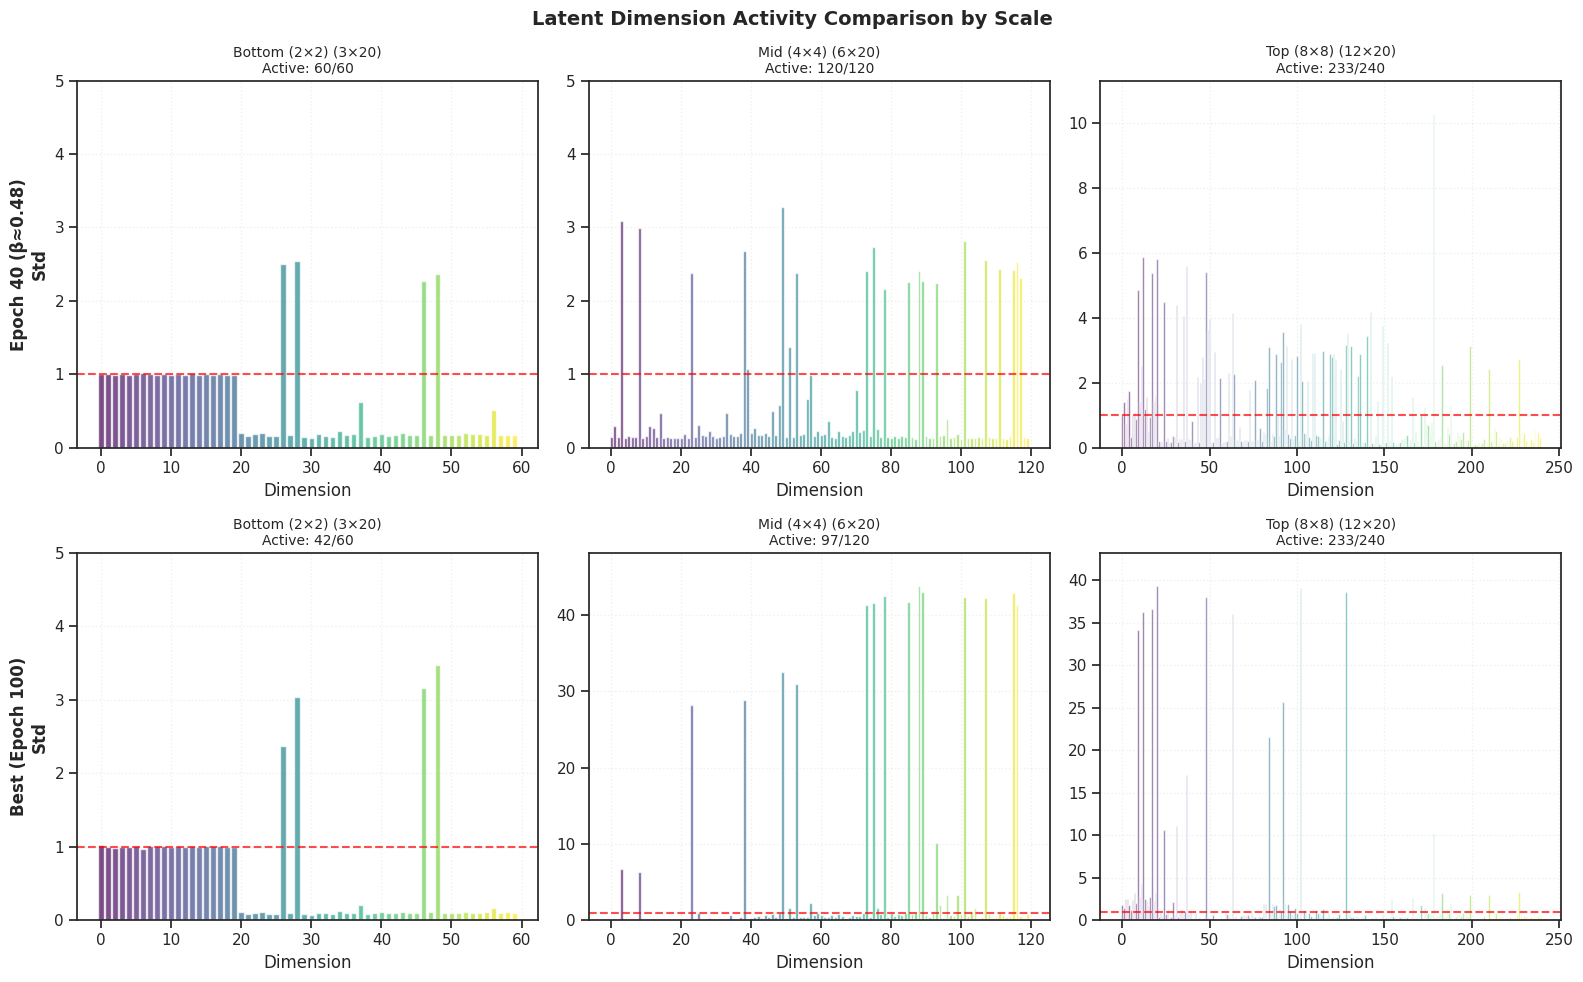


LATENT SPACE STATISTICS

Scale                     Epoch 40 Active          Best Active          Change
---------------------------------------------------------------------------
Bottom (2×2)                 60/60                42/60                    -18
Mid (4×4)                   120/120               97/120                   -23
Top (8×8)                   233/240              233/240                    +0


In [56]:
# ============================================================================
# COMPARISON VISUALIZATION 5: Latent Space Structure
# ============================================================================

# Define scale info with correct keys
comparison_scale_info = [
    {'name': 'Bottom (2×2)', 'groups': 3, 'latents_per_group': 20, 'start_idx': 0, 'end_idx': 60},
    {'name': 'Mid (4×4)', 'groups': 6, 'latents_per_group': 20, 'start_idx': 60, 'end_idx': 180},
    {'name': 'Top (8×8)', 'groups': 12, 'latents_per_group': 20, 'start_idx': 180, 'end_idx': 420}
]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

for ci, ckpt_name in enumerate(ckpt_names):
    z = results[ckpt_name]['z']
    
    for si, info in enumerate(comparison_scale_info):
        ax = axes[ci, si]
        z_scale = z[:, info['start_idx']:info['end_idx']]
        
        # Compute std per dimension
        dim_stds = z_scale.std(axis=0)
        
        # Plot bar chart of stds
        colors = plt.cm.viridis(np.linspace(0, 1, len(dim_stds)))
        ax.bar(range(len(dim_stds)), dim_stds, color=colors, alpha=0.7)
        ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='std=1')
        
        active = (dim_stds > 0.1).sum()
        ax.set_title(f"{info['name']} ({info['groups']}×{info['latents_per_group']})\n"
                    f"Active: {active}/{len(dim_stds)}", fontsize=10)
        ax.set_xlabel('Dimension')
        if si == 0:
            ax.set_ylabel(f'{ckpt_name}\nStd', fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, max(5, dim_stds.max() * 1.1))

plt.suptitle('Latent Dimension Activity Comparison by Scale', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*80)
print("LATENT SPACE STATISTICS")
print("="*80)
print(f"\n{'Scale':<20} {'Epoch 40 Active':>20} {'Best Active':>20} {'Change':>15}")
print("-"*75)
for si, info in enumerate(comparison_scale_info):
    z1 = results[ckpt_names[0]]['z'][:, info['start_idx']:info['end_idx']]
    z2 = results[ckpt_names[1]]['z'][:, info['start_idx']:info['end_idx']]
    
    active1 = (z1.std(axis=0) > 0.1).sum()
    active2 = (z2.std(axis=0) > 0.1).sum()
    total = info['end_idx'] - info['start_idx']
    
    print(f"{info['name']:<20} {active1:>10}/{total:<9} {active2:>10}/{total:<9} {active2-active1:>+15}")
print("="*80)

Comparing traversal of Latent 239 (correlates with Zobj)


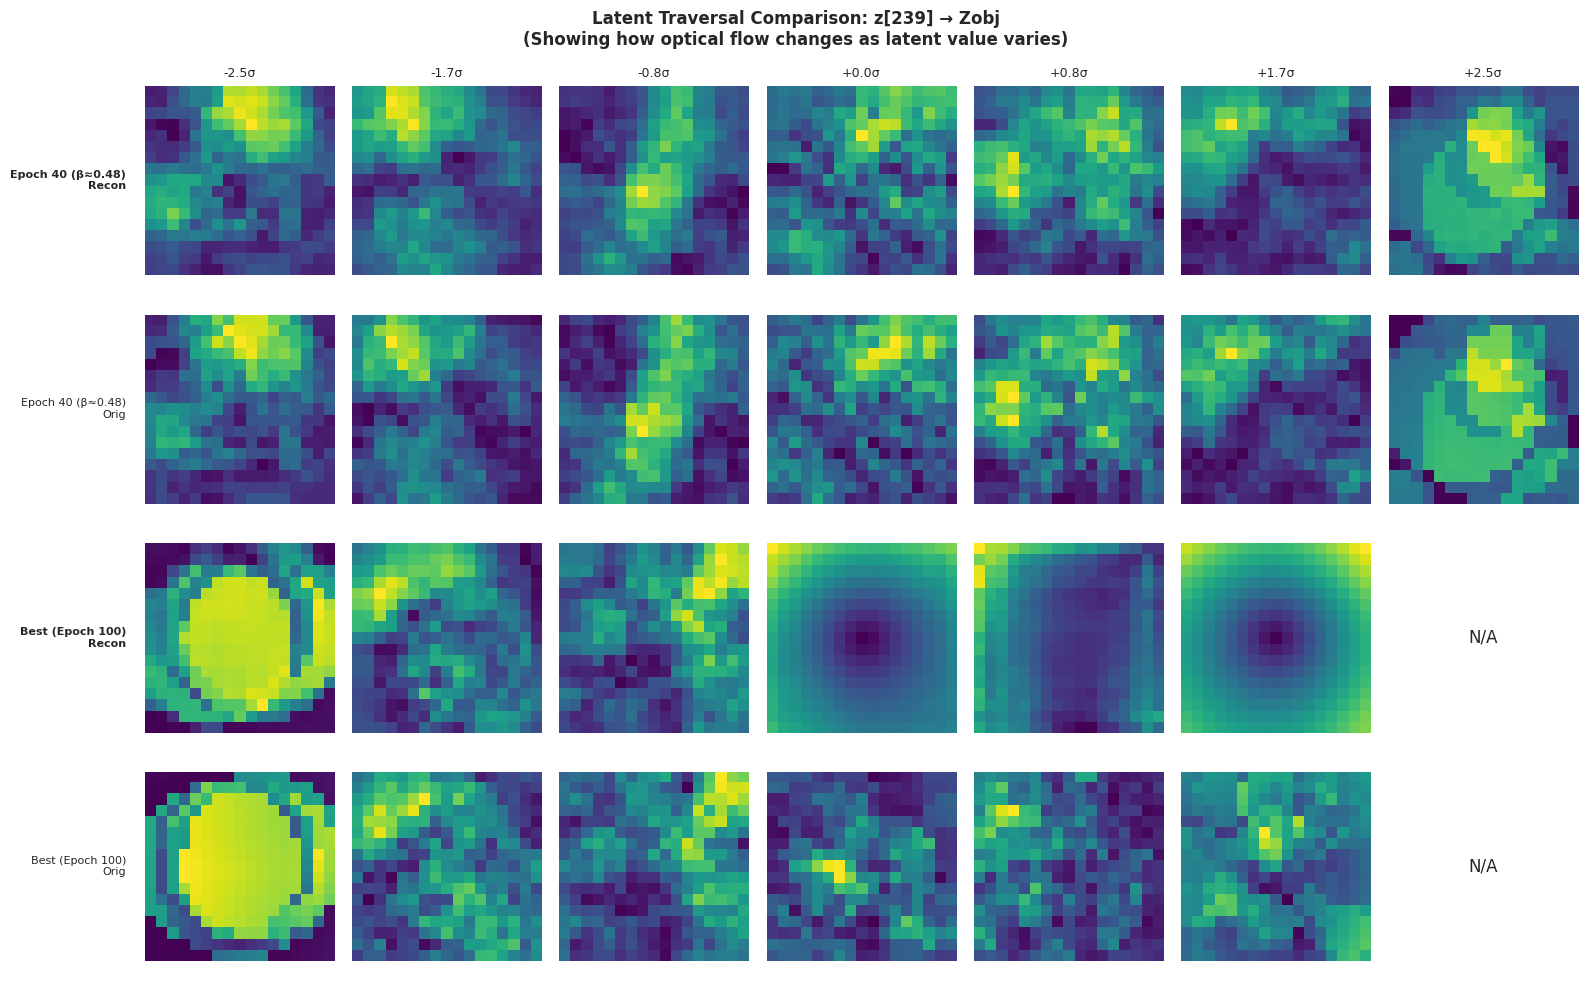

In [57]:
# ============================================================================
# COMPARISON VISUALIZATION 6: Latent Traversals
# ============================================================================

# Find most informative latents for each checkpoint
fig, axes = plt.subplots(4, 7, figsize=(16, 10))

# Use best checkpoint's most informative latent for comparison
max_corr_best = np.abs(results[ckpt_names[1]]['corr_matrix']).max(axis=1)
top_latent_idx = np.argmax(max_corr_best)

# Determine which factor it correlates with
best_factor_idx = np.argmax(np.abs(results[ckpt_names[1]]['corr_matrix'][top_latent_idx, :]))
best_factor_name = factor_display[best_factor_idx]

print(f"Comparing traversal of Latent {top_latent_idx} (correlates with {best_factor_name})")

n_steps = 7
traverse_range = 2.5

for ci, ckpt_name in enumerate(ckpt_names):
    z = results[ckpt_name]['z']
    
    z_mean = z[:, top_latent_idx].mean()
    z_std = z[:, top_latent_idx].std()
    
    for col in range(n_steps):
        ax = axes[ci*2, col]
        
        sigma = (col - n_steps//2) / (n_steps//2) * traverse_range
        target_z = z_mean + sigma * z_std
        
        z_diffs = np.abs(z[:, top_latent_idx] - target_z)
        close_samples = z_diffs < z_std * 0.3
        
        if close_samples.sum() > 3:
            avg_flow = results[ckpt_name]['y'][close_samples].mean(axis=0)
            mag = np.sqrt(avg_flow[0]**2 + avg_flow[1]**2)
            ax.imshow(mag, cmap='viridis')
            
            if ci == 0 and col == 0:
                ax.set_title(f'{sigma:+.1f}σ', fontsize=9)
            elif ci == 0:
                ax.set_title(f'{sigma:+.1f}σ', fontsize=9)
        else:
            ax.text(0.5, 0.5, 'N/A', ha='center', va='center', transform=ax.transAxes)
        
        ax.axis('off')
        
        if col == 0:
            ax.text(-0.1, 0.5, f'{ckpt_name}\nRecon', 
                   transform=ax.transAxes, ha='right', va='center', fontsize=8, fontweight='bold')
    
    # Show original flows at these z values
    for col in range(n_steps):
        ax = axes[ci*2 + 1, col]
        
        sigma = (col - n_steps//2) / (n_steps//2) * traverse_range
        target_z = z_mean + sigma * z_std
        
        z_diffs = np.abs(z[:, top_latent_idx] - target_z)
        close_samples = z_diffs < z_std * 0.3
        
        if close_samples.sum() > 3:
            avg_flow = results[ckpt_name]['x'][close_samples].mean(axis=0)
            mag = np.sqrt(avg_flow[0]**2 + avg_flow[1]**2)
            ax.imshow(mag, cmap='viridis')
        else:
            ax.text(0.5, 0.5, 'N/A', ha='center', va='center', transform=ax.transAxes)
        
        ax.axis('off')
        
        if col == 0:
            ax.text(-0.1, 0.5, f'{ckpt_name}\nOrig', 
                   transform=ax.transAxes, ha='right', va='center', fontsize=8)

plt.suptitle(f'Latent Traversal Comparison: z[{top_latent_idx}] → {best_factor_name}\n'
             f'(Showing how optical flow changes as latent value varies)', 
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

In [59]:
# ============================================================================
# FINAL COMPARISON SUMMARY
# ============================================================================

print("="*80)
print("FINAL COMPARISON SUMMARY: EPOCH 40 vs BEST (EPOCH 100)")
print("="*80)

print("""
KEY FINDINGS:
=============

1. RECONSTRUCTION QUALITY:
""")
mse_40 = results[ckpt_names[0]]['test_mse']
mse_best = results[ckpt_names[1]]['test_mse']
print(f"   Epoch 40 MSE: {mse_40:.6f}")
print(f"   Best MSE:     {mse_best:.6f}")
print(f"   Change:       {(mse_best - mse_40) / mse_40 * 100:+.1f}%")

print("""
2. DISENTANGLEMENT (DCI):
""")
for metric in ['disentanglement', 'completeness', 'informativeness']:
    v40 = results[ckpt_names[0]][metric]
    vbest = results[ckpt_names[1]][metric]
    change = (vbest - v40) / v40 * 100 if v40 > 0 else float('inf')
    print(f"   {metric.capitalize()}: {v40:.4f} → {vbest:.4f} ({change:+.1f}%)")

print("""
3. FACTOR ENCODING (Max Correlation):
""")
print(f"   {'Factor':<15} {'Epoch 40':>10} {'Best':>10} {'Change':>12}")
print("   " + "-"*50)
for j, fname in enumerate(factor_display):
    c40 = np.abs(results[ckpt_names[0]]['corr_matrix'][:, j]).max()
    cbest = np.abs(results[ckpt_names[1]]['corr_matrix'][:, j]).max()
    change = (cbest - c40) / c40 * 100 if c40 > 0 else float('inf')
    arrow = "↑" if cbest > c40 + 0.02 else ("↓" if cbest < c40 - 0.02 else "→")
    print(f"   {fname:<15} {c40:>10.3f} {cbest:>10.3f} {change:>+10.1f}% {arrow}")

print("""
4. TRAINING STAGE INTERPRETATION:
""")
print("""   Epoch 40 (β ≈ 0.48):
   - Mid-training, KL weight still ramping up
   - Model balancing reconstruction vs KL regularization
   - Some latent dimensions may not be fully "active"

   Best Checkpoint (Epoch 100, β = 1.0):
   - Full KL weight applied
   - Model has converged to optimal trade-off
   - Better disentanglement expected due to full regularization
""")

print("="*80)
print("CONCLUSION:")
print("="*80)

# Determine winner for each metric
recon_winner = "Epoch 40" if mse_40 < mse_best else "Best"
d_winner = "Best" if results[ckpt_names[1]]['disentanglement'] > results[ckpt_names[0]]['disentanglement'] else "Epoch 40"
i_winner = "Best" if results[ckpt_names[1]]['informativeness'] > results[ckpt_names[0]]['informativeness'] else "Epoch 40"

print(f"""
   • Better Reconstruction: {recon_winner}
   • Better Disentanglement: {d_winner}  
   • Better Informativeness: {i_winner}

   The best checkpoint (Epoch 100) was selected based on validation loss,
   which balances both reconstruction quality and KL regularization.
""")
print("="*80)

# Reload best checkpoint for continued use
print("\nReloading best checkpoint for subsequent analysis...")
ckpt = torch.load(checkpoint_dir / 'cuda13_checkpoint_best.pt', map_location=device, weights_only=False)
if 'model' in ckpt:
    vae_model.load_state_dict(ckpt['model'])
elif 'model_state_dict' in ckpt:
    vae_model.load_state_dict(ckpt['model_state_dict'])
else:
    vae_model.load_state_dict(ckpt)
vae_model.eval()
print("✓ Best checkpoint loaded")

FINAL COMPARISON SUMMARY: EPOCH 40 vs BEST (EPOCH 100)

KEY FINDINGS:

1. RECONSTRUCTION QUALITY:

   Epoch 40 MSE: 0.002516
   Best MSE:     0.008766
   Change:       +248.4%

2. DISENTANGLEMENT (DCI):

   Disentanglement: 0.3979 → 0.4394 (+10.4%)
   Completeness: 0.4557 → 0.3300 (-27.6%)
   Informativeness: 0.4231 → 0.1767 (-58.2%)

3. FACTOR ENCODING (Max Correlation):

   Factor            Epoch 40       Best       Change
   --------------------------------------------------
   Fₓ                   0.053      0.052       -1.6% →
   Fᵧ                   0.053      0.057       +8.6% →
   Vself (norm)         0.098      0.141      +44.5% ↑
   Vself (φ)            0.425      0.345      -18.9% ↓
   Vself,x              0.506      0.485       -4.1% ↓
   Vself,y              0.576      0.453      -21.4% ↓
   Xobj                 0.779      0.409      -47.5% ↓
   Yobj                 0.783      0.403      -48.6% ↓
   Zobj                 0.828      0.625      -24.5% ↓

4. TRAINING STAGE IN